<font size = 6> **Оценка эффективности привлечения аудитории телеграм-каналом города Иннополис**

<font size = 4> **Оглавление**</font>
1. [Постановка задачи и ход исследования](#start)
2. [Импорт библиотек](#library)
3. [Загрузка и изучение данных](#prepare)
4. [Предварительная обработка данных](#4)
5. [Исследовательский анализ](#5)
6. [Анализ эмодзи](#6)
7. [Рекомендации](#7)
8. [Выводы](#8)

<a id="start"></a>
<a id="start"></a>
## Постановка задачи и ход исследования
**Общее описание задачи**:
* анализ текущего состояния телеграм-канала города,
* выявление эффективных и неэффективных публикаций для привлечения аудитории.

**Цель:**
- увеличение лояльной аудитории бренда путем увеличения количества подписчиков телеграм-канала @innopolistg;
- разработка KPI, позволяющих оценить эффективность публикации;
- выявление тем публикаций, которые побуждают подписчиков переезжать в Иннополис.

**В исследовании:**
- Произведем загрузку в рабочую папку предоставленных таблиц
- Проведем исследовательский анализ данных
- Изучим тематику постов Иннополиса
- Выведем метрики эффективности поста:
    - Отсутствие / наличие изображений, ссылок, документов
    - Тема - поскольку Заказчик не предоставил темы своих публикаций - произведем классификацию исходя из текста постов
    - Объем текста - посчитаем количество слов и символов к каждой публикации
    - Отсутствие / наличие эмодзи
    - Сложность текста - проанализируем знаки препинания
 - Построим Облако слов, для выявления наиболее популярных и непопулярных тем публикаций
 - Определим самые популярные темы, используя выбранные нами метрики для оценки
 - Рассчитаем время жизни поста
 - Определим зависимость времени жизни поста от:
  - дня месяца публикации
  - дня недели публикации
  - времени суток публикации
- Определим лучшее время для публикаций
- Проведем семантический анализ комментариев к постам: попытаемся выяснить, какие посты побуждают людей переехать/приехать в Иннополис.
- Проведем Анализ эмодзи. Аналогично предыдущему пункту посчитаем количество эмодзи в зависимости от темы, типа публикаций, использованных слов, объема текста, сложностью текста.
- По возможности установим зависимость от положительных и отрицательных эмодзи.


**Ход исследования:**
- Загрузка данных из предоставленных файлов и подготовка их к анализу
- Обработка данных, изучение общей информации о датафрейме
- Расчет и определение дополнительных данных
- Объединение данных в сводную таблицу
- Исследовательский анализ данных
- Выводы и заключения

<a id="library"></a>
## Импорт библиотек

In [1]:
import pandas as pd
import warnings
import gspread
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
import math

#для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

#для анализа текста
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import pymorphy3
import re
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arinagurevskaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arinagurevskaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<a id="prepare"></a>
## Загрузка и изучение данных

Создадим функцию `load_files` для загрузки данных в Юпитер

In [2]:
def load_files(file_name):
    df= pd.read_csv(file_name)
    print("\033[34m""\033[1m""Первые строки датафрейма")
    display(df.head(5))
    print("\033[34m""\033[1m""Информация о типах данных")
    print()
    display(df.info())
    print("\033[34m""\033[1m""Доля пропущенных значений ")
    display(round(df.isna().mean() * 100).astype(int))
    print("\033[34m""\033[1m""Количество явных дубликатов ")
    display(df.duplicated().sum())
    return(df)

Загрузим в тетрадку **первый** файл - `innopolistg`  
Заказчик сообщил нам структуру файла `innopolistg`

|Название столбца |Что означает | |
|:-----|:----|----:|
'id'|	номер публикации||
 'date'|	дата публикации||
 'text'|	текст публикации||
 'views'|	количество просмотров||
 'reactions_count'|	количество реакций (эмодзи)||
 'comments'|	количество комментариев||
 'type_attachment'|	тип публикации - наличие прилодженного фото/видео, ссылки, документа или ничего не приложено||


In [3]:
innopolistg = load_files('innopolistg.csv')

Первые строки датафрейма


Unnamed: 0                   channel    id                       date  \
0           0  https://t.me/innopolistg  1414  2023-12-04 09:31:49+00:00   
1           7  https://t.me/innopolistg  1407  2023-12-01 14:40:01+00:00   
2           8  https://t.me/innopolistg  1406  2023-12-01 04:16:17+00:00   
3           9  https://t.me/innopolistg  1404  2023-11-30 14:05:01+00:00   
4          10  https://t.me/innopolistg  1403  2023-11-29 16:05:06+00:00   

                                                text   views  reactions_count  \
0  1. Университет Иннополис [открыл штаб-квартиру...  1445.0               31   
1  Провели дискуссию о будущем туризма в Иннополи...  2234.0               51   
2  Настала пора открывать подарки\n\nПоговаривают...  2823.0              109   
3  **Новогодний адвент-календарь** **Иннополиса**...  3284.0              120   
4  Начинаем вечер-дискуссию о туризме в Иннополис...  4350.0               31   

   comments    type_attachment  
0         0  MessageMediaPhoto  
1         2  MessageMediaPhoto  
2         2  MessageMediaPhoto  
3        10  MessageMediaPhoto  
4         1  MessageMediaPhoto

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       536 non-null    int64  
 1   channel          536 non-null    object 
 2   id               536 non-null    int64  
 3   date             536 non-null    object 
 4   text             536 non-null    object 
 5   views            536 non-null    float64
 6   reactions_count  536 non-null    int64  
 7   comments         536 non-null    int64  
 8   type_attachment  488 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 37.8+ KB


None

Доля пропущенных значений 


Unnamed: 0         0
channel            0
id                 0
date               0
text               0
views              0
reactions_count    0
comments           0
type_attachment    9
dtype: int64

Количество явных дубликатов 


0

Ознакомимся с рядом качественных показателей

In [4]:
print("\033[34m""\033[1m"
    ' Количество уникальных постов - ', innopolistg['id'].nunique(),'\n',
    'Количество уникальных каналов - ', innopolistg['channel'].nunique(),'\n',
    'Самая ранняя дата написания поста - ', innopolistg['date'].min(),'\n',
    'Самая поздняя дата написания поста - ', innopolistg['date'].max(),'\n',
    )

 Количество уникальных постов -  536 
 Количество уникальных каналов -  1 
 Самая ранняя дата написания поста -  2022-03-01 13:11:03+00:00 
 Самая поздняя дата написания поста -  2023-12-04 09:31:49+00:00 



In [5]:
innopolistg['type_attachment'].unique()

array(['MessageMediaPhoto', 'MessageMediaDocument', nan,
       'MessageMediaWebPage'], dtype=object)

Отметим, что:
- количество записей - 536
- названия столбцов представлены по правилам хорошего тона
- все данные представлены в формате `object`. Потребуется данные в столбце:
 - `id`,	`views`,	`reactions_count`, 	`comments` - привести к числовому формату
 - `date` - привести к  формату дата-время (datetime)
- пропущенные значения не выявлены, во всех строках , во всех столбцах присутствуют данные
- количество уникальных постов -  536 и оно совпадает с количеством записей
- все данные предоставлены из одного источника (канала)
- данные представлены за период с  1 марта 2022 года по 4 декабря 2023 года, то есть за 21 месяц
- в датафррейме присутствует первый столбец, названный `Unnamed: 0` и в нем, видимо, отражена нумерация постов в обратном хронологическом порядке.
 - обратим внимание, что пропущены номера с 1 по 6 включительно.
- в `id` постов пропущены значения - также видим, что отсутствуют по меньшей мере посты с `id` от 1406 по 1413
- в столбце `type_attachment` пропущены 9% значений - к этим постам не прикреплены ни фото, ни ссылки, ни документы


Загрузим в тетрадку **второй файл** - `innopolistg_emoji`  
Заказчик сообщил нам структуру файла `innopolistg_emoji`

|Название столбца |Что означает | |
|:-----|:----|----:|
'id'|	номер публикации||
 'date'|	дата публикации||
 'text'|	текст публикации||
 'views'|	количество просмотров||
 'reactions_count'|	количество реакций (эмодзи)||
 'comments'|	количество комментариев||
 'type_attachment'|	тип публикации - наличие прилодженного фото/видео, ссылки, документа или ничего не приложено||
 'reactions'|	графическое отображение эмодзи (иконки)||


In [6]:
innopolistg_emoji = load_files('innopolistg_emoji.csv')

Первые строки датафрейма


Unnamed: 0  index                   channel    id  \
0           0      5  https://t.me/innopolistg  1421   
1           1      6  https://t.me/innopolistg  1420   
2           2     11  https://t.me/innopolistg  1415   
3           3     12  https://t.me/innopolistg  1414   
4           4     19  https://t.me/innopolistg  1407   

                        date  \
0  2023-12-06 12:41:17+00:00   
1  2023-12-05 06:01:58+00:00   
2  2023-12-04 15:15:49+00:00   
3  2023-12-04 09:31:49+00:00   
4  2023-12-01 14:40:01+00:00   

                                                text   views  reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
1  В поисках новых подарков Дед Мороз заглянул в ...  2116.0               36   
2  В первую неделю зимы слушаем классическую музы...  2175.0               22   
3  1. Университет Иннополис [открыл штаб-квартиру...  2391.0               38   
4  Провели дискуссию о будущем туризма в Иннополи...  2819.0               52   

   comments    type_attachment  \
0         4  MessageMediaPhoto   
1         6  MessageMediaPhoto   
2         3  MessageMediaPhoto   
3         0  MessageMediaPhoto   
4         2  MessageMediaPhoto   

                                           reactions  
0  {'_': 'MessageReactions', 'results': [{'_': 'R...  
1  {'_': 'MessageReactions', 'results': [{'_': 'R...  
2  {'_': 'MessageReactions', 'results': [{'_': 'R...  
3  {'_': 'MessageReactions', 'results': [{'_': 'R...  
4  {'_': 'MessageReactions', 'results': [{'_': 'R...

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       539 non-null    int64  
 1   index            539 non-null    int64  
 2   channel          539 non-null    object 
 3   id               539 non-null    int64  
 4   date             539 non-null    object 
 5   text             539 non-null    object 
 6   views            539 non-null    float64
 7   reactions_count  539 non-null    int64  
 8   comments         539 non-null    int64  
 9   type_attachment  491 non-null    object 
 10  reactions        534 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 46.4+ KB


None

Доля пропущенных значений 


Unnamed: 0         0
index              0
channel            0
id                 0
date               0
text               0
views              0
reactions_count    0
comments           0
type_attachment    9
reactions          1
dtype: int64

Количество явных дубликатов 


0

Ознакомимся с рядом качественных показателей

In [7]:
print("\033[34m""\033[1m"
    ' Количество уникальных постов - ', innopolistg_emoji['id'].nunique(),'\n',
    'Количество уникальных каналов - ', innopolistg_emoji['channel'].nunique(),'\n',
    'Самая ранняя дата написания поста - ', innopolistg_emoji['date'].min(),'\n',
    'Самая поздняя дата написания поста - ', innopolistg_emoji['date'].max(),'\n',
    )

 Количество уникальных постов -  539 
 Количество уникальных каналов -  1 
 Самая ранняя дата написания поста -  2022-03-01 13:11:03+00:00 
 Самая поздняя дата написания поста -  2023-12-06 12:41:17+00:00 



In [8]:
innopolistg_emoji['type_attachment'].unique()

array(['MessageMediaPhoto', 'MessageMediaDocument', nan,
       'MessageMediaWebPage'], dtype=object)

Отметим, что:
- структура данных сходны с предыдущим файлом
- количество записей - 539, то есть на 3 записи больше, чем в предыдущем файле
- названия столбцов представлены по правилам хорошего тона
- все данные представлены в формате `object`. Потребуется данные в столбце:
 - `id`,	`views`,	`reactions_count`, 	`comments` - привести к числовому формату
 - `date` - привести к  формату дата-время (datetime)
- пропущенные значения не выявлены, во всех строках , во всех столбцах присутствуют данные
- количество уникальных постов -  539 и оно совпадает с количеством записей
- все данные предоставлены из одного источника (канала)
- данные представлены за период с  1 марта 2022 года по 6 декабря 2023 года, то есть за 21 месяц.
 - данные предоставлены за период на 2 дня больше, чем в предыдущем файле. Возможно. что именно этим обусловлено большее количество записей (постов)
- в датафррейме присутствует первый столбец, названный `Unnamed: 0` и в нем, видимо, отражена нумерация постов в обратном хронологическом порядке.
 - в датафррейме присутствует второй столбец, названный `index` и в нем, видимо, отражен некий индекс постов в обратном хронологическом порядке.
- в `id` постов пропущены значения - также видим, что отсутствуют по меньшей мере посты с `id` от 1406 по 1413
- в столбце `type_attachment` пропущены 9% значений - к этим постам не прикреплены ни фото, ни ссылки, ни документы
 - в столбце `reactions` пропущены 1% значений - на них читатели не поствини никаких эмодзи


Загрузим в тетрадку **третий файл** - `comments_innopolistg_061223`  
Заказчик сообщил нам структуру файла `comments_innopolistg_061223`

|Название столбца |Что означает | |
|:-----|:----|----:|
'post_id'|	номер публикации||
 'date_comment'|	дата написания комментария||
 'text_comment'|	текст комментария||

In [9]:
comments_innopolistg = load_files('comments_innopolistg_061223.csv')

Первые строки датафрейма


Unnamed: 0  post_id               date_comment  \
0           0     1421  2023-12-06 12:42:17+00:00   
1           1     1421  2023-12-06 12:42:40+00:00   
2           2     1421  2023-12-06 12:46:43+00:00   
3           3     1421  2023-12-06 13:55:10+00:00   
4           4     1420  2023-12-05 06:04:14+00:00   

                                        text_comment  
0                                                  💔  
1                                                NaN  
2  Предлагаю также в других номинациях голосовать...  
3                                                 ❤️  
4  Очень интересное сотрудничество! Уверен, что в...

Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2511 non-null   int64 
 1   post_id       2511 non-null   int64 
 2   date_comment  2511 non-null   object
 3   text_comment  2013 non-null   object
dtypes: int64(2), object(2)
memory usage: 78.6+ KB


None

Доля пропущенных значений 


Unnamed: 0       0
post_id          0
date_comment     0
text_comment    20
dtype: int64

Количество явных дубликатов 


0

Ознакомимся с рядом качественных показателей

In [10]:
print("\033[34m""\033[1m"
    ' Количество уникальных постов, к которым написаны комментарии - ', comments_innopolistg['post_id'].nunique(),'\n',
    'Самая ранняя дата написания комментария - ', comments_innopolistg['date_comment'].min(),'\n',
    'Самая поздняя дата написания комментария - ', comments_innopolistg['date_comment'].max(),'\n',
    )

 Количество уникальных постов, к которым написаны комментарии -  338 
 Самая ранняя дата написания комментария -  2022-04-05 15:05:17+00:00 
 Самая поздняя дата написания комментария -  2023-12-06 14:52:48+00:00 



Отметим, что:
- количество записей - 2511
- количество постов, которым даны комментарии - 338 (напомним, что всего постов - 536 в первом файле и 539 во втором файле)
- названия столбцов представлены по правилам хорошего тона
- все данные представлены в формате `object`. Потребуется данные в столбце:
 - `post_id` - привести к числовому формату
 - `date_comment` - привести к  формату дата-время (datetime)
- пропущенные значения не выявлены, во всех строках , во всех столбцах присутствуют данные/
 - вместе с тем визуализация показывает, что,к примеру, во второй строке датафрейма данные в колонке `text_comment` отсутствуют. Потребуется уделить внимание возможному отстутствию данных в этом столбце.
- данные представлены за период с  5 апреля 2022 года по 6 декабря 2023 года, то есть за 20 месяцев.
 - за март 2022 года комментарии не предоставлены
- в датафррейме присутствует первый столбец, названный Unnamed: 0 и в нем, видимо, отражена нумерация постов в обратном хронологическом порядке.
- в столбце `text_comment` отсутствует 20% значений - комментарии в этих строках отсутствуют    



Учитывая сказанное:
- потребуется приведение некоторых столбцов к требуемому формату:
 - в файлах `innopolistg` и `innopolistg_emoji`:
   -  `id`,	`views`,	`reactions_count`, 	`comments` - привести к числовому формату
   - `date` - привести к  формату дата-время (datetime)
- в файле `comments_innopolistg`:
  - `post_id` - привести к числовому формату
  - `date_comment` - привести к  формату дата-время (datetime)
  - удалить строки с пустыми значениями в столбце `text_comment`
- целесообразно исключить из рассмотрения период по 5 апреля 2022 года
- выяснить, есть ли строки с отстутствующими данными в столбце `date_comment` датафрейма `comments_innopolistg`


<a id="4"></a>
## Предварительная обработка данных

### Приведем данные к требуемому формату

 В файлах `innopolistg` и `innopolistg_emoji`:
   -  `id`,	`views`,	`reactions_count`, 	`comments` - приведем к числовому формату

In [11]:
def go_to_numeric(data_name, column_name):
    data_name[column_name] = pd.to_numeric(data_name[column_name])

In [12]:
# зададим список файлов
df_list = [innopolistg, innopolistg_emoji]
# зададим список столбцов
col_list = ['id', 'views', 'reactions_count', 'comments']

Приведем к числовому формату

In [13]:
for i in df_list:
    for j in col_list:
        go_to_numeric(i, j)
    print("\033[34m""\033[1m""Информация о типах данных " )
    print()
    display(i.info())

Информация о типах данных 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       536 non-null    int64  
 1   channel          536 non-null    object 
 2   id               536 non-null    int64  
 3   date             536 non-null    object 
 4   text             536 non-null    object 
 5   views            536 non-null    float64
 6   reactions_count  536 non-null    int64  
 7   comments         536 non-null    int64  
 8   type_attachment  488 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 37.8+ KB


None

Информация о типах данных 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       539 non-null    int64  
 1   index            539 non-null    int64  
 2   channel          539 non-null    object 
 3   id               539 non-null    int64  
 4   date             539 non-null    object 
 5   text             539 non-null    object 
 6   views            539 non-null    float64
 7   reactions_count  539 non-null    int64  
 8   comments         539 non-null    int64  
 9   type_attachment  491 non-null    object 
 10  reactions        534 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 46.4+ KB


None

 В файлах `innopolistg`, `innopolistg_emoji` и `comments_innopolistg`:
   -  `date` - приведем к формату дата-время
   -  В данных время хранится в формате UTC. Московское стандартное время (MSK) находится в UTC+3. Иннополис находится в одном часовом поясе с Москвой. Приведем даты к московскому времени

In [14]:
# приведем к формату дата-время
innopolistg['date'] = pd.to_datetime(innopolistg['date'])
innopolistg_emoji['date'] = pd.to_datetime(innopolistg_emoji['date'])
comments_innopolistg['date_comment'] = pd.to_datetime(comments_innopolistg['date_comment'])

Проверим форматы

In [15]:
innopolistg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Unnamed: 0       536 non-null    int64              
 1   channel          536 non-null    object             
 2   id               536 non-null    int64              
 3   date             536 non-null    datetime64[ns, UTC]
 4   text             536 non-null    object             
 5   views            536 non-null    float64            
 6   reactions_count  536 non-null    int64              
 7   comments         536 non-null    int64              
 8   type_attachment  488 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(3)
memory usage: 37.8+ KB


In [16]:
comments_innopolistg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Unnamed: 0    2511 non-null   int64              
 1   post_id       2511 non-null   int64              
 2   date_comment  2511 non-null   datetime64[ns, UTC]
 3   text_comment  2013 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 78.6+ KB


 В файлах `innopolistg`, `innopolistg_emoji` и `comments_innopolistg`:
 -  В данных время хранится в формате UTC. Московское стандартное время (MSK) находится в UTC+3. Иннополис находится в одном часовом поясе с Москвой. Приведем даты к московскому времени

In [17]:
# Приведем даты к московскому времени
innopolistg['date'] = innopolistg['date'] + pd.Timedelta(hours=3)
innopolistg_emoji['date'] = innopolistg_emoji['date'] + pd.Timedelta(hours=3)
comments_innopolistg['date_comment'] = comments_innopolistg['date_comment'] + pd.Timedelta(hours=3)

 В файле `comments_innopolistg` :
   -  `post_id`- приведем к числовому формату

In [18]:
comments_innopolistg['post_id'] = pd.to_numeric(comments_innopolistg['post_id'])
comments_innopolistg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Unnamed: 0    2511 non-null   int64              
 1   post_id       2511 non-null   int64              
 2   date_comment  2511 non-null   datetime64[ns, UTC]
 3   text_comment  2013 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 78.6+ KB


Удалим строки с отстутствующими данными в столбце `date_comment` датафрейма `comments_innopolistg`.


In [19]:
comments_innopolistg = comments_innopolistg.dropna()

### Избавимся от лишних столбцов в датафреймах `innopolistg_emoji` и `comments_innopolistg`

In [20]:
try:
  innopolistg_emoji = innopolistg_emoji.drop(columns=['Unnamed: 0', 'index', 'channel'])
except:
  innopolistg_emoji = innopolistg_emoji.drop(columns=['index', 'channel'])

In [21]:
try:
  comments_innopolistg = comments_innopolistg.drop(columns=['Unnamed: 0'])
except:
  pass

### Для удобства дальнейшего анализа пустые ячейки в столбце `type_attachment` заменим на удобные значения

In [22]:
innopolistg_emoji['type_attachment'] = innopolistg_emoji['type_attachment'].fillna('только текст')

In [23]:
dict_type = {'MessageMediaPhoto': 'пост с фото', 'MessageMediaDocument':'пост с видео', 'MessageMediaWebPage': 'пост с ссылкой', 'только текст':'только текст'}

In [24]:
innopolistg_emoji['type_attachment'] = innopolistg_emoji['type_attachment'].fillna('только текст')
innopolistg_emoji['type_attachment'] = innopolistg_emoji['type_attachment'].map(dict_type)

In [25]:
innopolistg_emoji['type_attachment'] = innopolistg_emoji['type_attachment'].fillna('только текст')

In [26]:
innopolistg_emoji['type_attachment'].unique()

array(['пост с фото', 'пост с видео', 'только текст', 'пост с ссылкой'],
      dtype=object)

### Определим для каждого поста Тему публикации.  
Заказчик при публиковани постов не указывает тему.  
Просмотрев публикации канала, мы можем идентифицировать несколько встречающихся тем.  
Произведем их категоризацию.

In [27]:
def categorize_purpose(total_income):
    if 'ваканси' in total_income.lower():
        return "Вакансии"
    if len(re.findall(r'https:', total_income)) >= 3:
        return "Подборка новостных ссылок"
    if 'игровая' in total_income.lower():
        return "Игровая техника"
    if 'голосование' in total_income:
        return "Голосование"
    if 'дискусс' in total_income.lower():
        return "Дискуссия"
    if ('словар' and 'айтишн') in total_income.lower():
        return "Словарь"
    if 'трансляц' in total_income.lower():
        return "Трансляция"
    if 'университ' in total_income.lower():
        return "Университет Иннополис"
    if 'иннополис' in total_income.lower():
        return "События Иннополиса"
    if ('искусство' or 'кино' or 'театр' or 'фестивал' or 'спектакл' or 'танец' or 'танца') in total_income.lower():
        return "Культура"
    if 'проект' in total_income.lower():
        return "Проект"
    if 'новый' in total_income.lower():
        return "Новый"
    if ('работ' or 'оффер' or 'льгот' or 'образов') in total_income.lower():
        return "Работа в Иннополисе"
    else:
        return "Другое"


In [28]:
innopolistg_emoji['post_topic'] = innopolistg_emoji['text'].apply(categorize_purpose)



Посмотрим, как публикации распределились по темам:

In [29]:
innopolistg_emoji.groupby('post_topic').agg({'id':'count'}).sort_values('id', ascending = False)

id
post_topic                    
События Иннополиса         135
Подборка новостных ссылок  120
Другое                      96
Университет Иннополис       53
Словарь                     41
Вакансии                    34
Работа в Иннополисе         25
Трансляция                  10
Новый                        8
Проект                       8
Дискуссия                    6
Голосование                  3

Попробуем выделить в Темах публикации "Другое" дополнительные темы:
Выделим в Темах публикации "Другое" - какие слова встречаются наиболее часто.  

In [30]:
# функция для удаления заданного набора символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

# добавили к знакам препинания другие символы, которые хотим удалить
spec_chars = string.punctuation + '\n«»\t—…'

# загрузили список русских стоп-слов
russian_stopwords = set(stopwords.words("russian"))

# расширили список стоп слов
russian_stopwords.update(['это', 'ещё', 'ты','год', 'самый', 'наш', '1', '10', 'который'])

# создали объект для работы с морфологией
morph = pymorphy3.MorphAnalyzer()

# функция для обработки текста
def prepare_text(text):
    # привели все слова к нижнему регистру
    text = text.lower()
    # удалили знаки препинания и другие символы
    text = remove_chars_from_text(text, spec_chars)
    # разбили текст на токены
    text_tokens = word_tokenize(text)

    # удалили стоп-слова из текста
    text_tokens = [word for word in text_tokens if word.lower() not in russian_stopwords]

    # лемматизировали каждый токен
    filtered_text_tokens = [morph.parse(token)[0].normal_form for token in text_tokens]
    return filtered_text_tokens

In [31]:
# объединили посты в одну переменную
text10 = ' '.join(innopolistg_emoji.query('post_topic == "Другое"')['text'].tolist())

# преобразуем текст для анализа
text10 = prepare_text(text10)



In [32]:
# повторно удалилим (приведенные) стоп-слова из текста
text10 = [word for word in text10 if word.lower() not in russian_stopwords]

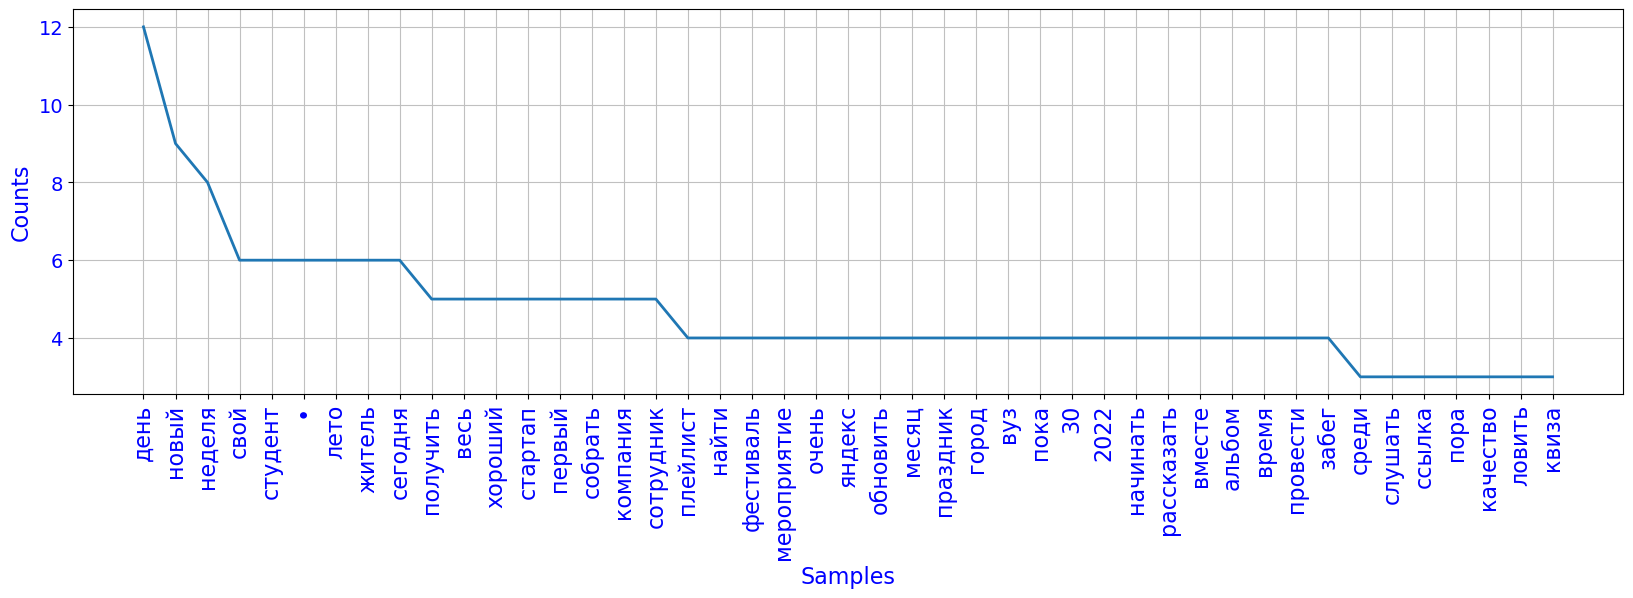

In [33]:
# создали словарь с частотой употребления слов в постах
plt.figure(figsize=(20, 5))
fdist = FreqDist(text10)
plt.xlabel("", fontsize = 16, color = "b")
plt.ylabel("", fontsize = 16, color = "b")
plt.yticks(rotation=0, fontsize=14, color = "b")
plt.xticks(rotation=0, fontsize=16, color = "b")
fdist.plot(45, cumulative=False);

Мы можем увидеть, что помимо слова "день" наиболее часто употребляется слово "новый".  

Учитывая, что 9 случаев такого употребления не увеличат значимо группу постов, оставим созданную категоризацию в текущем виде.

### Построим облако слов, выявим популярные слова

Подгрузим две библиотеки - для работы облака в Юпитере

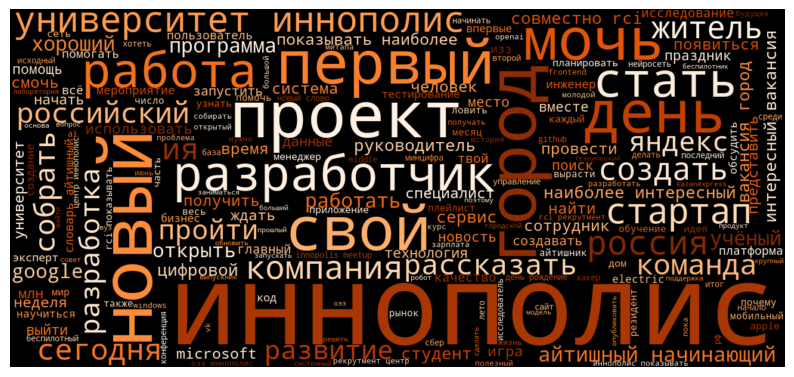

In [34]:
# объединили посты в одну переменную
word_cloud = ' '.join(innopolistg_emoji['text'].tolist())

word_cloud = prepare_text(word_cloud)

# повторно удалилим (приведенные) стоп-слова из текста
word_cloud = [word for word in word_cloud if word.lower() not in russian_stopwords]

# соберем текст
word_cloud_text = ' '.join(word_cloud)

# создание облака слов
wordcloud = WordCloud(width=1300, height=600, background_color='black', colormap='Oranges_r').generate(word_cloud_text)

# Отображение облака слов
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('word_cloud.png')
plt.show()

На данном изображении находятся слова, которые чаще других используются в публикациях канала и характеризуют его смысловую составляющую. К ним относятся слова, связанные с IT сферой (Технология, Яндекс, Google, хакер и др.). Также стоит отметить, что большое количество постов связано с образованием и работой (Студент, вакансия, университет, сотрудник и др.)

Создадим список из пятидесяти наиболее часто встречающихся слов на канале.

In [35]:
# создали словарь с частотой употребления слов в постах
fdist = FreqDist(word_cloud)

# выделили 50 наиболее часто встречающихся слов
fdist_top_50 = pd.DataFrame(fdist.items(), columns=['word', 'frequency']).sort_values(by='frequency',ascending=False)[:50]
fdist_top_50.head(10)

word  frequency
23     иннополис        393
9          новый        110
7          город        101
49   университет         90
6           день         71
446       проект         68
715  разработчик         63
20          свой         61
94      компания         60
65        первый         60

In [36]:
# создали список с наиболее часто встречающимися словами
top_50_word = fdist_top_50['word'].to_list()

# функция для подсчета популярных слов в посте
def count_popular_words(text, words):
    list = []
    prepare_text(text)
    for w in words:
        if w in text:
            list.append(w)
    return len(list)

# количество популярных слов в посте
innopolistg_emoji['popular_word_count'] = innopolistg_emoji['text'].apply(lambda x: count_popular_words(x, top_50_word))

### Объем текста
Вычислим объем текста - посчитаем количество символов в каждой публикации. Мы предполагаем, что на читателя оказывает влияние не только буквы и цифры, а полный объем текста, включая пробелы и символы.  
Вычисленную величину занесем в столбец `simbols_in_text`

In [37]:
for i in innopolistg_emoji['text']:
    result = len(re.findall(r'.', i))
    innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'simbols_in_text'] = len(re.findall(r'.', i))
    innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'words_in_text'] = len(re.findall(r'\w*', i))

Вычислим среднюю длину слова в каждом посте.

In [38]:
innopolistg_emoji['avg_word_len'] = round((innopolistg_emoji['simbols_in_text'] / innopolistg_emoji['words_in_text']),1)

In [39]:
innopolistg_emoji['avg_word_len'].describe()

count    539.000000
mean       2.943043
std        0.352478
min        0.500000
25%        2.800000
50%        2.900000
75%        3.100000
max        4.900000
Name: avg_word_len, dtype: float64

Мы увидим, что средняя длина слова имеет медианного значение , равное 2.9, а максимальное - 4.9. Эти цифры вызывают недоверие.  
Мы предположим, что дело здесь оказывают влдияние предлоги (короткие слова).  

#### Не поленимся и сформируем столбец `text_cloud`, в который запишем "очищенные "слова.


Обработаем текст в столбце `text`

In [40]:
# функция для подсчета слов
def lets_clearn(file_name, column_name):
    for i in tqdm(innopolistg_emoji['text']):
        # объединили посты в одну переменную
        text = ' '.join(innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'text'].tolist())

        # применим функцию для обработки
        filtered_text = prepare_text(text)

        # соберем текст
        filtered_text = ' '.join(filtered_text)
        #print("\033[34m""\033[1m"'НОВЫЙ ТЕКСТ'"\033[00m", filtered_text)

        # перезапишем в столбцы 'simbols_in_text' и 'words_of_text' новые значения, исходя из обработанного текста
        innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'simbols_in_text'] = len(re.findall(r'.', filtered_text))
        innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'words_in_text'] = len(re.findall(r'\w*', filtered_text))

    return

In [41]:
lets_clearn(innopolistg_emoji, 'text')

100%|████████████████████████████████████████| 539/539 [00:01<00:00, 495.99it/s]


In [42]:
innopolistg_emoji['avg_word_len'] = round((innopolistg_emoji['simbols_in_text'] / innopolistg_emoji['words_in_text']),1)

In [43]:
innopolistg_emoji.head()

id                      date  \
0  1421 2023-12-06 15:41:17+00:00   
1  1420 2023-12-05 09:01:58+00:00   
2  1415 2023-12-04 18:15:49+00:00   
3  1414 2023-12-04 12:31:49+00:00   
4  1407 2023-12-01 17:40:01+00:00   

                                                text   views  reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
1  В поисках новых подарков Дед Мороз заглянул в ...  2116.0               36   
2  В первую неделю зимы слушаем классическую музы...  2175.0               22   
3  1. Университет Иннополис [открыл штаб-квартиру...  2391.0               38   
4  Провели дискуссию о будущем туризма в Иннополи...  2819.0               52   

   comments type_attachment  \
0         4     пост с фото   
1         6     пост с фото   
2         3     пост с фото   
3         0     пост с фото   
4         2     пост с фото   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   
1  {'_': 'MessageReactions', 'results': [{'_': 'R...   
2  {'_': 'MessageReactions', 'results': [{'_': 'R...   
3  {'_': 'MessageReactions', 'results': [{'_': 'R...   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                  post_topic  popular_word_count  simbols_in_text  \
0         События Иннополиса                   5            509.0   
1      Университет Иннополис                   3            248.0   
2         События Иннополиса                   1            159.0   
3  Подборка новостных ссылок                   2            678.0   
4                  Дискуссия                   4            412.0   

   words_in_text  avg_word_len  
0          107.0           4.8  
1           47.0           5.3  
2           30.0           5.3  
3           82.0           8.3  
4           84.0           4.9

In [44]:
innopolistg_emoji['avg_word_len'].describe()

count    539.000000
mean       5.705937
std        2.487531
min        0.500000
25%        4.100000
50%        4.800000
75%        6.950000
max       19.300000
Name: avg_word_len, dtype: float64


<div style="border-radius: 45px;border:solid green 7px; padding: 40px">
    
И теперь средняя длина слова имеет медианное значение, равное 4.8 (было - 2.9), а максимальное - 19.3 (было - 4.9).   
Мы сможем в дальнейшем провести анализ популярности публикаций в зависимости от средней длины слова в публикации.


###    Знаки препинания (сложность текста)
Для каждой публикации определим сложность восприятия текста.  
Примем посыл, что чем длиннее строятся предложения - тем сложнее пользователю их читать.  
Как правило, длинные предложения содержать причастные, деепричастные обороты, содержать отсылки и расшифровки. Все это оформляется знаками препинания: запятыми, тире, двоеточиями, точками с запятой.  
Посчитаем для каждой публикации количество знаков препинания. Исключим из подсчетов точку - поскольку именно точкой разграничиваются предложения. Чем меньше точек - тем меньше предложений - тем проще текст.


Создадим новый столбец `punct_marks` и запишем в него количество знаков препинания (за исключением точки)

In [45]:
for i in innopolistg_emoji['text']:
    result = len(re.findall(r'[,;-]', i)) + len(re.findall(r'[:]', i))
    innopolistg_emoji.loc[(innopolistg_emoji['text'] == i), 'punct_marks'] = result


Рассчитаем количество слов, которые в каждой публикации приходится на один знак препинания. Результат запишем в столбец `marks_per_text`

In [46]:
innopolistg_emoji['marks_per_text'] = round(innopolistg_emoji['words_in_text'] / innopolistg_emoji['punct_marks'] )

### Добавим столбец с долей популярных слов в посте

In [47]:
# доля популярных слов в посте
innopolistg_emoji['popular_word_percent'] = round((innopolistg_emoji['popular_word_count']/innopolistg_emoji['words_in_text']*100),2)

### Добавим столбцы, указывающие на то или иное время публикации.
#### Добавим столбцы`year`, `month` и `weekday` для даты публикации поста.  
Понедельник — день под номером 0, а воскресенье — шестой день.  
И добавим столбец `weekday_name` с указанием названия дня недели.

In [48]:
innopolistg_emoji['year'] =  innopolistg_emoji['date'].dt.year
innopolistg_emoji['month'] =  innopolistg_emoji['date'].dt.month
innopolistg_emoji['weekday'] =  innopolistg_emoji['date'].dt.weekday
innopolistg_emoji['weekday_name'] =  innopolistg_emoji['date'].dt.day_name()

#### Добавим столбец `times_of_day` (время суток) для даты публикации поста.

In [49]:
innopolistg_emoji['hour'] = pd.DatetimeIndex(innopolistg_emoji['date']).hour

In [50]:
def categorize_day_period(cheque):

    for cheq in range(len(innopolistg_emoji)):
        if cheque < 6:
            return 'ночь'
        if cheque < 11:
            return 'утро'
        if cheque < 18:
            return 'день'
        else:
            return 'вечер'

innopolistg_emoji['times_of_day'] = innopolistg_emoji['hour'].apply(categorize_day_period)
innopolistg_emoji.head()

id                      date  \
0  1421 2023-12-06 15:41:17+00:00   
1  1420 2023-12-05 09:01:58+00:00   
2  1415 2023-12-04 18:15:49+00:00   
3  1414 2023-12-04 12:31:49+00:00   
4  1407 2023-12-01 17:40:01+00:00   

                                                text   views  reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
1  В поисках новых подарков Дед Мороз заглянул в ...  2116.0               36   
2  В первую неделю зимы слушаем классическую музы...  2175.0               22   
3  1. Университет Иннополис [открыл штаб-квартиру...  2391.0               38   
4  Провели дискуссию о будущем туризма в Иннополи...  2819.0               52   

   comments type_attachment  \
0         4     пост с фото   
1         6     пост с фото   
2         3     пост с фото   
3         0     пост с фото   
4         2     пост с фото   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   
1  {'_': 'MessageReactions', 'results': [{'_': 'R...   
2  {'_': 'MessageReactions', 'results': [{'_': 'R...   
3  {'_': 'MessageReactions', 'results': [{'_': 'R...   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                  post_topic  popular_word_count  ...  avg_word_len  \
0         События Иннополиса                   5  ...           4.8   
1      Университет Иннополис                   3  ...           5.3   
2         События Иннополиса                   1  ...           5.3   
3  Подборка новостных ссылок                   2  ...           8.3   
4                  Дискуссия                   4  ...           4.9   

   punct_marks  marks_per_text  popular_word_percent  year  month  weekday  \
0         18.0             6.0                  4.67  2023     12        2   
1          5.0             9.0                  6.38  2023     12        1   
2          5.0             6.0                  3.33  2023     12        0   
3         34.0             2.0                  2.44  2023     12        0   
4          3.0            28.0                  4.76  2023     12        4   

   weekday_name  hour times_of_day  
0     Wednesday    15         день  
1       Tuesday     9         утро  
2        Monday    18        вечер  
3        Monday    12         день  
4        Friday    17         день  

[5 rows x 22 columns]

### Время жизни поста

Ранее мы обратили внимание, что датафреймы `innopolistg` и `innopolistg_emoji` имеют очень схожее строение. Различаются они в том, что в датафрейме `innopolistg_emoji`
- присутствует столбец `reactions`
- присутствует на 3 записи больше, чем в файле `innopolistg`
- присутствует столбец, названный index

Таким образом, информация, представленная в датафрейме  `innopolistg_emoji` полностью присутствует и в датафрейме `innopolistg`. Учитывая сказаное, исключим из дальнейшего рассмотрения датафрейм `innopolistg`.


Датафрейм `comments_innopolistg` содержит столбец с временем написания комментария.  
Датафрейм `innopolistg_emoji` содержит столбец с временем написания поста.  
Определим время жизни поста как разницу между датой последнего комментария к посту и датой публикации поста.  
Объединим датафреймы `innopolistg_emoji` и `comments_innopolistg`. Назовем сводный датафрейм `data`

In [51]:
data = innopolistg_emoji.merge(comments_innopolistg, left_on = 'id', right_on = 'post_id' )
data.head()

id                      date  \
0  1421 2023-12-06 15:41:17+00:00   
1  1421 2023-12-06 15:41:17+00:00   
2  1421 2023-12-06 15:41:17+00:00   
3  1420 2023-12-05 09:01:58+00:00   
4  1420 2023-12-05 09:01:58+00:00   

                                                text   views  reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
1  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
2  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   
3  В поисках новых подарков Дед Мороз заглянул в ...  2116.0               36   
4  В поисках новых подарков Дед Мороз заглянул в ...  2116.0               36   

   comments type_attachment  \
0         4     пост с фото   
1         4     пост с фото   
2         4     пост с фото   
3         6     пост с фото   
4         6     пост с фото   

                                           reactions             post_topic  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...     События Иннополиса   
1  {'_': 'MessageReactions', 'results': [{'_': 'R...     События Иннополиса   
2  {'_': 'MessageReactions', 'results': [{'_': 'R...     События Иннополиса   
3  {'_': 'MessageReactions', 'results': [{'_': 'R...  Университет Иннополис   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...  Университет Иннополис   

   popular_word_count  ...  popular_word_percent  year  month  weekday  \
0                   5  ...                  4.67  2023     12        2   
1                   5  ...                  4.67  2023     12        2   
2                   5  ...                  4.67  2023     12        2   
3                   3  ...                  6.38  2023     12        1   
4                   3  ...                  6.38  2023     12        1   

   weekday_name  hour  times_of_day  post_id              date_comment  \
0     Wednesday    15          день     1421 2023-12-06 15:42:17+00:00   
1     Wednesday    15          день     1421 2023-12-06 15:46:43+00:00   
2     Wednesday    15          день     1421 2023-12-06 16:55:10+00:00   
3       Tuesday     9          утро     1420 2023-12-05 09:04:14+00:00   
4       Tuesday     9          утро     1420 2023-12-05 16:54:54+00:00   

                                        text_comment  
0                                                  💔  
1  Предлагаю также в других номинациях голосовать...  
2                                                 ❤️  
3  Очень интересное сотрудничество! Уверен, что в...  
4  Обои с календариком на декабрь для мобилы/деск...  

[5 rows x 25 columns]

Удалим столбец `post_id`

In [52]:
data = data.drop(columns=['post_id'])


Добавим колонку `days_cnt`и запишем в нее разницу в днях, прошедшую с даты публикации поста по дату реакции читателя

In [53]:
data['days_cnt'] = (data['date_comment'] - data['date'])/ np.timedelta64 ( 1 , 'D')

In [54]:
data['days_cnt']

0        0.000694
1        0.003773
2        0.051308
3        0.001574
4        0.328426
          ...    
2008    19.594757
2009     0.008252
2010     1.759410
2011     5.849375
2012     8.887951
Name: days_cnt, Length: 2013, dtype: float64

Значения получились дробные.  
Округлим в большую сторону, "к потолку"

In [55]:
for i in tqdm(range(data.shape[0])):
    data.loc[(data.index == i), 'days_cnt'] = math.ceil(data.loc[(data.index == i), 'days_cnt'])

  0%|                                                  | 0/2013 [00:00<?, ?it/s]/var/folders/hf/qc6ysx7j6zb3nh5xc0_qvq6c0000gn/T/ipykernel_56899/64034317.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data.loc[(data.index == i), 'days_cnt'] = math.ceil(data.loc[(data.index == i), 'days_cnt'])
100%|████████████████████████████████████| 2013/2013 [00:00<00:00, 10436.27it/s]


Проверим

In [56]:
data['days_cnt']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
2008    20.0
2009     1.0
2010     2.0
2011     6.0
2012     9.0
Name: days_cnt, Length: 2013, dtype: float64

Сгруппируем данные по столбцу `id` и в каждой группе определим максимальное значение в столбце `days_cnt` - это и будет время жизни поста

In [57]:
data_days_cnt = data.groupby('id').agg({'days_cnt':'max'})
data_days_cnt

days_cnt
id            
63         9.0
68        20.0
74         1.0
81       453.0
82         1.0
...        ...
1406       5.0
1407       1.0
1415       1.0
1420       1.0
1421       1.0

[334 rows x 1 columns]

Объединим датафреймы `innopolistg_emoji` и `data_days_cnt`. В результате в `innopolistg_emoji` получим новую колонку `days_cnt`, содержащую время жизни поста в днях.

In [58]:
innopolistg_emoji = innopolistg_emoji.merge(data_days_cnt, on = 'id', how = 'left' )

In [59]:
innopolistg_emoji['days_cnt'].describe()

count    334.000000
mean       9.281437
std       34.161054
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max      453.000000
Name: days_cnt, dtype: float64

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">

Отметим, что:
- не все посты имеют комментарии.  
- медианное время жизни поста - 1 день
- в то же время среднее время жизни поста - 9 дней
- есть суперпост - длительность жизни которого составила 453 дня. Необходимо бует исследовать на выбросы.

### Введем относительные показатели, характеризующие реакции читателей:

#### Доля количества комментариев от количества просмотров поста
Создадим столбец `comments_per_views`, в котором отобразим отношение количества комментариев к количеству просмотров поста. Для удобства восприятия представим данные в виде процентов

In [60]:
innopolistg_emoji['comments_per_views'] = round((innopolistg_emoji['comments'] / innopolistg_emoji['views'])*100,3)

#### Доля количества реакций (эмодзи) от количества просмотров поста
Создадим столбец `reactions_per_views`, в котором отобразим отношение количества комментариев к количеству просмотров поста. Для удобства восприятия представим данные в виде процентов

In [61]:
innopolistg_emoji['reactions_per_views'] = round((innopolistg_emoji['reactions_count'] / innopolistg_emoji['views'])*100,3)

#### Коэффициент вовлеченности (`engagement rate`)
Возможно, в ходе исследования мы придем к выводу, что при эксплуатации удобно использовать один, а не два показателя популярности. С этой целью мы используем агрегированный показатель, который будет рассчитываться как количество комментариев с определенным удельным весом и количество реакций со своим удельным весом.  
И такой общепринятый показатель существует - это Коэффициент вовлеченности (engagement rate) — коэффициент, который показывает, сколько пользователей активно взаимодействуют с контентом в соцсетях: ставят лайки, комментируют, репостят или сохраняют публикации. Engagement rate выражается в процентах и позволяет оценить, насколько эффективны коммуникации через соцсети.

Но какую же величину весовых коэффициентов принять?  
Чуть ниже мы увидим, что комментарии пишут не более, чем 0,5% от прочитавших пост. А реакции(эмодзи) ставят примерно 3% от открывших пост. Предположим, что те, кто оставляет комментарии в тоже время ставят и эмодзи. Проведем небольшие вычисления и увидим, что комментарии составят около 17% от совместного количества комментариев и реакций.   
Мы не ограничились расчетами и совместно с маркетологами команды было принято решение об использовании агрегированной метрики для оценки эффективности публикации. Мы считаем, что вес комментария в данной метрике составляет 80%, так как его написание занимает у людей больше времени, вовлекает его во взаимодействие с контентом в большей степени, а также комментарии интереснее для анализа. Вес реакция соответственно составит 20%.

Примем обратную зависимость и установим весовой коэффициент для комментариев, равный 80%, а для реакций - 20%.

Создадим:
- столбец `engagement_rate` как сумма относительного количества комментариев с удельным весом 0,80 и относительного количества  реакций с удельным весом 0,20.  


In [62]:
innopolistg_emoji['engagement_rate'] = innopolistg_emoji['comments_per_views'] * 0.8 + \
        innopolistg_emoji['reactions_per_views'] * 0.2

<a id="5"></a>
## Исследовательский анализ

### Напомним, что означают названия столбцов в датафрейме `innopolistg_emoji`

|Название столбца |Что означает | |
|:-----|:----|----:|
'id'|	номер публикации||
 'date'|	дата публикации||
 'text'|	текст публикации||
 'views'|	количество просмотров||
 'reactions_count'|	количество реакций (эмодзи)||
 'comments'|	количество комментариев||
 'type_attachment'|	тип публикации - наличие прилодженного фото/видео, ссылки, документа или ничего не приложено||
 'reactions'|	графическое отображение эмодзи (иконки)||
 'post_topic'|	тема_публикации||
 'popular_word_count'| Количество популярных слов в посте||
 'simbols_in_text'|	количество символов в публикации: буквы, цифры,  пробелы и символы||
 'words_in_text'|	количество слов в публикации||
 'avg_word_len'|	средняя длина слова в каждом посте (количество символов, разделенное на количество слов)||
 'punct_marks'|	количество знаков препинания в публикации, за исключением точек (сложность текста)||
 'marks_per_text'|	количество слов, которые в каждой публикации приходится на один знак препинания (сложность текста)||
 'popular_word_percent'| доля использованных популярных слов от общего списка популярных слов||
 'year'|	год публикации||
 'month'|	месяц публикации||
 'weekday'|	день недели публикации||
 'hour'|	час  публикации||
 'times_of_day'|	время суток публикации (утро, день, вечер, ночь)||
 'days_cnt'|	время жизни публикации (время от ддаты публикации до даты последнего комментария||
'comments_per_views'|	 отношение количества комментариев к количеству просмотров поста в виде процентов||
'reactions_per_views'|	отношение количества комментариев к количеству просмотров постав виде процентов||
'engagement_rate'| коэффициент вовлеченности ||

  


### Аномальные значения
Выявим и при необходимости избавимся от аномальных значений (выбросов)
Но сначала познакомимся с диапазоном принимаемых значений


Применим метод `describe()`  и посмотрим разброс значений в столбцах
`views`, `reactions_count`,	`comments`

In [63]:
round(innopolistg_emoji[['views', 'reactions_count', 'comments']].describe())

views  reactions_count  comments
count    539.0            539.0     539.0
mean    3952.0             47.0       5.0
std     1658.0             40.0      11.0
min      702.0              0.0       0.0
25%     2880.0             20.0       0.0
50%     3819.0             31.0       2.0
75%     4593.0             63.0       6.0
max    18380.0            256.0     142.0

### Построим гистограммы и узнаем частоту распределения значений комментриев и реакций
Построим гистограмму распределения значений рассматриваемых параметров.  
Создадим небольшую функцию `orders_distr` для построения распределения по количеству тех или иных событий в разрезе групп

In [64]:
def orders_distr(measure, ax):

    ax =  innopolistg_emoji.plot(y=measure
                    , kind = 'hist'
                    , figsize=(15,5)
                    ,  bins=20
                    , ax=ax
                    ,grid=True, )
    plt.title('Распределение по критерию\n{}\n  '.format(measure), fontsize=20, color = "b")
    plt.xlabel("Диапазон значений критерия", fontsize = 16, color = "b")
    plt.ylabel("Количество событий", fontsize = 16, color = "b")
    #add horizontal line at mean value of y
    plt.axhline (y=np.nanmean (innopolistg_emoji[measure]))

    return

Зададим функцию `drow_hist` и совместим две диаграммы на одном графике.     
Вызовем функцию и построим графики распределения по событиям Относительное Количество комментриев и Относительное количество реакций

In [65]:
def drow_hist(mark_1, mark_2):
    # задаём размер сетки для графиков
    plt.figure(figsize=(30, 5))
    # в первой ячейке строим распределение по группе А
    ax1 = plt.subplot(1, 2, 1)
    # вызываем функцию
    orders_distr(mark_1, ax1)
    # во второй ячейке строим распределение по группе В
    ax2 = plt.subplot(1, 2, 2)
    # вызываем функцию
    orders_distr(mark_2, ax2)
    return

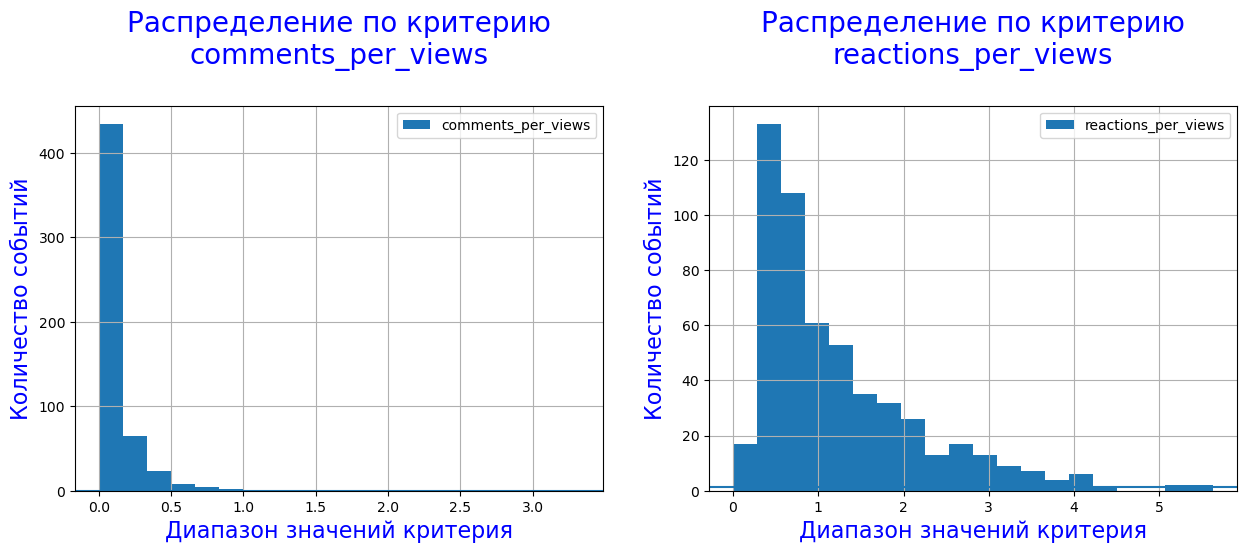

In [66]:
drow_hist('comments_per_views', 'reactions_per_views')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    
- обычно число комментариев составляет от 0,1 до 0,5% от просмотров   
    
- количество реакций ощутимо больше - до 3% от просмотров. Но все-же наиболее часто встречающаяся величина - это 0,5% от просмотров.
    

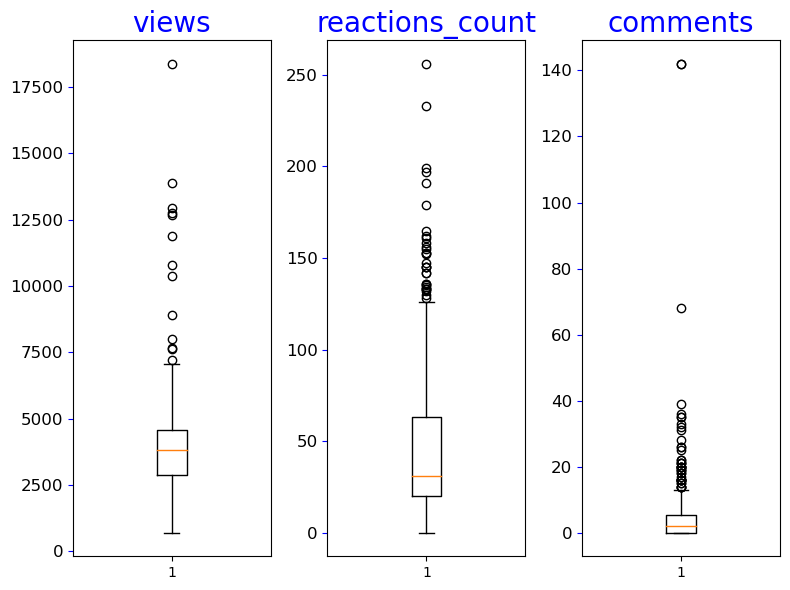

In [67]:
# построим ящики с усами
fig, axs = plt.subplots(1, len(innopolistg_emoji[['views', 'reactions_count', 'comments']].columns), figsize=(8,6))

for i, ax in enumerate (axs.flat):

    ax.boxplot(innopolistg_emoji[['views', 'reactions_count', 'comments']].iloc[:,i])
    ax.set_title(innopolistg_emoji[['views', 'reactions_count', 'comments']].columns[i], fontsize=20, color = "b")
    ax.tick_params(axis='y', labelsize=12, color = "b")

plt.tight_layout()
plt.savefig('picture_1.svg')

In [68]:
# Вычисление межквартального размаха
Q1 = innopolistg_emoji['reactions_count'].quantile(0.25)
Q3 = innopolistg_emoji['reactions_count'].quantile(0.75)
IQR = Q3 - Q1
print('Q1', Q1)
print('Q3', Q3)
print('IQR', IQR)

# Определение границ для выявления выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound', lower_bound)
print('upper_bound', upper_bound)

Q1 20.0
Q3 63.0
IQR 43.0
lower_bound -44.5
upper_bound 127.5


В среднем пост набирает 3800 просмотров, 31 реакцию и 2 комментария. Но как видно из графиков бывают и аномальные посты, набирающие гораздо большее число реакций.

Не откладывая на потом посмотрим, что это за публикации. Для анализа выведем распределение параметров в столбцах

In [69]:
round(innopolistg_emoji.describe())

id    views  reactions_count  comments  popular_word_count  \
count   539.0    539.0            539.0     539.0               539.0   
mean    689.0   3952.0             47.0       5.0                 2.0   
std     404.0   1658.0             40.0      11.0                 2.0   
min      21.0    702.0              0.0       0.0                 0.0   
25%     347.0   2880.0             20.0       0.0                 1.0   
50%     682.0   3819.0             31.0       2.0                 2.0   
75%    1028.0   4593.0             63.0       6.0                 3.0   
max    1421.0  18380.0            256.0     142.0                 9.0   

       simbols_in_text  words_in_text  avg_word_len  punct_marks  \
count            539.0          539.0         539.0        539.0   
mean             400.0           65.0           6.0         12.0   
std              328.0           44.0           2.0         17.0   
min                1.0            2.0           0.0          0.0   
25%              112.0           24.0           4.0          2.0   
50%              311.0           62.0           5.0          6.0   
75%              644.0           98.0           7.0         14.0   
max             1822.0          218.0          19.0         97.0   

       marks_per_text  popular_word_percent    year  month  weekday   hour  \
count           539.0                 539.0   539.0  539.0    539.0  539.0   
mean              inf                   3.0  2023.0    7.0      2.0   15.0   
std               NaN                   3.0     1.0    3.0      2.0    3.0   
min               1.0                   0.0  2022.0    1.0      0.0    0.0   
25%               5.0                   1.0  2022.0    5.0      1.0   12.0   
50%              10.0                   3.0  2023.0    7.0      2.0   15.0   
75%              22.0                   5.0  2023.0   10.0      3.0   17.0   
max               inf                  17.0  2023.0   12.0      6.0   22.0   

       days_cnt  comments_per_views  reactions_per_views  engagement_rate  
count     334.0               539.0                539.0            539.0  
mean        9.0                 0.0                  1.0              0.0  
std        34.0                 0.0                  1.0              0.0  
min         1.0                 0.0                  0.0              0.0  
25%         1.0                 0.0                  1.0              0.0  
50%         1.0                 0.0                  1.0              0.0  
75%         5.0                 0.0                  2.0              0.0  
max       453.0                 3.0                  6.0              3.0

In [70]:
len(innopolistg_emoji.loc[(innopolistg_emoji['marks_per_text'] == innopolistg_emoji.marks_per_text.max()), 'marks_per_text'] )

73

Обратим внимение, что в столбце `marks_per_text` максимальное значение принимает `inf` - бесконечность. То есть в таких строках не присутствуют иные, кроме точек, знаки препинания. Таких записей - 73.

In [71]:
innopolistg_emoji.query('views > 10000')

id                      date  \
36   1316 2023-10-25 12:05:19+00:00   
161   936 2023-06-07 16:17:56+00:00   
175   909 2023-05-25 14:45:01+00:00   
273   673 2023-01-16 16:33:54+00:00   
301   592 2022-12-10 10:02:21+00:00   
351   483 2022-11-02 16:50:19+00:00   
465   175 2022-06-09 09:02:09+00:00   
487   131 2022-05-24 16:28:38+00:00   

                                                  text    views  \
36   **В Иннополисе беспилотный автомобиль Яндекса ...  12690.0   
161  Долгожданный формат уютного дня города вернулс...  12953.0   
175  Динь-динь!\nЭто напоминание, что до Дня рожден...  10783.0   
273  Иннополис – город, который ведет дневник счаст...  10396.0   
301  [Университету Иннополис](https://t.me/universi...  18380.0   
351  В новом сезоне откроется история великого Дома...  12769.0   
465  Доброе утро, любимый город!\n\nСегодня у нас с...  13869.0   
487  Первый юбилей Иннополиса\n\n9 июня будет 10 ле...  11875.0   

     reactions_count  comments type_attachment  \
36               197        18    пост с видео   
161               94        39     пост с фото   
175              128        31     пост с фото   
273               92         6     пост с фото   
301              112        10     пост с фото   
351              101         8    пост с видео   
465               67         7    пост с видео   
487               72        16     пост с фото   

                                             reactions  \
36   {'_': 'MessageReactions', 'results': [{'_': 'R...   
161  {'_': 'MessageReactions', 'results': [{'_': 'R...   
175  {'_': 'MessageReactions', 'results': [{'_': 'R...   
273  {'_': 'MessageReactions', 'results': [{'_': 'R...   
301  {'_': 'MessageReactions', 'results': [{'_': 'R...   
351  {'_': 'MessageReactions', 'results': [{'_': 'R...   
465  {'_': 'MessageReactions', 'results': [{'_': 'R...   
487  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                    post_topic  popular_word_count  ...  year  month  weekday  \
36          События Иннополиса                   3  ...  2023     10        2   
161      Университет Иннополис                   1  ...  2023      6        2   
175      Университет Иннополис                   2  ...  2023      5        3   
273         События Иннополиса                   2  ...  2023      1        0   
301      Университет Иннополис                   4  ...  2022     12        5   
351                     Другое                   2  ...  2022     11        2   
465         События Иннополиса                   3  ...  2022      6        3   
487  Подборка новостных ссылок                   1  ...  2022      5        1   

     weekday_name  hour  times_of_day  days_cnt  comments_per_views  \
36      Wednesday    12          день      11.0               0.142   
161     Wednesday    16          день       3.0               0.301   
175      Thursday    14          день      13.0               0.287   
273        Monday    16          день       1.0               0.058   
301      Saturday    10          утро       1.0               0.054   
351     Wednesday    16          день       3.0               0.063   
465      Thursday     9          утро       1.0               0.050   
487       Tuesday    16          день      14.0               0.135   

     reactions_per_views engagement_rate  
36                 1.552          0.4240  
161                0.726          0.3860  
175                1.187          0.4670  
273                0.885          0.2234  
301                0.609          0.1650  
351                0.791          0.2086  
465                0.483          0.1366  
487                0.606          0.2292  

[8 rows x 26 columns]

In [72]:
print('\033[92m''Содержание выбранных публикаций')
innopolistg_emoji.loc[(innopolistg_emoji['views'] > 10000), 'text'].tolist()

Содержание выбранных публикаций


['**В Иннополисе беспилотный автомобиль Яндекса впервые проехал без человека в салоне**\n\nМашина преодолела 50 километров по городу без водителя-испытателя. Это начало финального этапа тестирования — поездок без специалиста в автомобиле. Для безопасности беспилотник сопровождала другая машина с оператором. Такие испытания стали первыми в Европе.\n\nТестирование беспилотных машин Яндекса началось в 2018 году в Иннополисе при поддержке и личном участии Раиса РТ Минниханова Рустама Нургалиевича. Сейчас роботакси ездит с водителем на пассажирском сиденье. Они уже совершили 77 тысяч поездок и преодолели 1 миллион километров.',
 'Долгожданный формат уютного дня города вернулся, а [программу впервые формировали сами жители](https://t.me/innoginarium). Собрали информацию о празднике. \n\nВстречаемся 9 июня на площади Университета 🤗',
 'Динь-динь!\nЭто напоминание, что до Дня рождения Иннополиса осталось 15 дней 😍\n\nВ этом году программу впервые формировали сами жители. И вот, что у вас получ

Восемь постов с количеством просмотров  более 1000.  
- Темы постов - Университет Иннополис (4), События Иннополиса (2), Подборка новостныз ссылок и Другое.  
- Количество символов в тексте, знаков препинания - в пределах нормальных значений

Что в содержании постов?
- Все они посвящены жизни города, а половина из них проведению праздника города.

Таким образом, столь большое количество просмотров является следствием удачно построенного поста и не вызывает необходимости удаления как аномального значения



In [73]:
innopolistg_emoji.query('reactions_count > 170')

id                      date  \
11   1382 2023-11-24 15:02:12+00:00   
16   1376 2023-11-21 18:27:12+00:00   
36   1316 2023-10-25 12:05:19+00:00   
84   1189 2023-09-07 17:49:02+00:00   
142  1005 2023-06-30 16:10:43+00:00   
198   840 2023-04-20 14:35:49+00:00   

                                                  text    views  \
11   Семь фотографий — семь лет, как Руслан Ринатов...   3533.0   
16   Красивый заснеженный Иннополис глазами нашего ...   5011.0   
36   **В Иннополисе беспилотный автомобиль Яндекса ...  12690.0   
84   Твой обычный вид из окна в Иннополисе\n\nФото:...   4836.0   
142  Иннополис в деталях 💟\n\nКусочки футуристическ...   4526.0   
198  Вот что бывает, когда пешком до школы идти 10 ...   5820.0   

     reactions_count  comments type_attachment  \
11               199         6     пост с фото   
16               256        20    пост с видео   
36               197        18    пост с видео   
84               179         5     пост с фото   
142              191        12     пост с фото   
198              233         9    пост с видео   

                                             reactions          post_topic  \
11   {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   
16   {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   
36   {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   
84   {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   
142  {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   
198  {'_': 'MessageReactions', 'results': [{'_': 'R...              Другое   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
11                    0  ...  2023     11        4        Friday    15   
16                    0  ...  2023     11        1       Tuesday    18   
36                    3  ...  2023     10        2     Wednesday    12   
84                    0  ...  2023      9        3      Thursday    17   
142                   1  ...  2023      6        4        Friday    16   
198                   0  ...  2023      4        3      Thursday    14   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
11           день       3.0               0.170                5.633   
16          вечер       1.0               0.399                5.109   
36           день      11.0               0.142                1.552   
84           день       1.0               0.103                3.701   
142          день       3.0               0.265                4.220   
198          день       2.0               0.155                4.003   

    engagement_rate  
11           1.2626  
16           1.3410  
36           0.4240  
84           0.8226  
142          1.0560  
198          0.9246  

[6 rows x 26 columns]

In [74]:
print('\033[92m''Содержание выбранных публикаций')
innopolistg_emoji.loc[(innopolistg_emoji['reactions_count'] > 170), 'text'].tolist()

Содержание выбранных публикаций


['Семь фотографий — семь лет, как Руслан Ринатович Шагалеев развивает Иннополис в должности мэра Иннополиса 💛',
 'Красивый заснеженный Иннополис глазами нашего жителя @Insaf_air',
 '**В Иннополисе беспилотный автомобиль Яндекса впервые проехал без человека в салоне**\n\nМашина преодолела 50 километров по городу без водителя-испытателя. Это начало финального этапа тестирования — поездок без специалиста в автомобиле. Для безопасности беспилотник сопровождала другая машина с оператором. Такие испытания стали первыми в Европе.\n\nТестирование беспилотных машин Яндекса началось в 2018 году в Иннополисе при поддержке и личном участии Раиса РТ Минниханова Рустама Нургалиевича. Сейчас роботакси ездит с водителем на пассажирском сиденье. Они уже совершили 77 тысяч поездок и преодолели 1 миллион километров.',
 'Твой обычный вид из окна в Иннополисе\n\nФото: @kaskar2008',
 'Иннополис в деталях 💟\n\nКусочки футуристического пазла города глазами нашего арт-директора Фархада Загидуллина',
 'Вот что 

Шесть постов с количеством реакций более 170.  
- Темы постов - Другое и События Иннополиса.  
- пять постов - короткие, количество символов менее 100- это первый квартиль
- Количество знаков препинания в публикации (кроме точки) - маленькое - 1-2. то есть это простой для чтения текст  
- Время жизни поста с id=781 - 48 дней = это , предположим, много.

Что в содержании постов?
- пять постов - это фотографии. Практически без текста.
- один пост - видео о беспилотном автомобиле. Наврняка многи посмотрели это видео не один раз.

Таким образом, столь большое количество реакций является следствием удачно построенного поста и не вызывает необходимости удаления как аномального значения



In [75]:
innopolistg_emoji.query('comments > 60')

id                      date  \
170  915 2023-05-29 17:46:11+00:00   
230  781 2023-03-14 15:50:01+00:00   
463  177 2022-06-09 15:01:39+00:00   

                                                  text   views  \
170  О классной фиче [нашего сайта](https://innopol...  4716.0   
230  Достаём двойные листочки. В день математики пр...  4283.0   
463  Сохраняй эти карточки о сегодняшнем празднике,...  4273.0   

     reactions_count  comments type_attachment  \
170               65       142     пост с фото   
230               53        68     пост с фото   
463               40       142     пост с фото   

                                             reactions           post_topic  \
170  {'_': 'MessageReactions', 'results': [{'_': 'R...   События Иннополиса   
230  {'_': 'MessageReactions', 'results': [{'_': 'R...  Работа в Иннополисе   
463  {'_': 'MessageReactions', 'results': [{'_': 'R...               Другое   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
170                   1  ...  2023      5        0        Monday    17   
230                   1  ...  2023      3        1       Tuesday    15   
463                   1  ...  2022      6        3      Thursday    15   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
170          день       3.0               3.011                1.378   
230          день      48.0               1.588                1.237   
463          день       4.0               3.323                0.936   

    engagement_rate  
170          2.6844  
230          1.5178  
463          2.8456  

[3 rows x 26 columns]

In [76]:
print('\033[92m''Содержание выбранных публикаций')
innopolistg_emoji.loc[(innopolistg_emoji['comments'] > 60), 'text'].tolist()

Содержание выбранных публикаций


['О классной фиче [нашего сайта](https://innopolis.ru/ru) \n\nКаждый месяц мы собираем лучшие снимки Иннополиса от жителей и выставляем их на главной странице сайта города.\n\nСейчас делаем подборку на июнь. Присылай фотографии в комментарии — самые клёвые заберём на сайт ☺️',
 'Достаём двойные листочки. В день математики приготовили для тебя небольшую проверочную работу. \n\nОтвет присылай в комментарии ⬇️',
 'Сохраняй эти карточки о сегодняшнем празднике, они тебе ещё пригодятся']

Три поста с количеством комментариев более 60.  
- Темы постов - Другое и События Иннополиса.  
- Количество знаков препинания в публикации (кроме точки) - с большим разбросом. Один пост содержит толлько простые предложения, буз знаков препинания.
- Время жизни поста с id=781 - 48 дней = это , предположим, много.

Что в содержании постов?
- первые два (из рассматриваемых) - предполагают обратный комментарий - призывы присылать фотографии и ответы с решениями
- третий пост - фотографии с городского праздника. Вероятно, читатели оставляли комментарии о проведённом празднике.

Таким образом, столь большое количество комментарием является следствием удачно построенного поста и не вызывает необходимости удаления как аномального значения



<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    Таким образом, мы не выявили необходимости удаления записей с аномальными значениями

### Зависимость популярности поста от времени его публикации.
Определим зависимость популярности публикации от месяца, день недели и время суток публикации (утро, день, вечер, ночь).  
Популярность примет значения:
- `comments_per_views` (отношение количества комментариев к количеству просмотров поста)
- `reactions_per_views` (отношение количества комментариев к количеству просмотров поста)

Ранее, при рассмотрении аномальных значений, мы установили, что аномальные значения являются выражением заинтересованности и популярности поста. По этой причине при построении диаграммы и анализе мы будем рассматривать средние, а не медианные значения.


#### Матрица корреляции

Для начала рассмотрим значения коэффициентов корреляции.  
Создадим функцию `coef_corr`, которая построит нам матрицу корреляции

In [77]:
def coef_corr(list_name):
    # зададим матрицу корреляции
    df_corr = innopolistg_emoji[list_name].corr()

    # построим матрицу
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(df_corr, fmt='.0%', annot = True, cmap="vlag")
    plt.title('Матрица корреляции\n', color = 'b', fontsize = 26)
    plt.xticks(rotation=90, fontsize=14, color = "b")
    plt.yticks(rotation=0, fontsize=14, color = "b")

Создадим список `catalog_by_time`, в который поместим наименования интересующих нас столбцов

In [78]:
#Зависимость реакций и времени жизни  от времени публикации
catalog_by_time = [
'views',
 'comments',
 'comments_per_views',
 'reactions_count',
 'reactions_per_views',
 'engagement_rate',
 'days_cnt',

  'year',
 'month',
 'weekday',
 'hour',
 'times_of_day'
]

In [79]:
def coef_corr(list_name):
    # зададим матрицу корреляции
    # возьмем только столбцы с числовыми значениями:
    df_corr = innopolistg_emoji[list_name].corr(numeric_only=True)

    # построим матрицу
    fig, ax = plt.subplots(figsize=(15,8))
    sns.heatmap(df_corr, fmt='.0%', annot = True, cmap="vlag")
    plt.title('Матрица корреляции\n', color = 'b', fontsize = 26)
    plt.xticks(rotation=90, fontsize=14, color = "b")
    plt.yticks(rotation=0, fontsize=14, color = "b")

Построим матрицу

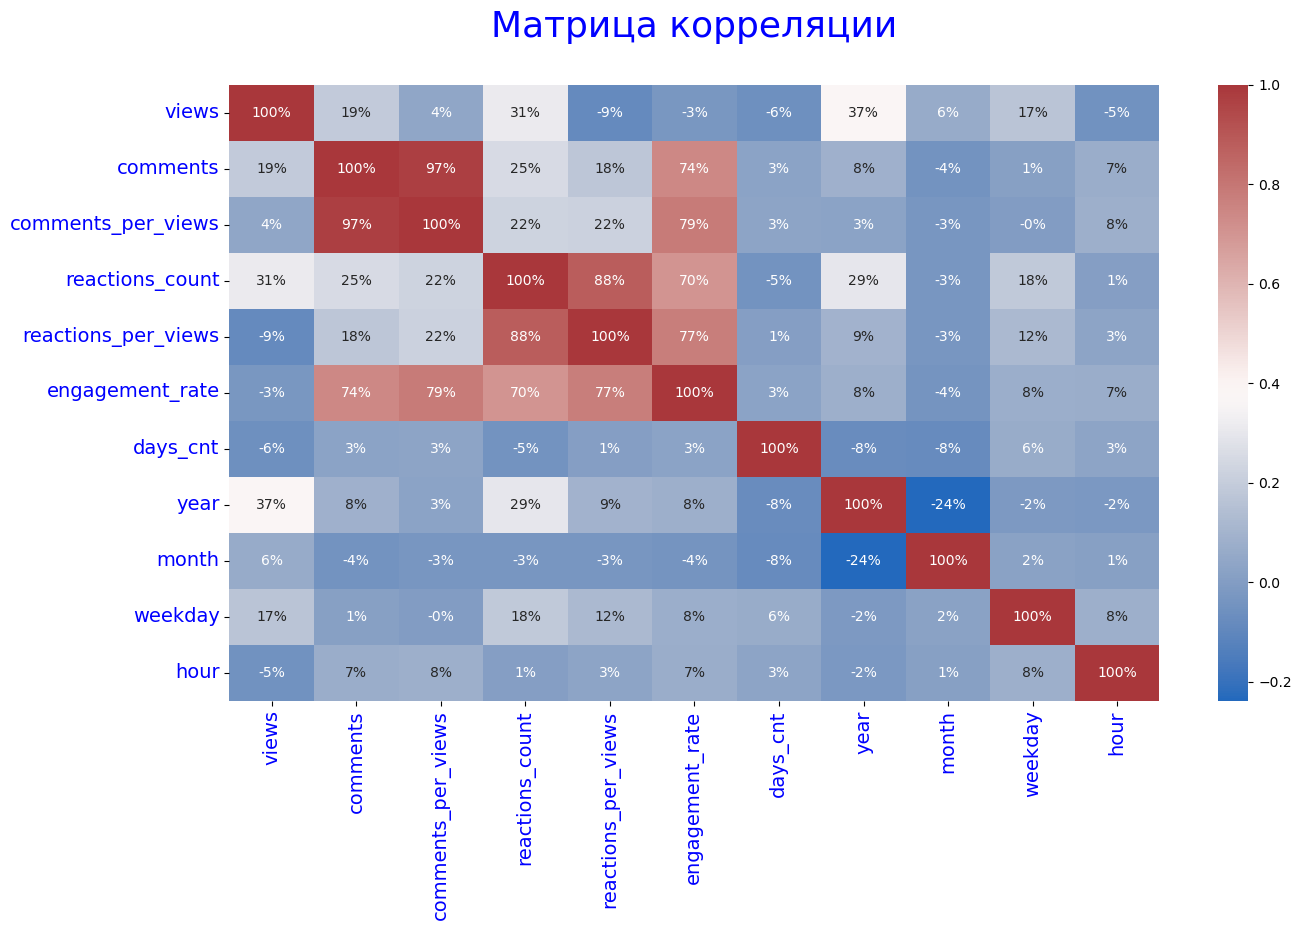

In [80]:
coef_corr(catalog_by_time)

Мы не видим в матрице сколь-либо значимых зависимостей популярности постов от месяца публикации и часа публикации поста.  
Существует зависимость от года - но это вполне объяснимо развитием канала.  
А вот не отметить зависимость от дня недели публикации мы не можем. Количество просмотров, реакций и коэффициент вовлеченности имеют пусть небольшую, но все-же зависимость от дня недели публикации. Исследуем это далее.

 #### Подготовим инструменты и данные
 Создадим функции:
 - `event_in_time_plot` - для построения линейного графика. Для сглаживания шумов применим скользящее среднее
 - `event_in_time_bar`- для построения столбчатой диаграммы
 - `event_in_time_bar_year` - для построения столбчатой диаграммы с учетом в продажах года

In [81]:
# строим график, отражающий количество событий в зависимости от времени
# для сглаживания шумов применим скользящее среднее
def event_in_time_plot(data_name, eventname, time_interval):
    t1 = data_name.groupby(time_interval).agg({eventname:'median'}).sort_values(time_interval)

    ax1 = t1.rolling(90).mean().plot(grid=True
        , figsize=(25,10)
        ,  color='b')

    plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=28, color = "b")
    plt.legend(fontsize=18, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=0, fontsize=20, color = "b")
    plt.yticks(rotation=0, fontsize=20, color = "b")
    plt.xlabel('Дата', fontsize=20, color = "b")
    plt.ylabel(f"Количество событий {eventname}", fontsize=20, color = "b")
    #plt.show()
    return

In [82]:
# строим столбчатую диаграмму, отражающую количество событий в зависимости от времени
def event_in_time_bar_year(data_name, eventname, time_interval, operation):
    t1 = data_name.groupby(['year', time_interval]).agg({eventname:operation})#.sort_values(time_interval)

    ax = t1.plot(figsize=(25,10),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7,
    label='Временной отрезок: '+ time_interval
    )

    plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=28, color = "b")
    plt.legend(fontsize=18, bbox_to_anchor=(0.8, 1))
    plt.xticks(rotation=90, fontsize=20, color = "b")
    plt.yticks(rotation=0, fontsize=20, color = "b")
    plt.xlabel('Дата', fontsize=20, color = "b")
    plt.ylabel(f"Количество событий {eventname}", fontsize=20, color = "b")

    return

In [83]:
# строим столбчатую диаграмму, отражающую количество событий в зависимости от времени
def event_in_time_bar(data_name, eventname, time_interval, operation, ax):
    t1 = data_name.groupby(time_interval).agg({eventname:operation})#.sort_values(time_interval)

    ax = t1.plot(figsize=(25,10),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7,
    label='Временной отрезок: '+ time_interval,
    ax=ax
    )

    plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=28, color = "b")
    plt.legend(fontsize=18, bbox_to_anchor=(0.8, 1))
    plt.xticks(rotation=0, fontsize=20, color = "b")
    plt.yticks(rotation=0, fontsize=20, color = "b")
    plt.xlabel(f'{time_interval}', fontsize=20, color = "b")
    plt.ylabel(f"Количество событий {eventname}", fontsize=20, color = "b")

    return

#### Распределение коэффициента вовлеченности по месяцам на всем временном промежутке
Построим линейные графики распределения коэффициента вовлеченностина временном промежутке, предоставленном в датафрейме. Для сглаживания шумов применим скользящее среднее в размере 90 дней.


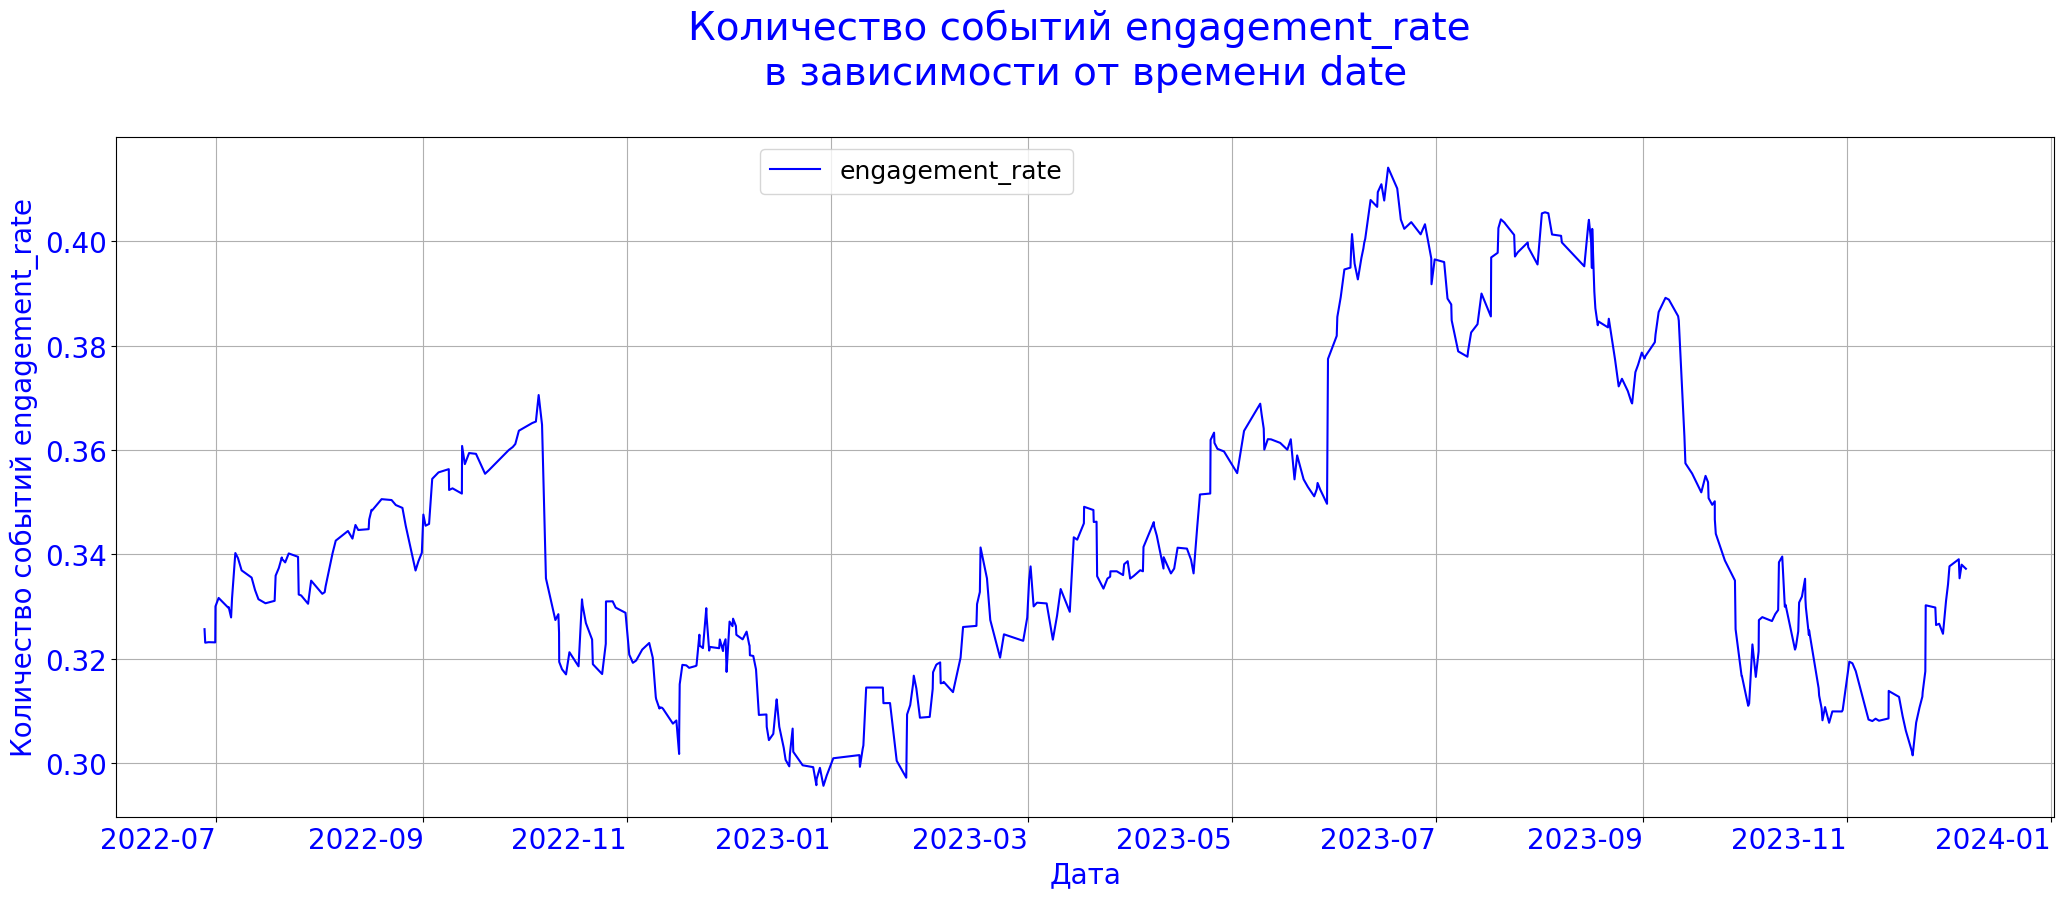

In [84]:
event_in_time_plot(innopolistg_emoji,  'engagement_rate', 'date')

Построим столбчатую диаграмму распределения относительного количества комментариев и реакций на временном промежутке, предоставленном в датафрейме.  


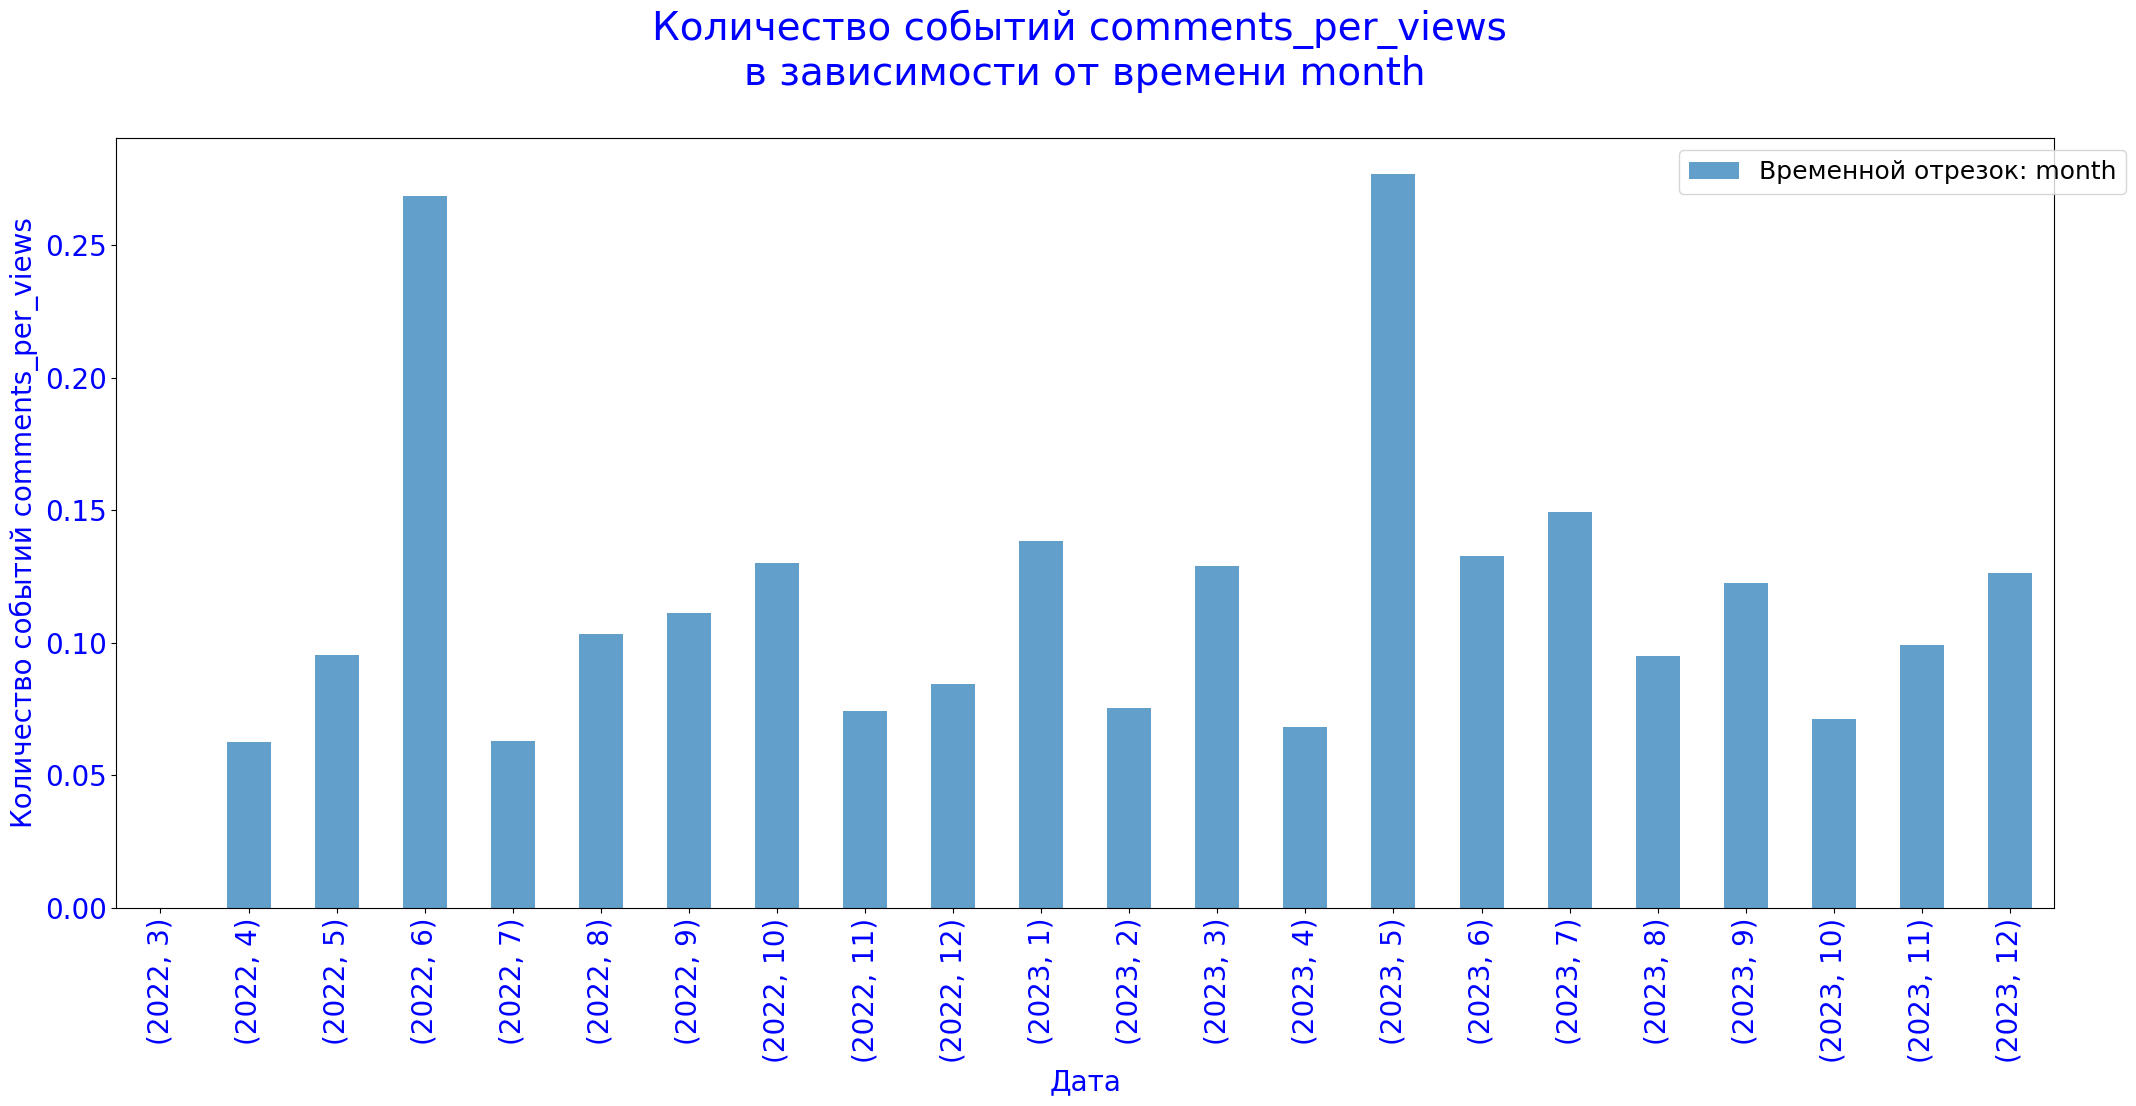

In [85]:
event_in_time_bar_year(innopolistg_emoji, 'comments_per_views', 'month', 'mean')

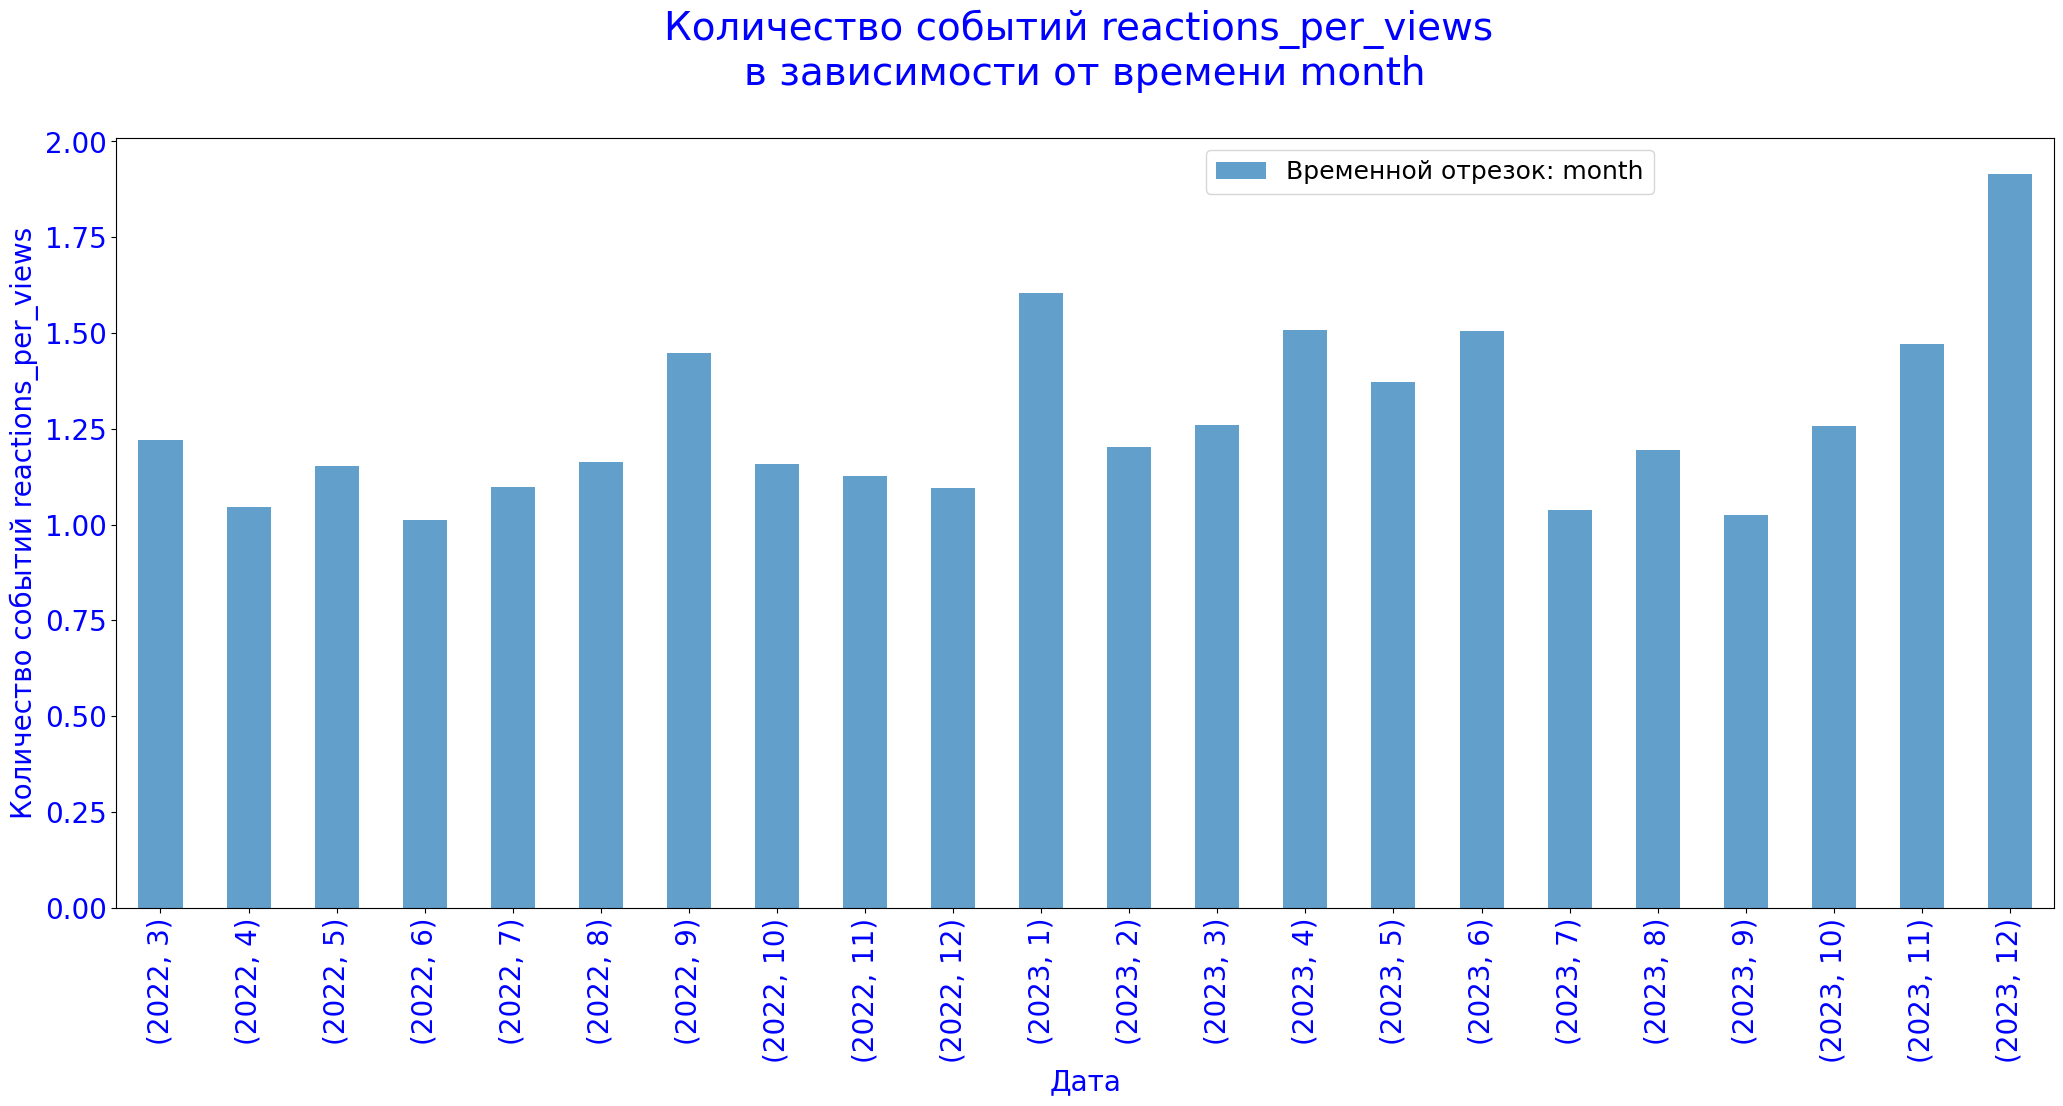

In [86]:
event_in_time_bar_year(innopolistg_emoji, 'reactions_per_views', 'month', 'mean')

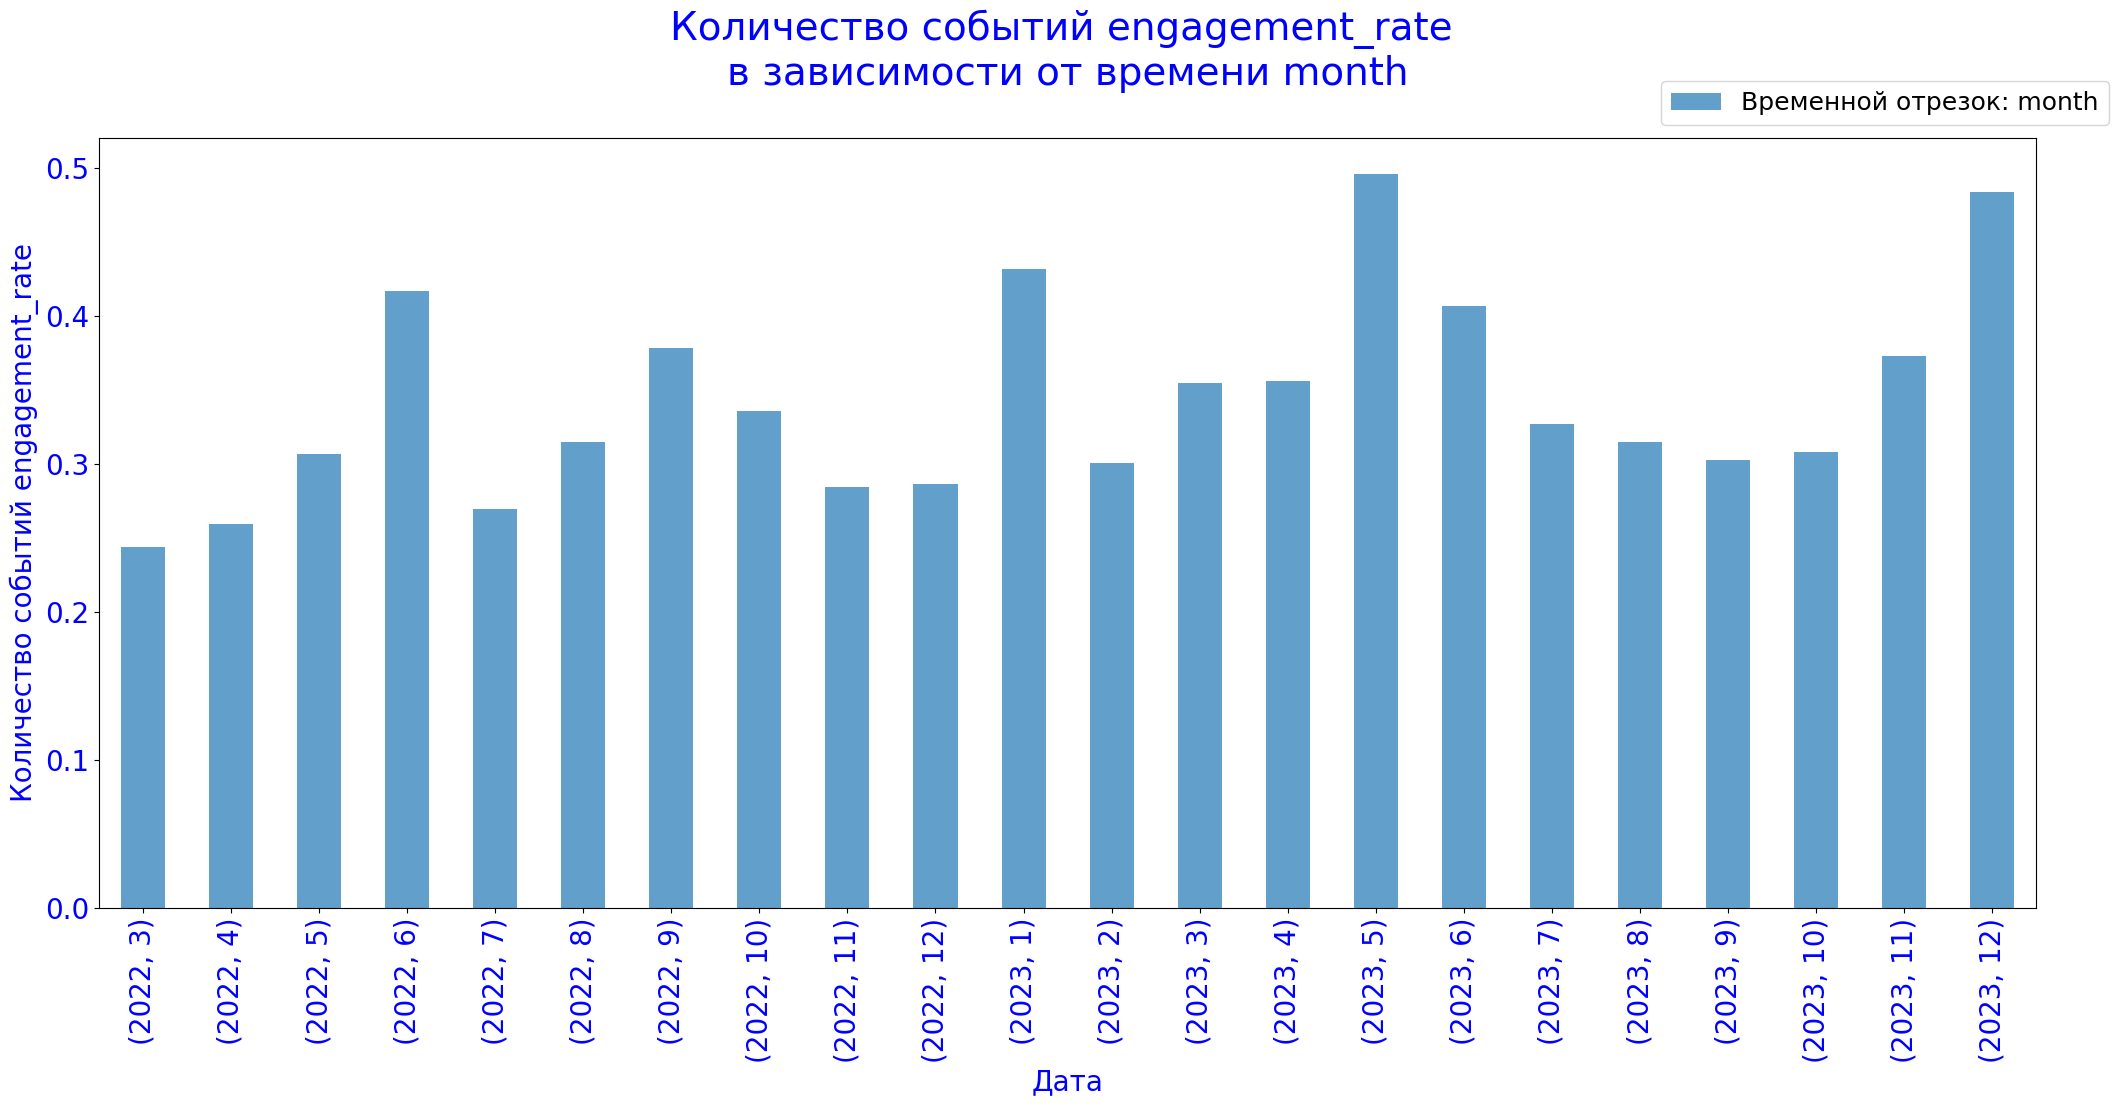

In [87]:
event_in_time_bar_year(innopolistg_emoji, 'engagement_rate', 'month', 'mean')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">

- Количество коментариев к количеству просмотров как правило изменяется в сравнительно небольшом диапазоне от 0,05 до 0,2 процента. **Всплески выражены в июне 2022 и мае-июне 2023 года.**
- Количество реакций к количеству просмотров имеет довольно значительную амплитуду колебания диапазоне от 0,8 до 1,8 процента. Особенно заметны взлета и падения на протяжении всего 2023 года   
    - месяцы с увеличением числа реакций не совпадают с месяцами роста для комментариев. Видим, что читатели эмоционально реагировали в новогоднае праздники и летом 2023 года

<div style="border-radius: 45px; border:solid green 14px; padding: 40px">

- Мы рассматриваем коэффициент вовлеченности как метрику популярности канала
   
    - активность читателей не имеет тенденции к постоянному росту
    - активность читательских комментариев и реакций растет в летние месяцы и новогодние праздники

#### Как изменялась аудитория и ее реакции от года к году и от месяца к месяцу

Соберем переменную `final_v`

In [88]:
warnings.filterwarnings("ignore")
v1 = innopolistg_emoji[['id', 'year','month', 'views']]
v2 = innopolistg_emoji[['id', 'year','month', 'reactions_count']]
v2['reactions_count'] = v2['reactions_count'] *50
v3 = innopolistg_emoji[['id', 'year','month', 'comments']]
v3['comments'] = v3['comments'] * 250

In [89]:
warnings.filterwarnings("ignore")
v1['mark'] = 'views'
v2['mark'] = 'reactions'
v3['mark'] = 'comments'

In [90]:
v1.columns = ['id', 'year','month','count', 'mark']
v2.columns = ['id', 'year','month','count', 'mark']
v3.columns = ['id', 'year','month','count', 'mark']

In [91]:
final_v = pd.concat([v1, v2, v3]).reset_index(drop=True)

In [92]:
# строим групповую столбчатую диаграмму
def year_to_year(time_period):
    sns.set(rc={"figure.figsize":(15, 8)})
    sns.barplot(x=(time_period), y='count', hue='mark',  data=final_v)
    plt.title('Количество событий \n в зависимости от времени\n в разрезе групп'.format('date'), fontsize=20, color = "b")
    plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
    plt.xticks(rotation=90, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    plt.xlabel('Дата', fontsize=14, color = "b")
    plt.ylabel("Количество событий \n", fontsize=14, color = "b")
    plt.grid(which='major', axis='y')

    #plt.show()

Для удобства восприятия значения реакций `reactions_count` умножены на 50, а значения комментриев `comments` умножены на 250  

выведем данные за 2022 и 2023 годы

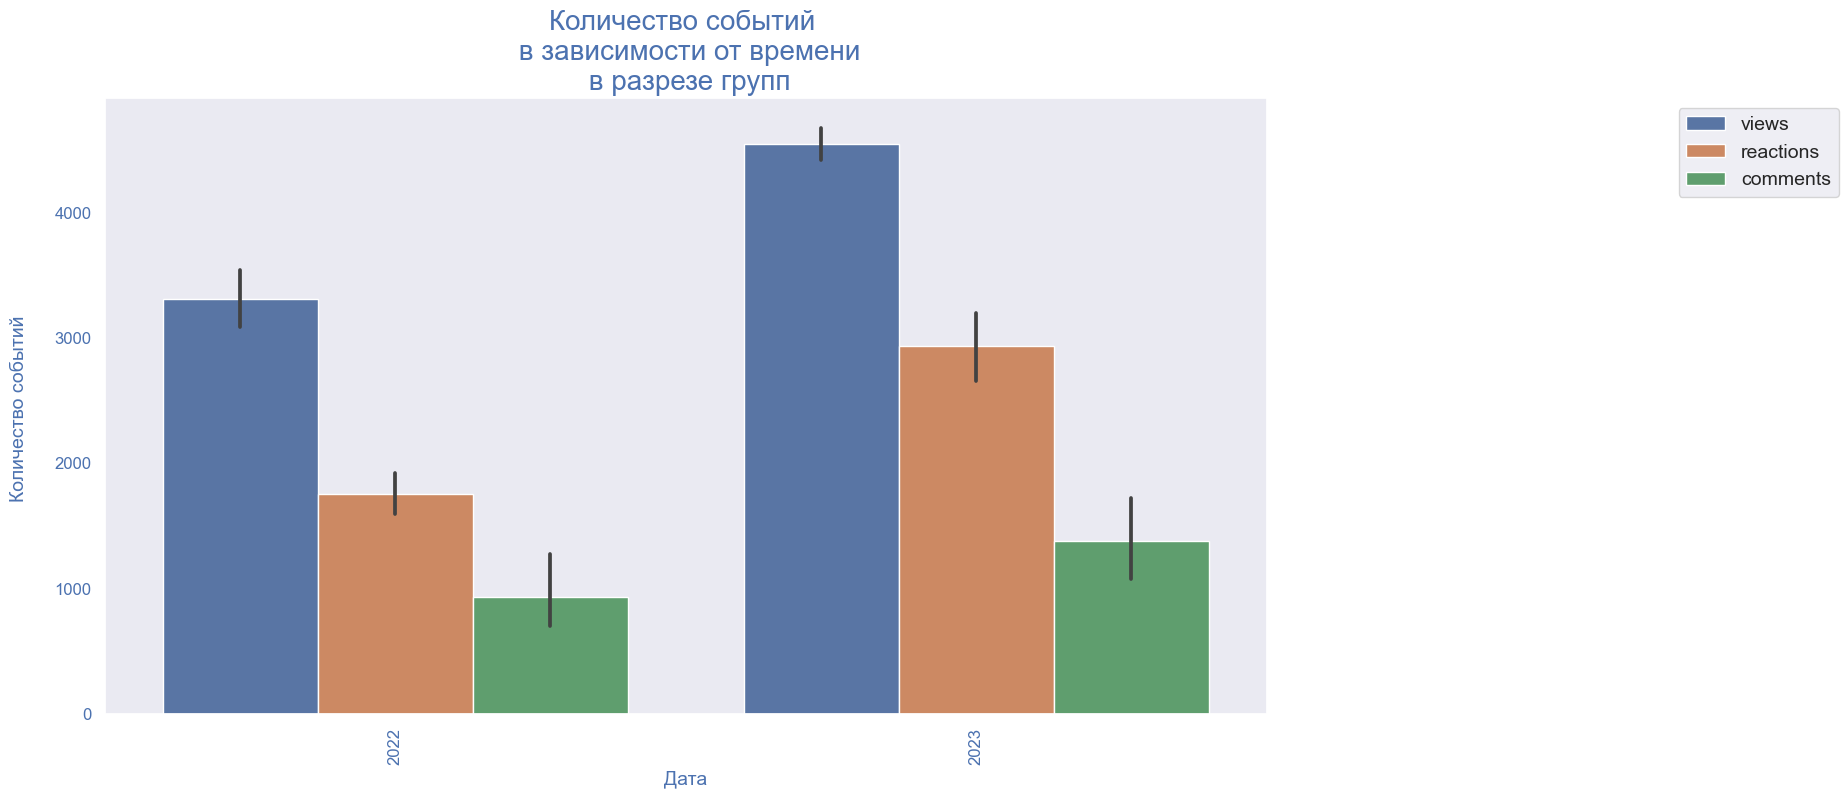

In [93]:
year_to_year('year')

Выведем данные за 2023 год в разрезе месяцев

In [94]:
final_v = final_v.query('year == 2023')

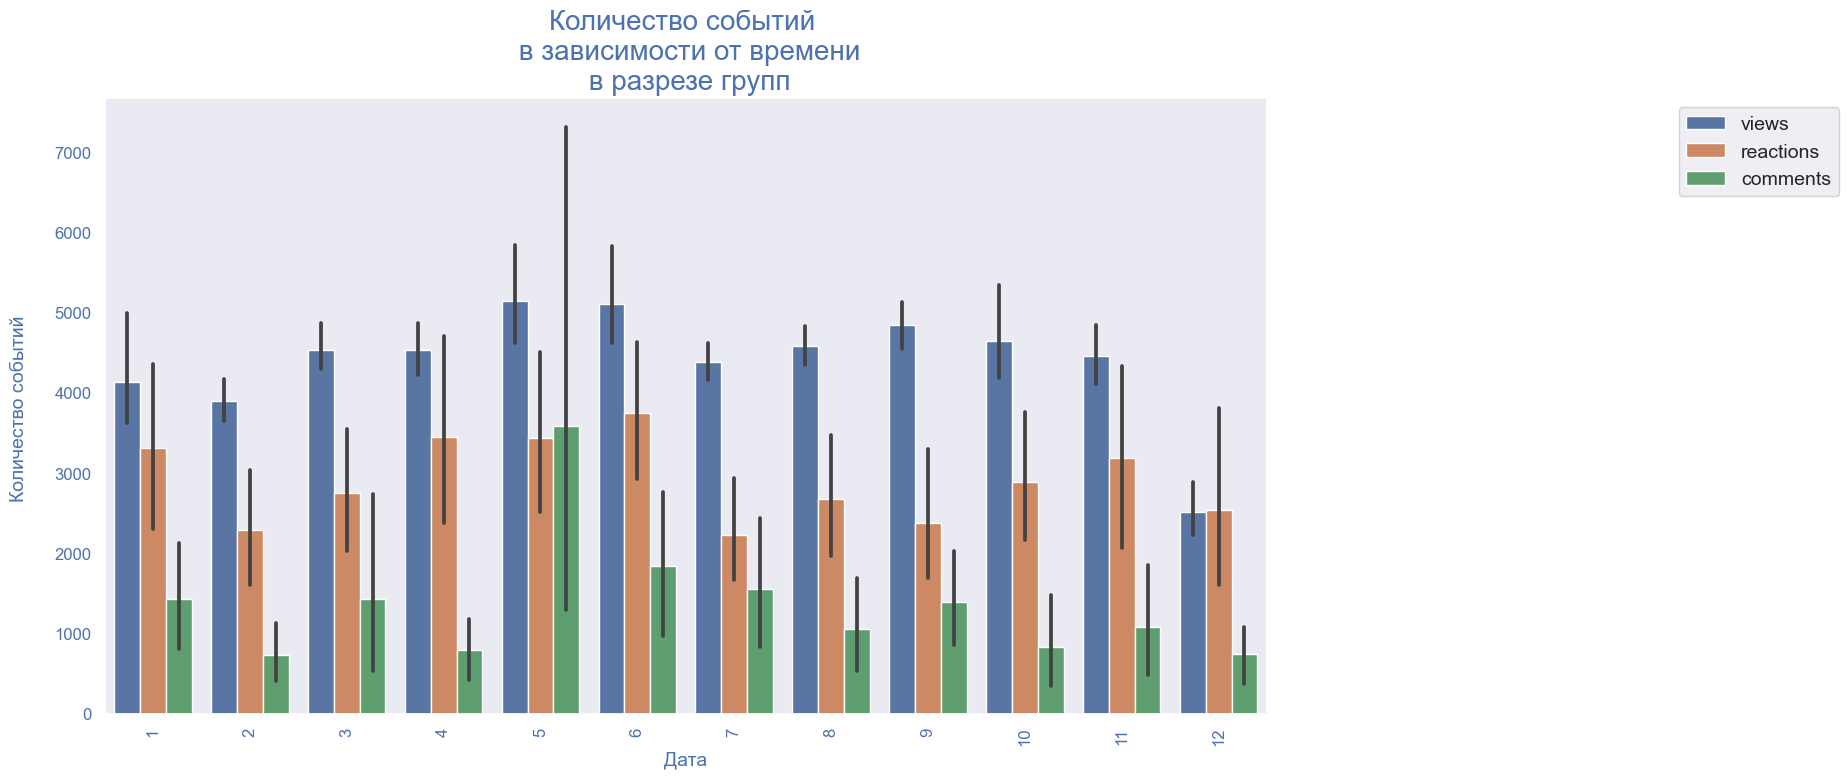

In [95]:
year_to_year('month')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    
- Мы можем сказать, что аудитория канала возросла от года к году.
    
- довольно пропорционально возросло количество комментариев и реакций  
    
- в 2023 году количество просмотров имеет две зоны роста и две зоны падения.  
    
- изменение количества реакций и комментариев не повторяет динамику изменения количества просмотров.  
    
- а динамика комментариев в свою очередь отличается от динамики реакций

#### Распределение популярности постов по времени суток и по дням недели
Создадим небольшую функцию `dist_in_time`, которая построит нам графики в зависимости от дня недели или времени суток

In [96]:
def dist_in_time(value, step):
# задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

# в первой ячейке строим распределение по группе количеству заказов
    ax1 = plt.subplot(1, 2, 1)
# вызываем функцию
    event_in_time_bar(innopolistg_emoji, 'comments_per_views', value, step, ax1)

# во второй ячейке строим распределение по количеству покупателей
    ax2 = plt.subplot(1, 2, 2)
# вызываем функцию
    event_in_time_bar(innopolistg_emoji, 'reactions_per_views', value, step, ax2)


    return

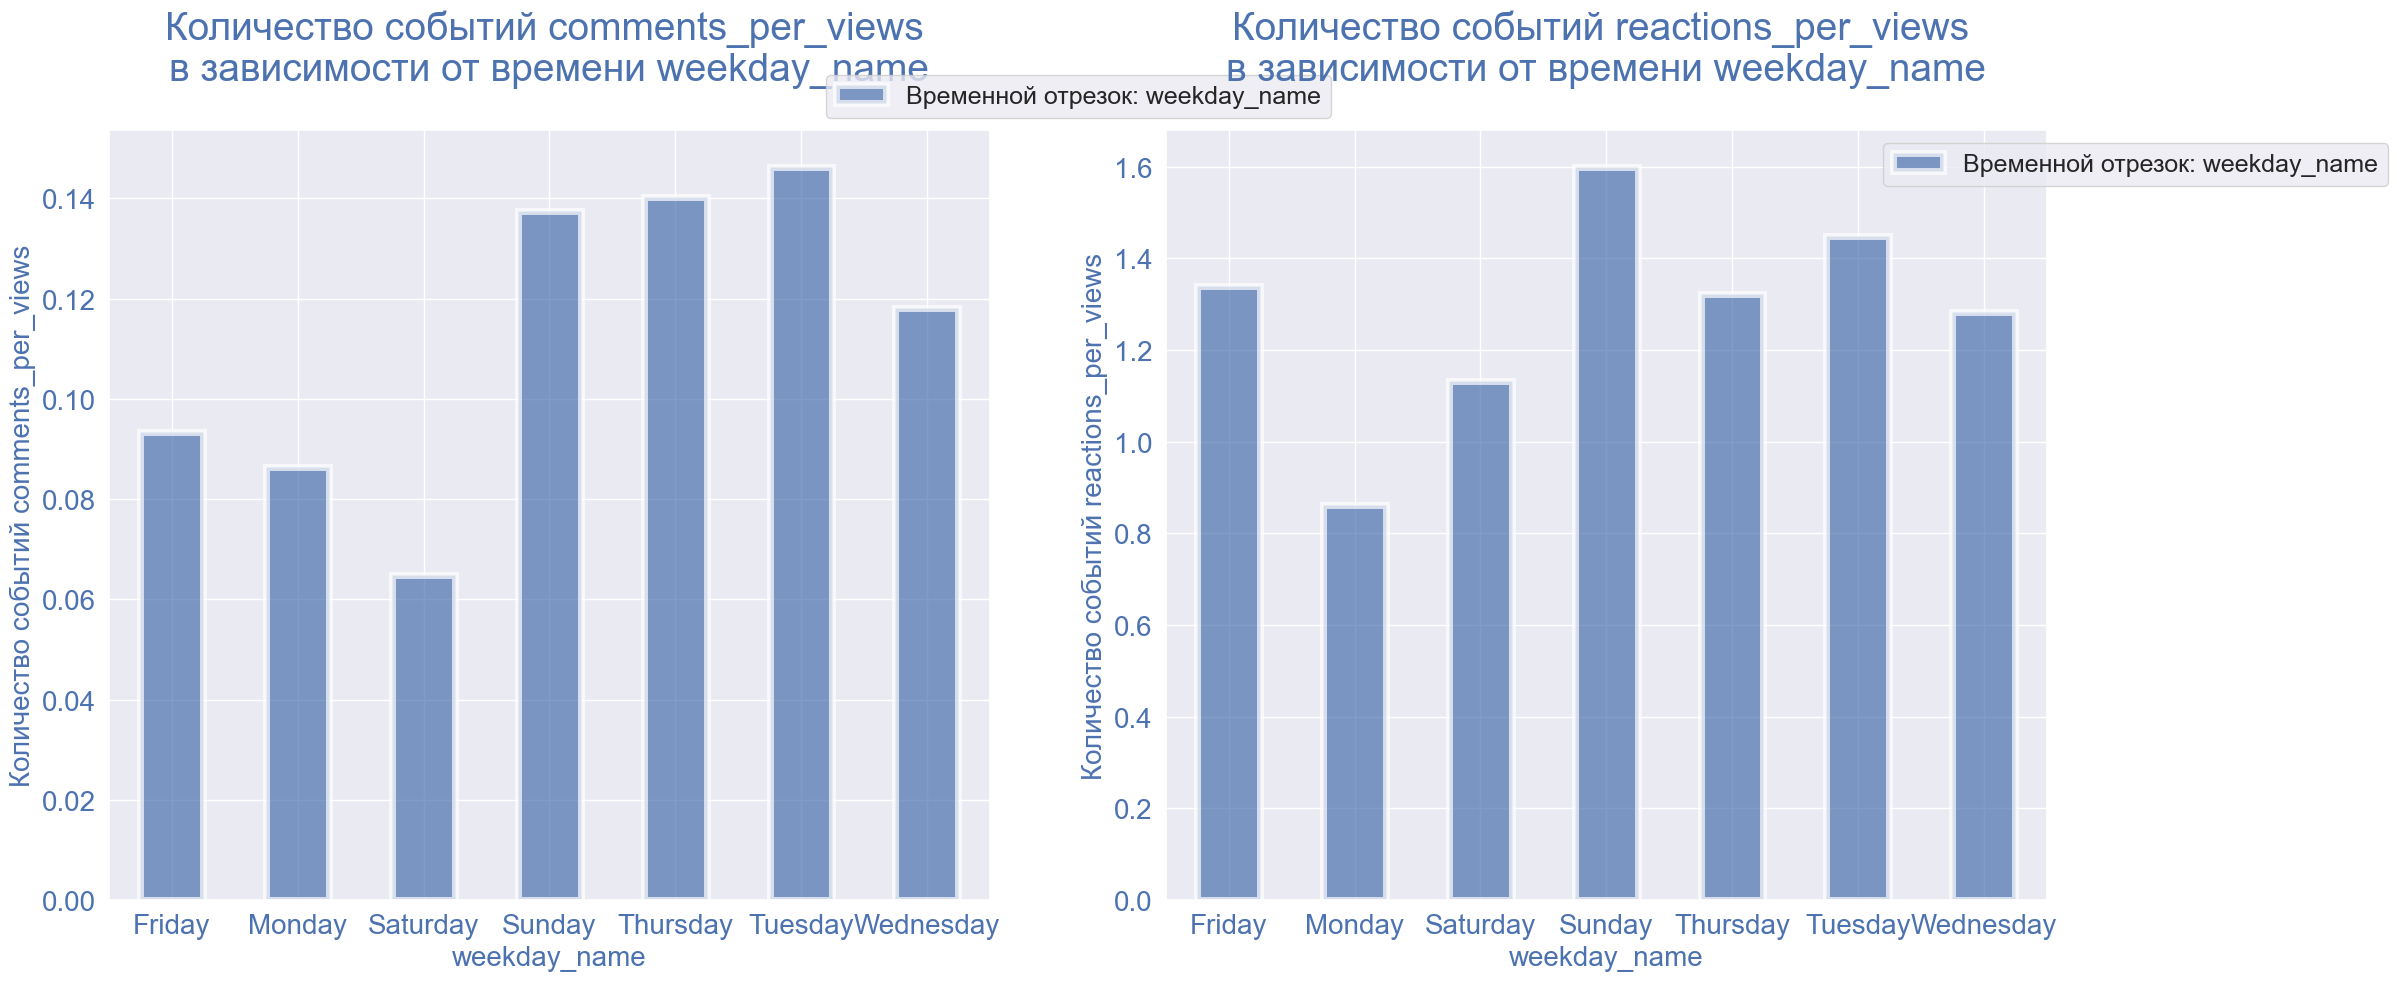

In [97]:
dist_in_time('weekday_name', 'mean')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    
- Читатели наиболее активно комментрую посты, вышедшие во вторник, четверг и воскресенье
    
- меньше всего комментариев к постам, вышедшим в субботу
    
- реакции читателе не совсем совпадают с количеством комментариев.  
    
- наибольшее количество реакций приходится на посты, опубликованные во вторник и воскресенье.
    
- наименьшее количество - на посты, опубликованные на понедельник.
    
    Напомним, что даты здесь - это даты выхода поста (а не дата простановки комментария или реакции)

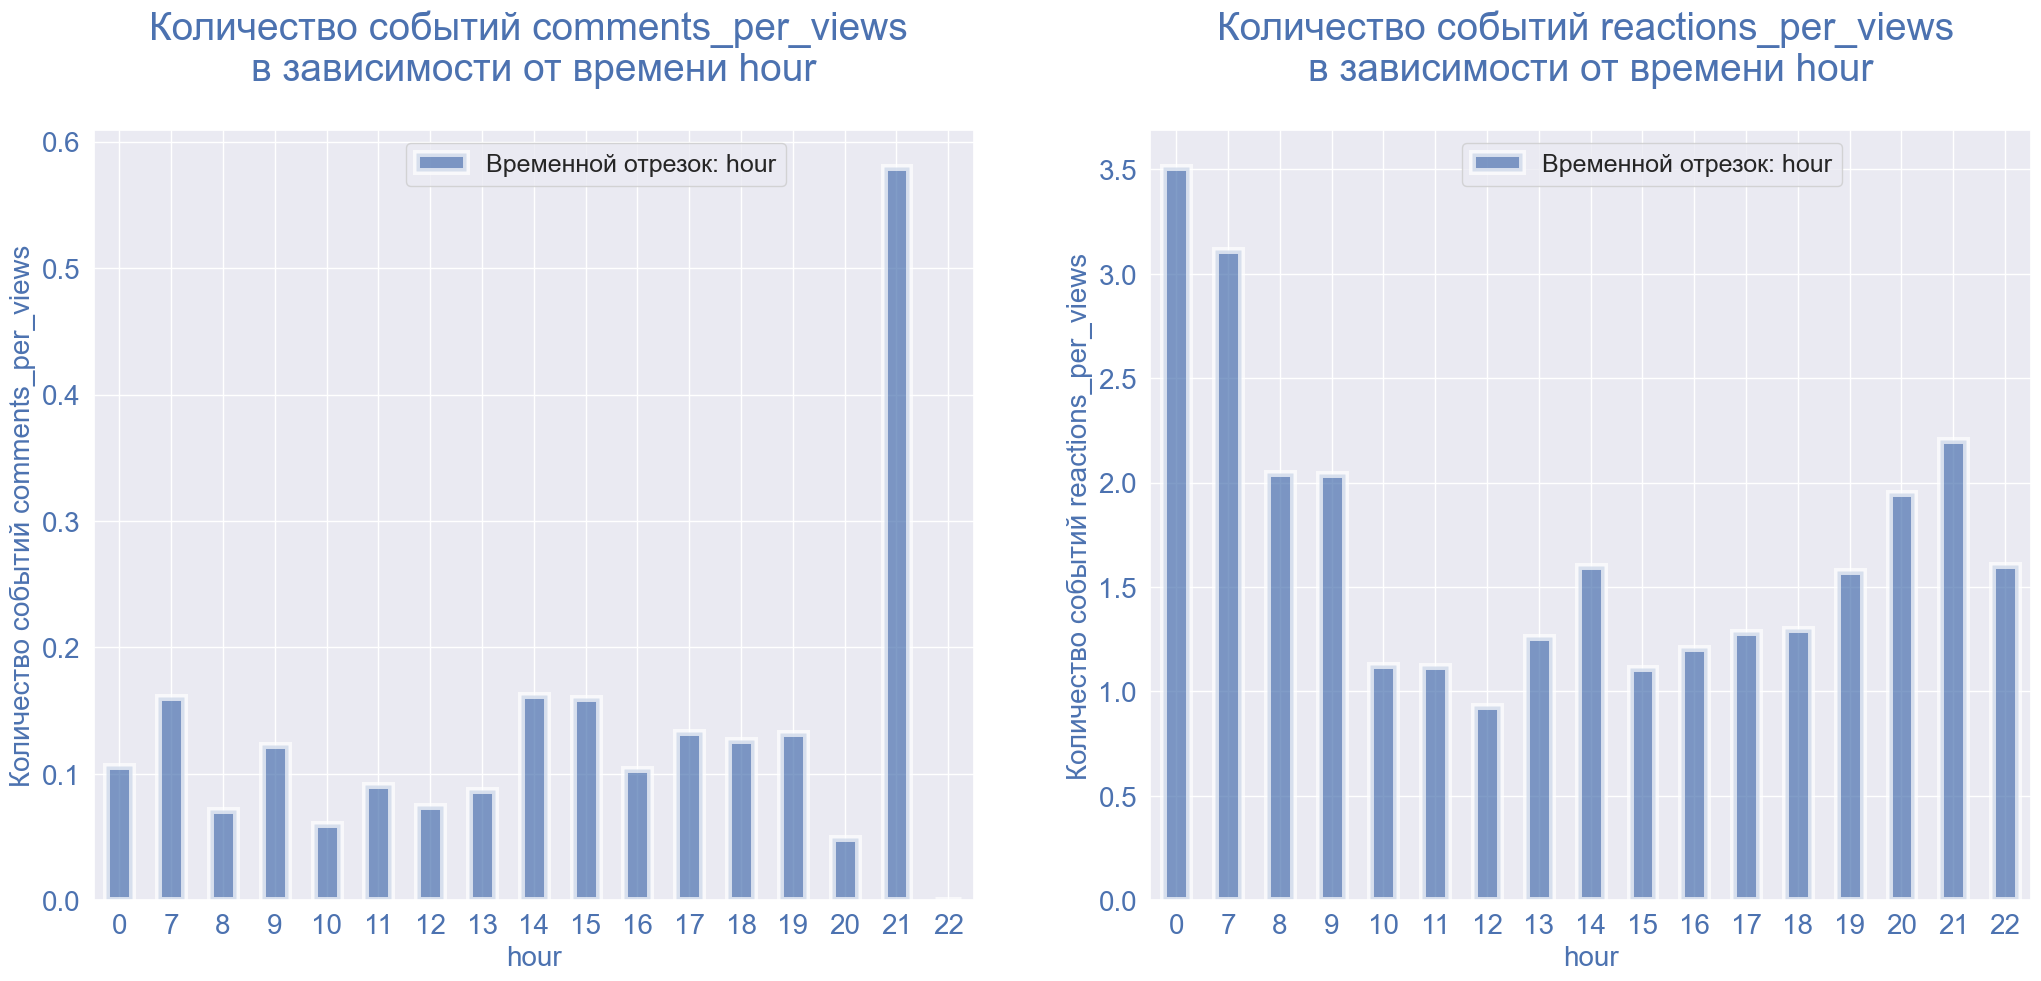

In [98]:
dist_in_time('hour', 'mean')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    
- Читатели наиболее активно, с большим отрывом, комментрую посты, вышедшие в 21 час
    
- и совсем не комментируют посты, вышедшие в 22 и 23  часов и в промежутоке с 1 часа до 4 часов. Наиболее вероятно, что в указанное время посты просто не публикуются
     
- а вот реакции на посты распределены более равномерно.
    
- хотя также нужно отметить, что количество реакций на посты, вышедшие после 21 часа до полуночи и в период с 7 до 9 часов утра превышает количество раакций на посты, вышедшие в другое время
    
    Напомним, что даты здесь - это даты выхода поста (а не дата простановки комментария или реакции)

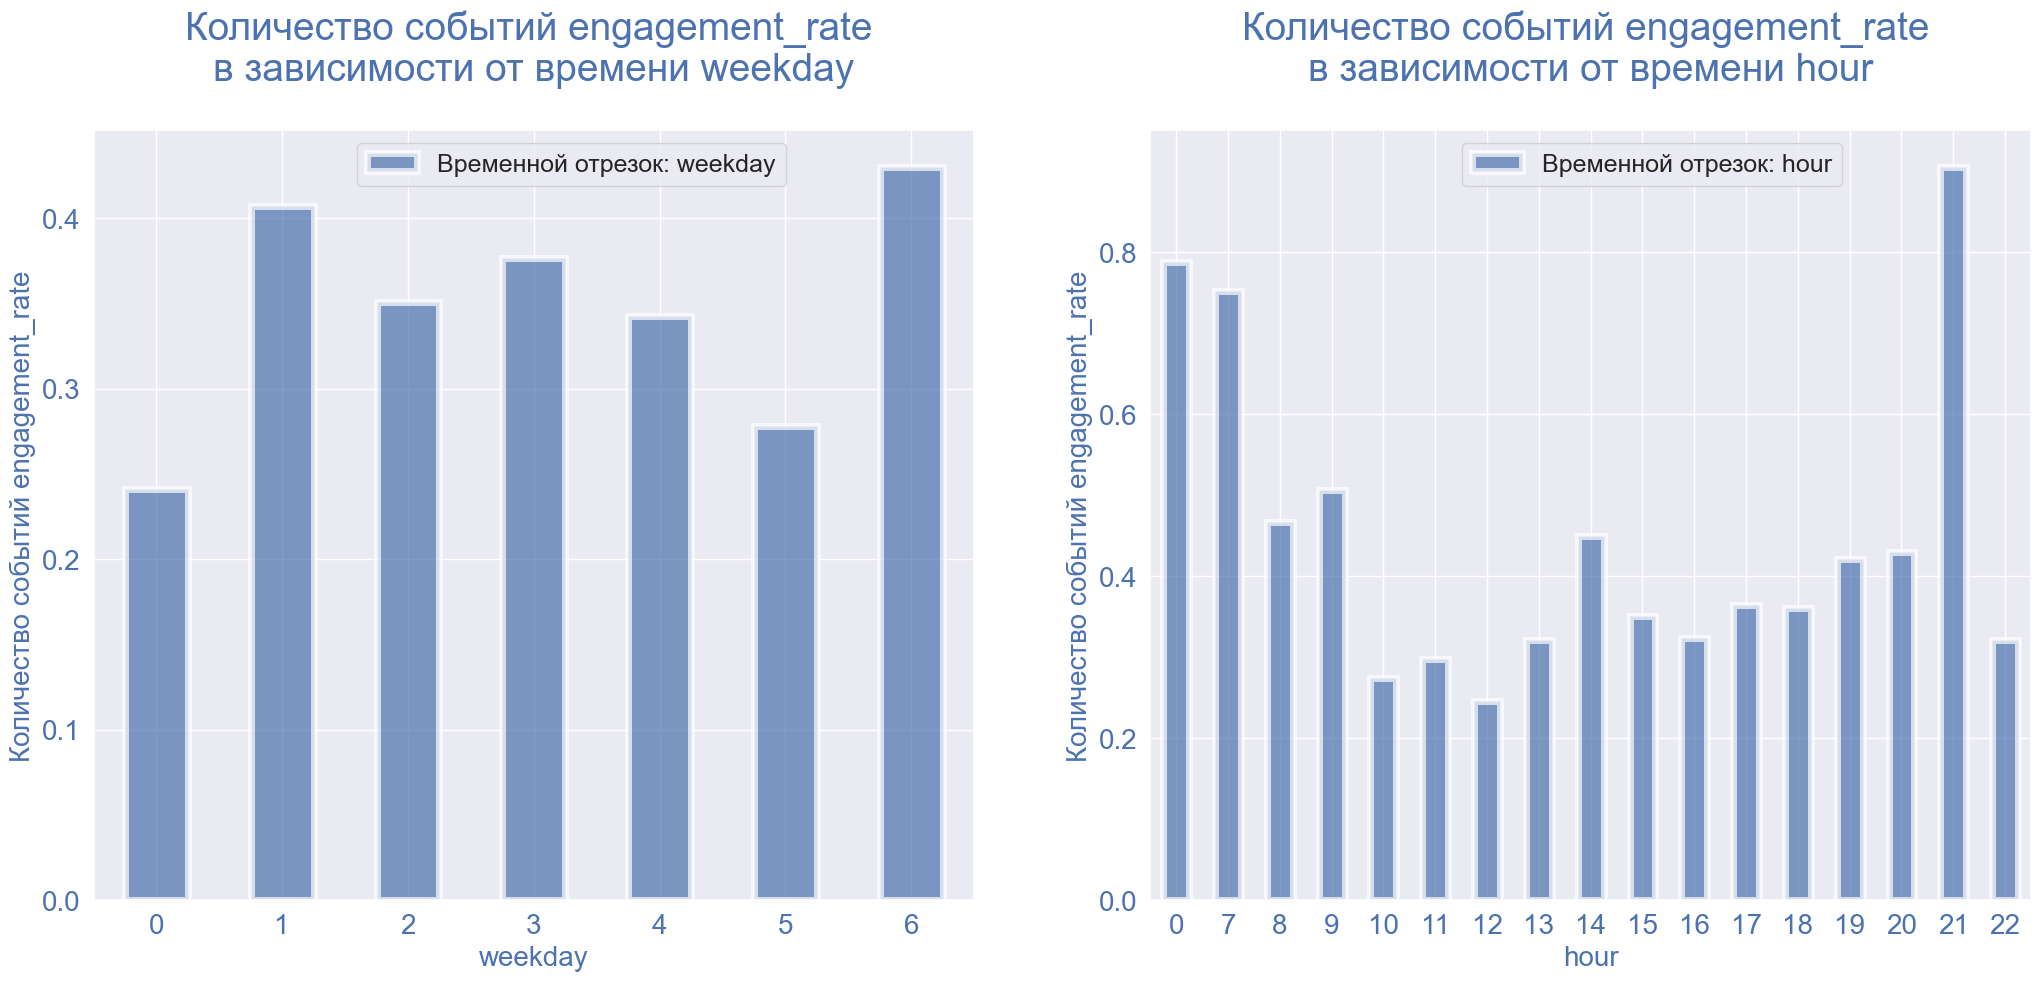

In [99]:
# задаём размер сетки для графиков
plt.figure(figsize=(15, 10))

# в первой ячейке строим распределение по группе количеству заказов
ax1 = plt.subplot(1, 2, 1)
# вызываем функцию
event_in_time_bar(innopolistg_emoji, 'engagement_rate', 'weekday', 'mean', ax1)

# во второй ячейке строим распределение по количеству покупателей
ax2 = plt.subplot(1, 2, 2)
# вызываем функцию
event_in_time_bar(innopolistg_emoji, 'engagement_rate', 'hour', 'mean', ax2)

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
БОльшую популярность набирают посты, вышедшие:
    
- во вторник и в воскресенье. Но, может быть, дело в том, что в эти дни публикуются посты с популярными темами??? Нужно посмотреть
    
- в вечерние и предутренние часы


### Зависимость популярности поста от сложности публикуемого текста.
Определим зависимость популярности публикации от:
- количества слов в публикации - столбец	 `words_in_text`
- количества символов в публикации: буквы, цифры, пробелы и символы - столбец `simbols_in_text`
- средней длины слова в каждом посте (количество символов, разделенное на количество слов)- столбец	 `avg_word_len`
- количества слов, которые в каждой публикации приходится на один знак препинания - столбец	 `marks_per_text`

Популярность примет значения:
- `comments_per_views` (отношение количества комментариев к количеству просмотров поста)
- `reactions_per_views` (отношение количества комментариев к количеству просмотров поста)



In [100]:
innopolistg_emoji.head(1)

id                      date  \
0  1421 2023-12-06 15:41:17+00:00   

                                                text   views  reactions_count  \
0  2023 год подходит к концу. И мы вспоминаем сам...  2294.0               45   

   comments type_attachment  \
0         4     пост с фото   

                                           reactions          post_topic  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   

   popular_word_count  ...  year  month  weekday  weekday_name  hour  \
0                   5  ...  2023     12        2     Wednesday    15   

   times_of_day  days_cnt  comments_per_views  reactions_per_views  \
0          день       1.0               0.174                1.962   

  engagement_rate  
0          0.5316  

[1 rows x 26 columns]

In [101]:
innopolistg_emoji[['simbols_in_text', 'words_in_text', 'avg_word_len', 'marks_per_text']].describe()

simbols_in_text  words_in_text  avg_word_len  marks_per_text
count       539.000000     539.000000    539.000000           539.0
mean        399.907236      65.064935      5.705937             inf
std         327.880093      44.328545      2.487531             NaN
min           1.000000       2.000000      0.500000             1.0
25%         112.000000      24.000000      4.100000             5.0
50%         311.000000      62.000000      4.800000            10.0
75%         644.500000      98.000000      6.950000            21.5
max        1822.000000     218.000000     19.300000             inf

#### Гистограмма распределения  значений рассматриваемых параметров
Построим гистограмму распределения  значений рассматриваемых параметров
Создадим небольшую функцию для построения распределения по количеству тех или иных событий в разрезе групп

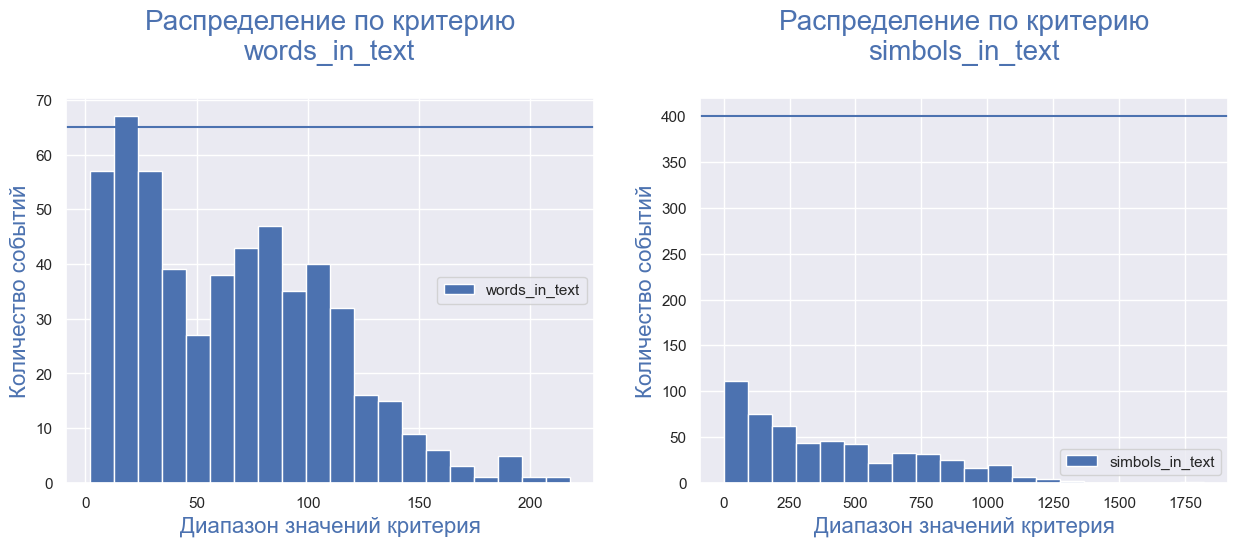

In [102]:
drow_hist('words_in_text', 'simbols_in_text')

Для корректного построения диарамм приравняем к 140 единицам значение бесконечности (inf), принимаемое параметром `marks_per_text`

In [103]:
innopolistg_emoji.loc[(innopolistg_emoji['marks_per_text'] == innopolistg_emoji.marks_per_text.max()), 'marks_per_text'] = 140

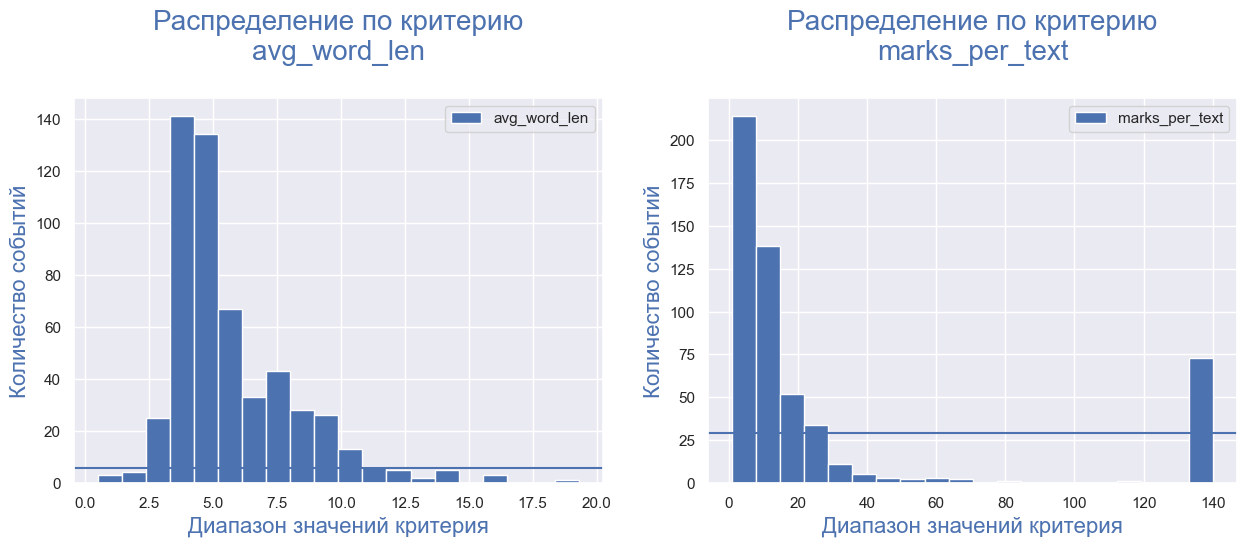

In [104]:
drow_hist('avg_word_len', 'marks_per_text')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
Обычно в публикации:
    
- содержится до 120 слов, в среднем - 65 слов
   
- содержится до 1100 символов (буквы, цифры, пробелы и символы), наиболее часто до 250 символов, в среднем - 400 символов
    
- средняя длина слова составляет от 3 до 8 символов    
   
- один знак препинаниня приходится на чуть более, чем 25 символов

    

Создадим список `catalog_by_text`, в который поместим наименования интересующих нас столбцов

In [105]:
# Зависимость реакций и времени жизни  от сложности текста
catalog_by_text = [
'views',
 'comments',
 'comments_per_views',
 'reactions_count',
 'reactions_per_views',
 'engagement_rate',
 'days_cnt',

  'simbols_in_text',
 'words_in_text',
 'avg_word_len',
 'punct_marks',
 'marks_per_text'
]

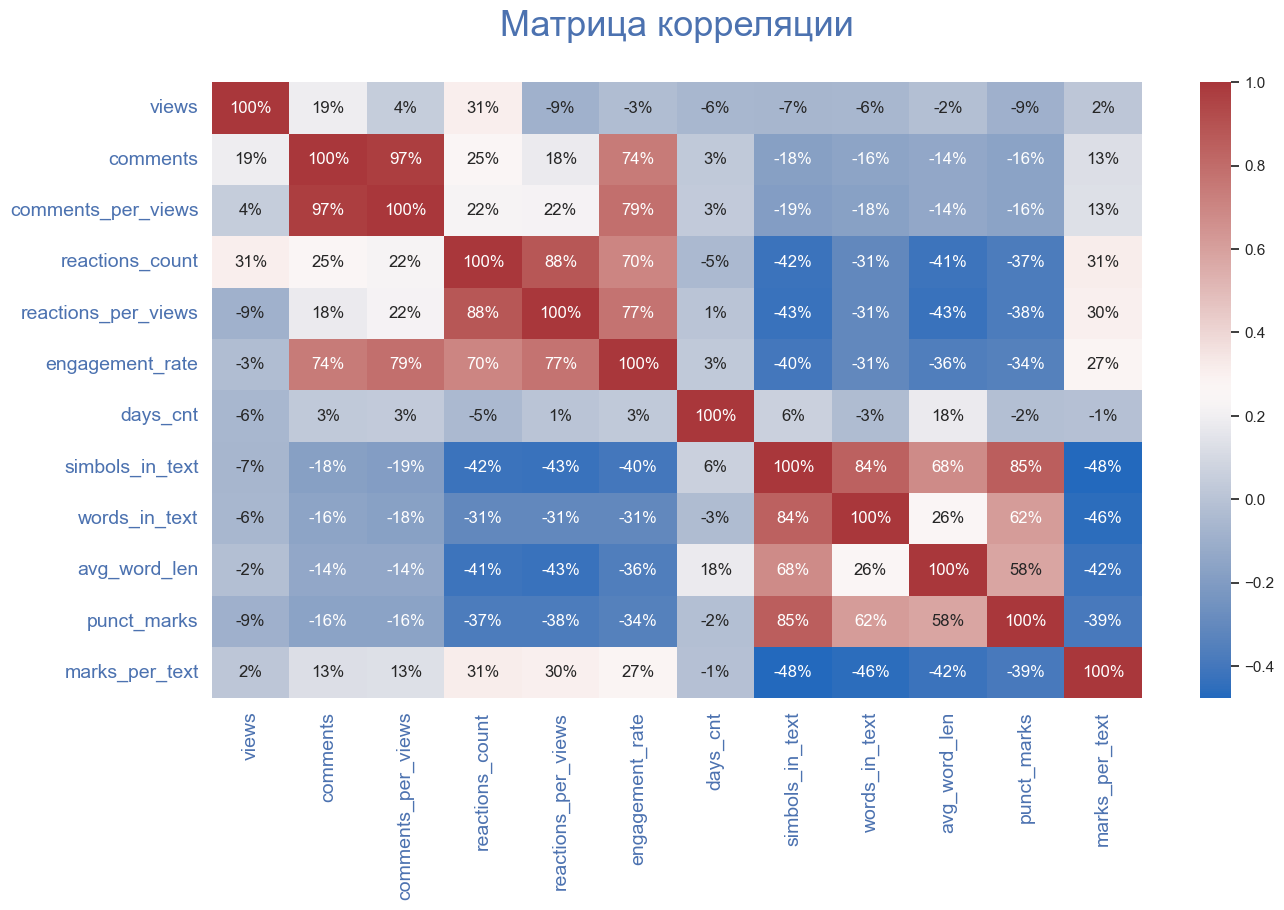

In [106]:
coef_corr(catalog_by_text)

Заметная отрицательная зависимость популярности постов от сложности текста - в диапазоне от 27 до 43%.  
И зависимость абсолютного числа комментариев и реакций от сложности текста- в диапазоне от 12 до 19%.  
А также зависимость длительности жизни поста от средней длины слова в тексте - коэффициент равен 18.  

Изучим эти зависимости повнимательнее.

#### Диаграмма плотности

Построим диаграмму плотности: зависимость отоносительного количества комментариев от исследуемых папаметров.  
Создадим функцию `corr_score_sales`

In [107]:
def corr_score_sales(param_x, param_y, limit_x_floor, limit_x_ceiling, limit_y, ax):

    ax = innopolistg_emoji.plot(x=param_x, y=param_y, kind='hexbin', gridsize=80, \
                                   sharex=False, grid=True, figsize=(15,3)\
                               )
    #plt.xlim(limit_x_floor, limit_x_ceiling)
    plt.ylim(0, limit_y)
    plt.title(f'Зависимость \nмежду {param_x}  \nи {param_y}  \n', fontsize=20, color = "b")
    plt.xticks(rotation=0, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    plt.xlabel(param_x, fontsize=14, color = "b")
    plt.ylabel(param_y, fontsize=14, color = "b")
    plt.show()
    print("\033[34m"
        f'Козффициент корреляции между {param_x}  \nи {param_y}   =',\
      innopolistg_emoji[param_x].corr(innopolistg_emoji[param_y]).round(2))


    return

##### Зависимость от отоносительного количества комментариев

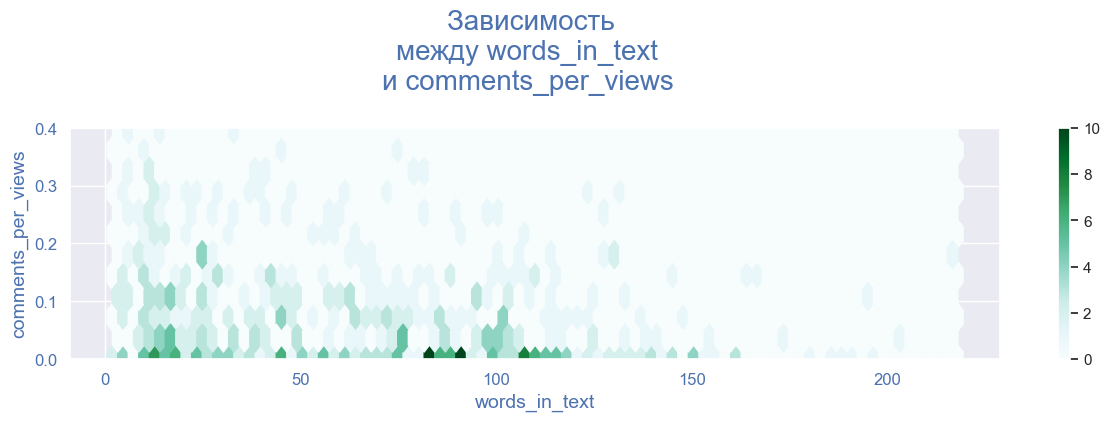

Козффициент корреляции между words_in_text  
и comments_per_views   = -0.18


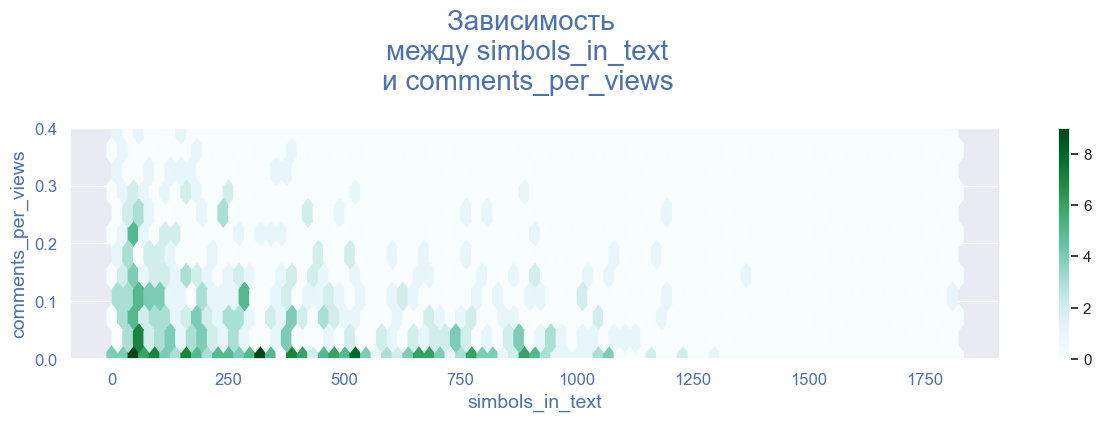

Козффициент корреляции между simbols_in_text  
и comments_per_views   = -0.19


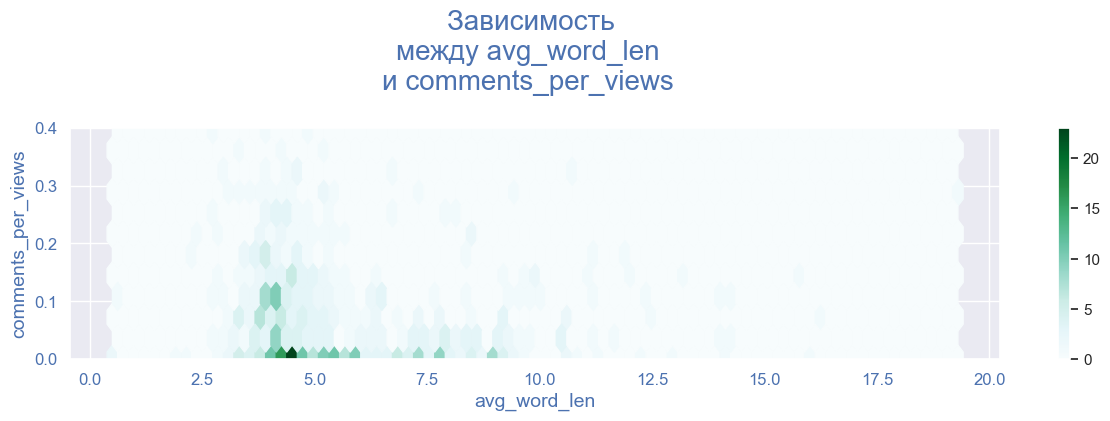

Козффициент корреляции между avg_word_len  
и comments_per_views   = -0.14


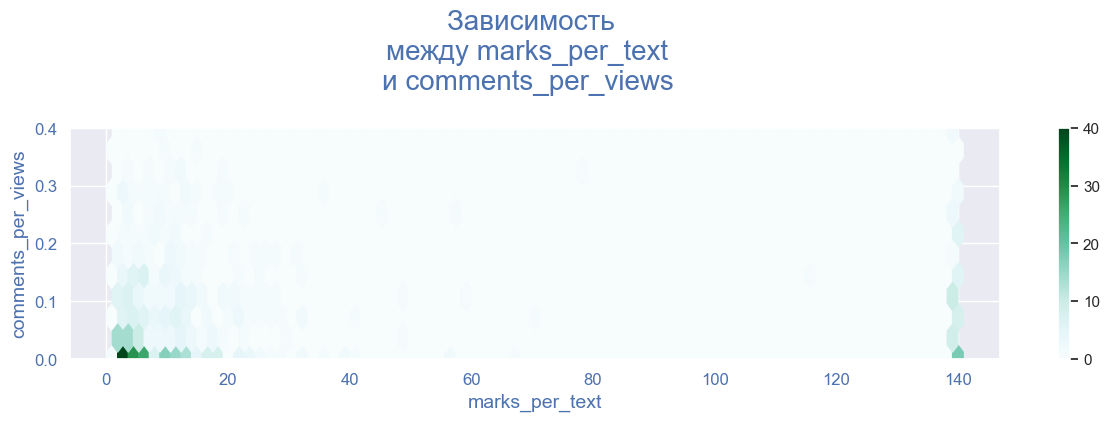

Козффициент корреляции между marks_per_text  
и comments_per_views   = 0.13


In [108]:
for i in ['words_in_text','simbols_in_text',  'avg_word_len', 'marks_per_text']:
    corr_score_sales(i, 'comments_per_views', 0, 150, 0.4, ax)


<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
наиболее часто встречаемая величина относительного количества комментариев:
    
- в диапазоне до 0,2% при количестве слов в публикации - до 50 слов. Козффициент корреляци имеет среднюю величину и обратную зависимость. Чем больше слов в публикации - тем меньше комментариев.
   
- в диапазоне до 0,3% при количестве символов в публикации - до 280 символов. Козффициент корреляци имеет среднюю величину и обратную зависимость. Чем больше символов в публикации - тем меньше комментариев.
    
- в диапазоне до 0,15% при средней длине слова - от 3 до 7 символов. Козффициент корреляци имеет среднюю величину и обратную зависимость. Чем больше средняя длина слова в публикации - тем меньше комментариев.
  
-  в диапазоне до 0,1% если количество знаков препинания приходится на не более, чем 5 слов. Козффициент корреляци имеет среднюю величину и прямую зависимость - чем на больншее количество слов приходится один знак препинания, тем больше комментарием. иначе говоря, сожност текста (количество знаков препинания) увеличивает количество комментариев

    

##### Зависимость от отоносительного количества реакций

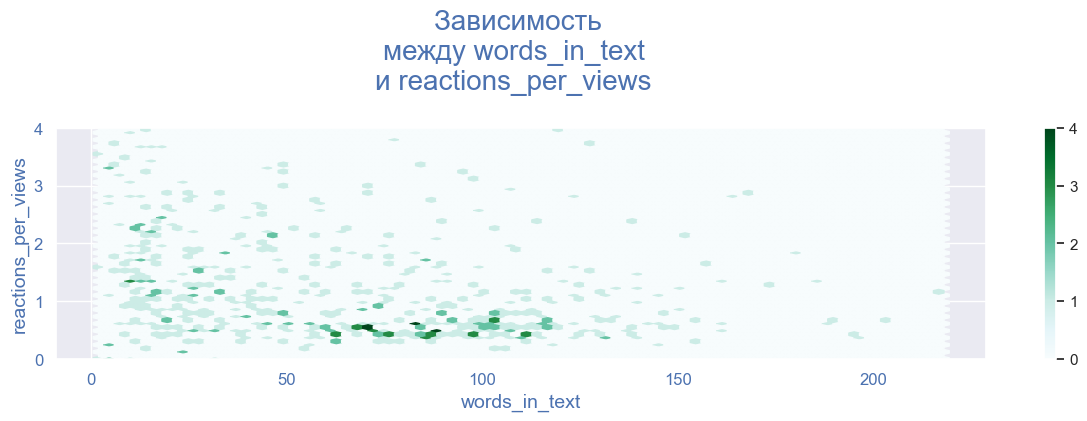

Козффициент корреляции между words_in_text  
и reactions_per_views   = -0.31


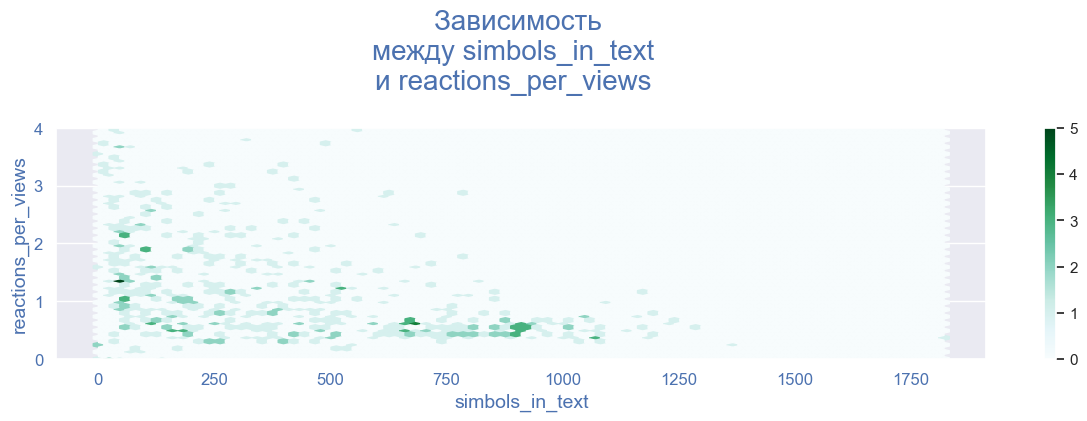

Козффициент корреляции между simbols_in_text  
и reactions_per_views   = -0.43


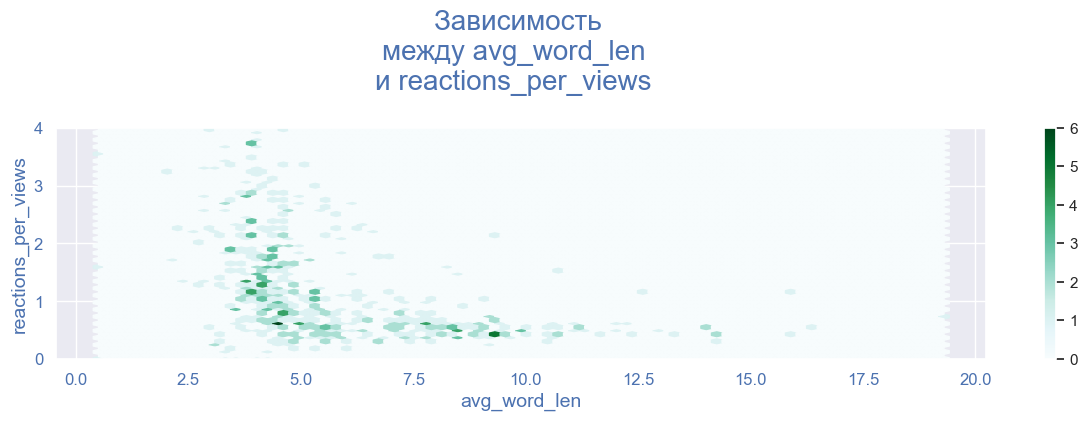

Козффициент корреляции между avg_word_len  
и reactions_per_views   = -0.43


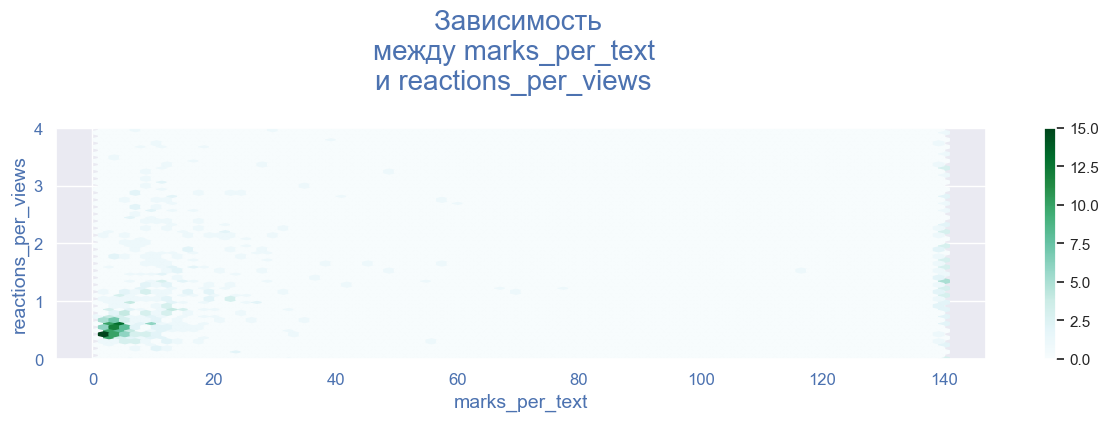

Козффициент корреляции между marks_per_text  
и reactions_per_views   = 0.3


In [109]:
for i in ['words_in_text','simbols_in_text',  'avg_word_len', 'marks_per_text']:
    corr_score_sales(i, 'reactions_per_views', 0, 150, 4, ax)


<div style="border-radius: 45px; border:solid green 7px; padding: 40px">

Сразу обращает на себя более высокий коэффициент корреляции между реакциями читателей и рассматриваемыми метриками.! Зависимость более, чем вдвое выше, чем у комментариев.
    
Наиболее часто встречаемая величина относительного количества реакций:
    
- в диапазоне до 2,5% при количестве слов в публикации - до 50 слов. И в диапазоне до 0,7% при количестве слов в публикации - от 50 до 120 слов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше слов в публикации - тем меньше реакций.
   
- в диапазоне до 2,2% при количестве символов в публикации - до 260 символов. И в диапазоне до 0,7% при количестве символов в публикации - от 650 до 900 символов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше символов в публикации - тем меньше комментариев.
    
- в диапазоне до 4% при средней длине слова - от 3 до 6 символов. И в диапазоне до 0,8% при средней длине слова - от 7 до 9 символов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше средняя длина слова в публикации - тем меньше комментариев.
  
-  в диапазоне до 0,6% если количество знаков препинания приходится на не более, чем 7 слов. Козффициент корреляци имеет довольно большую величину и прямую зависимость - чем на больншее количество слов приходится один знак препинания, тем больше комментарием. иначе говоря, сожность текста (количество знаков препинания) увеличивает количество комментариев

    

##### Зависимость от коэффициента вовлеченности
Напомним, агрегированный показатель `aggregated_per_views` рассчитывается как отношение количества агрегированного показателя к количеству просмотров поста. В свою очередь агрегированный показалель `aggregated` рассчитан как сумма количества комментариев с удельным весом 0,75 (может быть изменен) и количества реакций с удельным весом 0,25 (может быть изменен).  


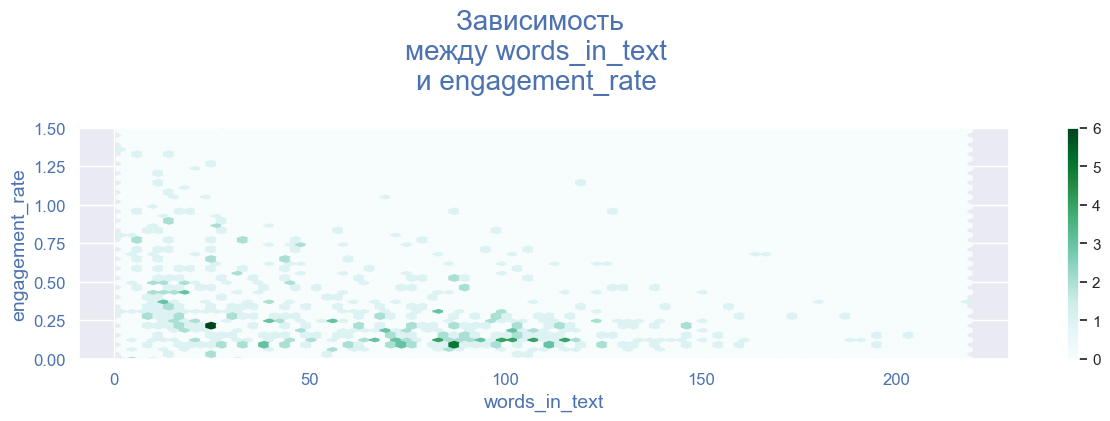

Козффициент корреляции между words_in_text  
и engagement_rate   = -0.31


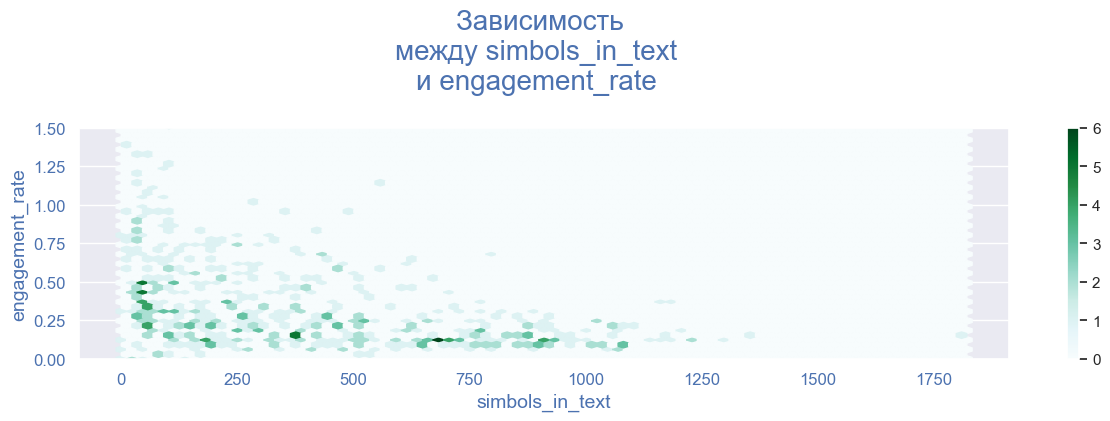

Козффициент корреляции между simbols_in_text  
и engagement_rate   = -0.4


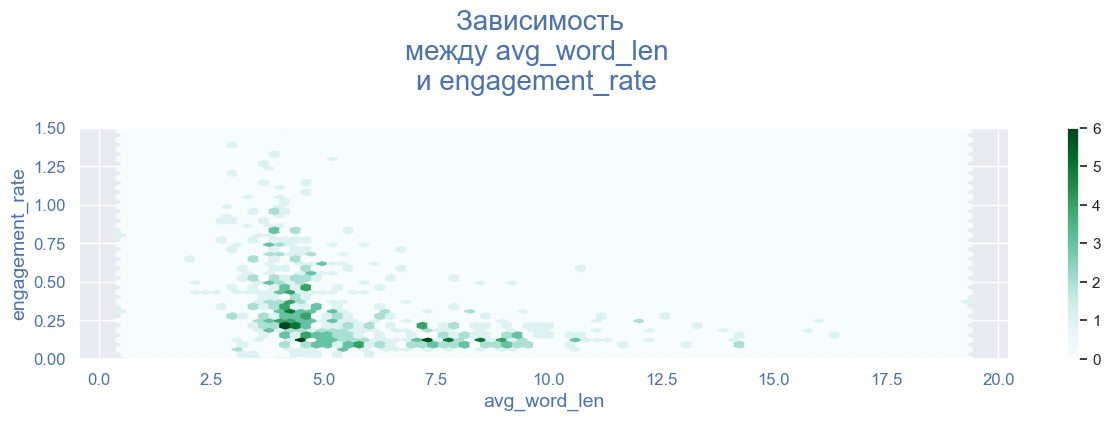

Козффициент корреляции между avg_word_len  
и engagement_rate   = -0.36


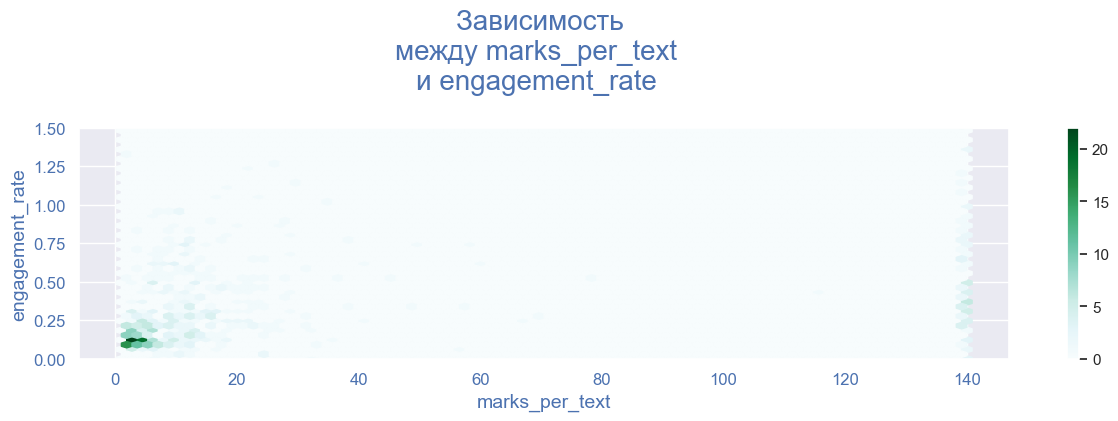

Козффициент корреляции между marks_per_text  
и engagement_rate   = 0.27


In [110]:
for i in ['words_in_text','simbols_in_text',  'avg_word_len', 'marks_per_text']:
    corr_score_sales(i, 'engagement_rate', 0, 150, 1.5, ax)


<div style="border-radius: 45px; border:solid green 7px; padding: 40px">

Коэффициент корреляции для коэффициента вовлеченности по величине ближе к аналогичному коэффициенту для комментариев, нежели для реакций - что объяснимо. Величина коэффициента корреляции довольно значительная.
    
Наиболее часто встречаемая величина относительного количества реакций:
    
- в диапазоне до 0,5% при количестве слов в публикации - до 50 слов. И в диапазоне до 0,25% при количестве слов в публикации - от 60 до 120 слов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше слов в публикации - тем меньше реакций.
   
- в диапазоне до 0,5% при количестве символов в публикации - до 450 символов. И в диапазоне до 0,25% при количестве символов в публикации - от 500 до 900 символов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше символов в публикации - тем меньше комментариев.
    
- в диапазоне до 1% при средней длине слова - от 3 до 6 символов. И в диапазоне до 0,3% при средней длине слова - от 7 до 9 символов. Козффициент корреляци имеет довольно большую величину и обратную зависимость. Чем больше средняя длина слова в публикации - тем меньше комментариев.
  
-  в диапазоне до 0,25% если количество знаков препинания приходится на не более, чем 7 слов. Козффициент корреляци имеет довольно большую величину и прямую зависимость - чем на большее количество слов приходится один знак препинания, тем больше комментарием. Иначе говоря, сложность текста (количество знаков препинания) уменьшает количество комментариев

    

<div style="border-radius: 45px; border:solid green 10px; padding: 40px">

Сопоставив выводы о зависимости комментариев, реакций и коэффициента вовлеченности можно увидеть, что все они дают на выходе примерно одинаковые диапазоны исследуемых зависимостей (количество символов, количество слов, средняя длина слова, количество слов, которые в каждой публикации приходится на один знак препинания).  
Учитывая сказанное можем для эксплуатации использовать коэффициент вовлеченности.

    

<div style="border-radius: 45px; border:solid green 14px; padding: 40px">

Наибольшую популярность набирают посты, в тексте которых:
    
- содержится до 50 слов. Чуть меньшую популярность имеют посты, содержащие от 60 до 120 слов. Чем больше слов в публикации - тем меньше популярность.
   
- содержится до 450 символов. Чуть меньшую популярность имеют посты, содержащие от 500 до 900 символов. Чем больше символов в публикации - тем меньше популярность.
    
- средняя длина слова (не считая предлогов, междометий и т.д.) - от 3 до 6 символов. Чуть меньшую популярность имеют посты, в которых средняя длина слова - от 7 до 9 символов. Чем больше средняя длина слова в публикации - тем меньше популярность.
  
-  количество знаков препинания приходится на не более, чем 7 слов. Чем на большее количество слов приходится один знак препинания, тем больше популярность.
    
    Резюмируя, чем сложнее текст, тем меньше популярность

    

### Зависимость времени жизни поста от времени его публикации

#### Зависимость времени жизни поста от месяца его публикации

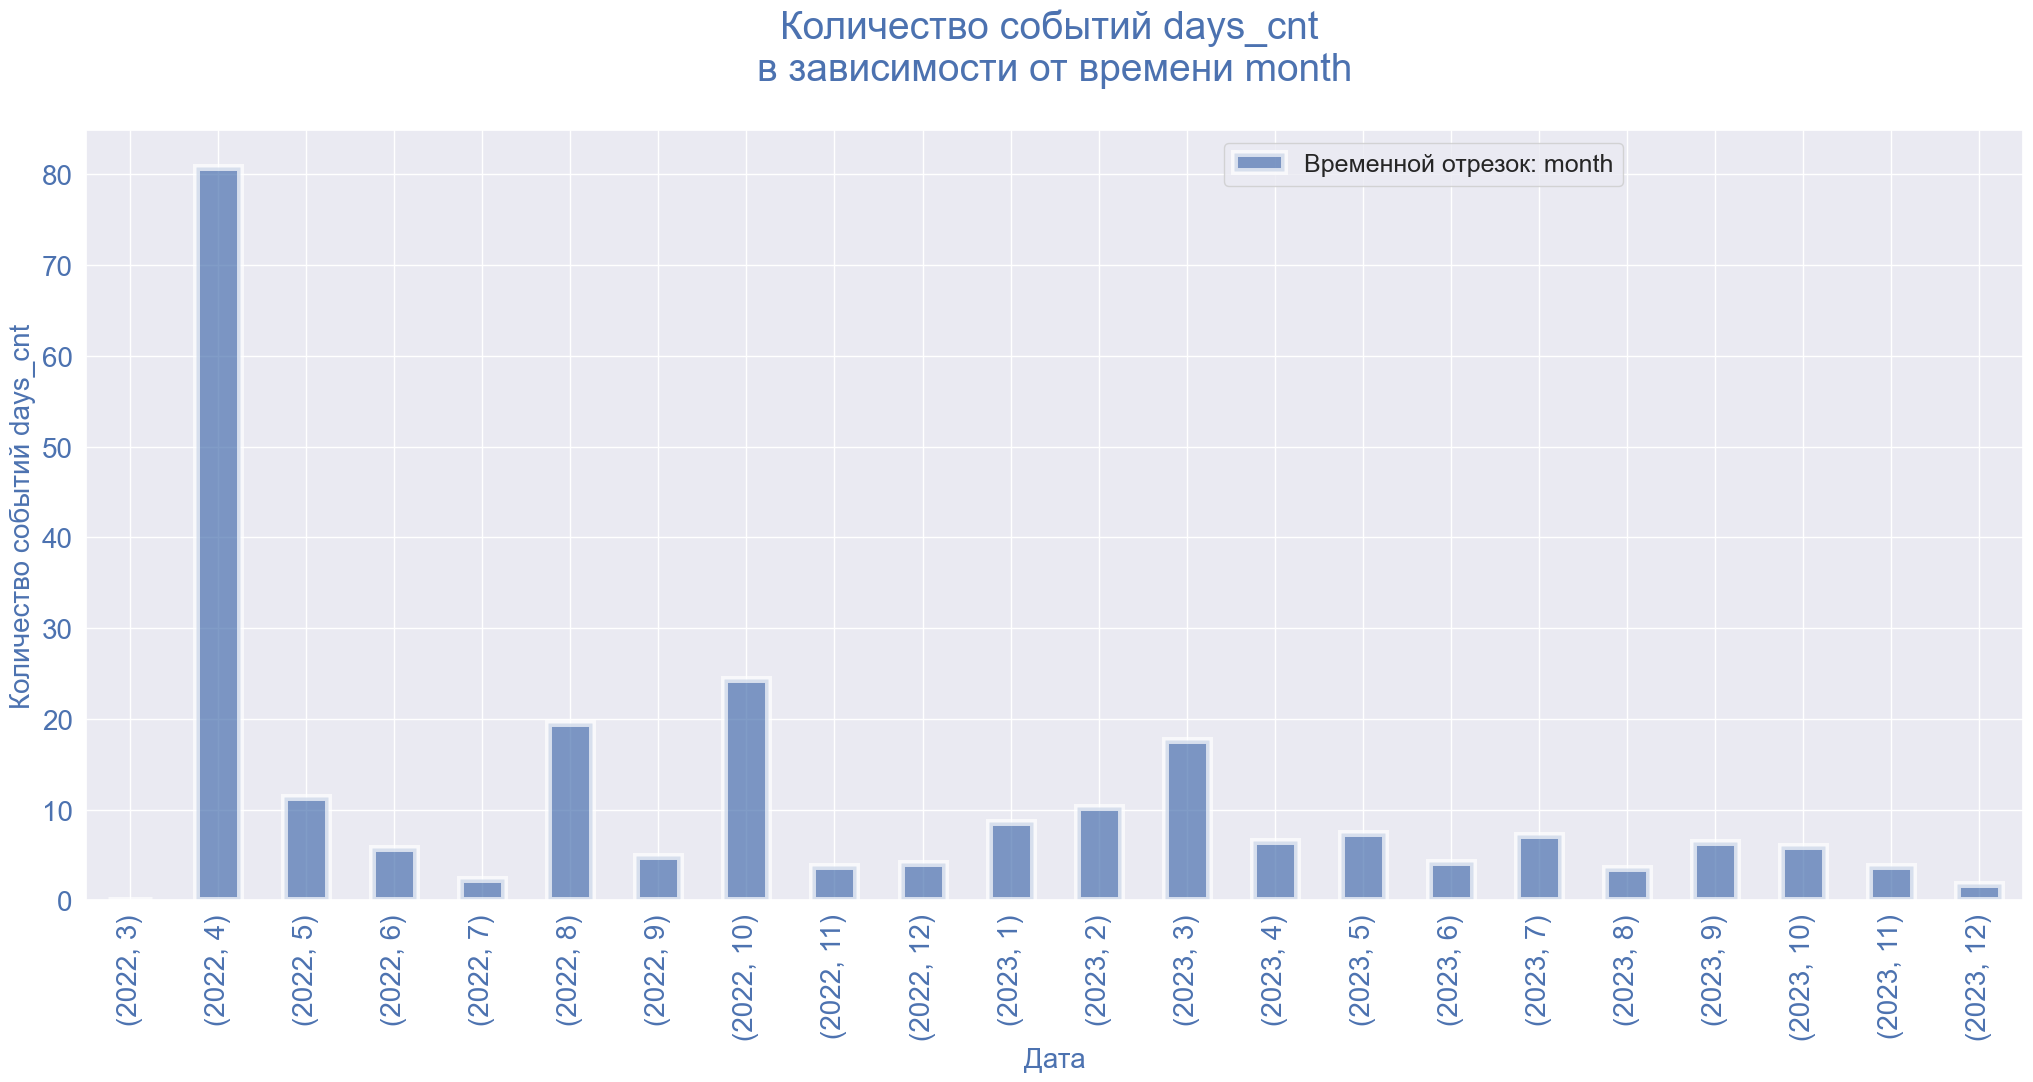

In [111]:
event_in_time_bar_year(innopolistg_emoji, 'days_cnt', 'month', 'mean')

Интрересно, время жизни постов, опубликованных в августе и октябре 2022 года, в марте 2023 года и особенно в апреле 2022 года значительно превышают время жизни постов, опубликованных в другое время.  

Посмотрим, что это за посты

Первым постотрим посты за апрель 2022 года

In [112]:
innopolistg_emoji.query('year == 2022 and month == 4')[['id','text', 'days_cnt']]

id                                               text  days_cnt
502  101  В айти много классных терминов. Мы решили собр...       1.0
503   94  28 апреля встречаемся в Иннополисе на Java Mee...       NaN
504   93  **💰🔝Весенний рейтинг зарплат в Татарстане возг...       NaN
505   91  Начинаем неделю с новостей, которые ты мог про...       NaN
506   84  Собрали советы, которые помогут наслаждаться р...       NaN
507   83  Стартап-студия [Университета Иннополис](https:...       NaN
508   82  Сейчас много разговоров об изменениях на рынке...       1.0
509   81  Ты уже мог забыть как выглядит Иннополис в хор...     453.0
510   78  **В московском музее Яндекса появился самый пе...       NaN
511   77  Далекий предок роверов, которые сегодня привоз...       NaN
512   74  Споры вокруг App Store идут уже три года. Разр...       1.0
513   73  В огромном потоке сообщений легко пропустить ч...       NaN
514   68  Проект будущего коливинга в картинках\n\nОн по...      20.0
515   67  Иннополис, [Фонд «Сколково»](https://t.me/skol...       NaN
516   65  Сейчас многим не понятно, что будет дальше и к...       NaN
517   64  Увидели [исследование Tromzo](https://www.trom...       NaN
518   63  Урбанисты Иннополиса молодцы, они получили чет...       9.0
519   62  Digital Innopolis Days Online от Университета ...       NaN

Из списка выделяется пост с id == 81, имеющий 453 дня жизни.  
Насколько часто и постоянно его смотрели читатели?

In [113]:
innopolistg_emoji.query('id == 81')

id                      date  \
509  81 2022-04-20 13:15:24+00:00   

                                                  text   views  \
509  Ты уже мог забыть как выглядит Иннополис в хор...  1901.0   

     reactions_count  comments type_attachment  \
509               55         2    пост с видео   

                                             reactions          post_topic  \
509  {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
509                   0  ...  2022      4        2     Wednesday    13   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
509          день     453.0               0.105                2.893   

    engagement_rate  
509          0.6626  

[1 rows x 26 columns]

In [114]:
comments_innopolistg.query('post_id == 81')

post_id              date_comment  \
2487       81 2022-04-20 13:36:01+00:00   
2488       81 2023-07-16 19:09:35+00:00   

                                           text_comment  
2487  Однажды,  я верю, оэз сможет отремонтировать п...  
2488                                  Очень красиво!💞🇷🇺

Нет, у поста всего два комментария:
- первый в день публикации
- второй - спустя почти полтора года

Ознакомимся с постами за август 2022 года

In [115]:
innopolistg_emoji.query('year == 2022 and month == 8')[['id','text', 'days_cnt']]

id                                               text  days_cnt
398  357  Встретили День Республики фестивалем To-do Fes...       3.0
399  352  Лови всю информацию о фестивале To-do Fest. \n...       1.0
400  351  😶😶😶😶😶😶😶\n\n1. Слили базы данных кинотеатра [ST...      19.0
401  350  Продолжаем изучать словарь «айтишный для начин...     119.0
402  349  Совместно с RCI, рекрутмент центром Иннополиса...     120.0
403  348  В нашем опросе о нейросетях победил вариант от...       2.0
404  346  😀😀😀😀😀😀😀\n\n1. На «Джеймсе Уэббе» [используется...       2.0
405  339  Мы периодически тестим современные нейронки в ...       5.0
406  337  До конца лета осталось две недели, а ещё столь...       NaN
407  336  Можешь не искать в навигаторе название «Новогр...       1.0
408  335  Решили поддержать идею ~~Wildberries~~ Ягодки ...       4.0
409  334  Новости возвращаются после небольшого отпуска:...       NaN
410  333  Ещё одно новое слово из словаря «айтишный для ...       8.0
411  332  [Редакция Enter](https://t.me/enter_media) сов...      26.0
412  331  Совместно с RCI, рекрутмент центром Иннополиса...       NaN
413  325  Система развития стартапов появилась в ОЭЗ «Ин...       1.0
414  318                   Гайд: где фоткаться в Иннополисе       1.0
415  313  На этой неделе публикаций про Иннополис в разн...      19.0
416  306  Идея для стартапа: трижды написать пост о стар...       1.0
417  300  **Стартап по выявлению NFT-подделок нашего вып...       1.0
418  299  1. В России в 4 раза [вырос спрос](https://www...       NaN

Выделяются по времени жизни посты 349 и 350.  
Что же в них особенного?

In [116]:
innopolistg_emoji.query('id == [350, 349] ')

id                      date  \
401  350 2022-08-26 17:31:12+00:00   
402  349 2022-08-25 17:45:01+00:00   

                                                  text   views  \
401  Продолжаем изучать словарь «айтишный для начин...  3477.0   
402  Совместно с RCI, рекрутмент центром Иннополиса...  3964.0   

     reactions_count  comments type_attachment  \
401               32         1     пост с фото   
402               17         5     пост с фото   

                                             reactions post_topic  \
401  {'_': 'MessageReactions', 'results': [{'_': 'R...    Словарь   
402  {'_': 'MessageReactions', 'results': [{'_': 'R...   Вакансии   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
401                   1  ...  2022      8        4        Friday    17   
402                   3  ...  2022      8        3      Thursday    17   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
401          день     119.0               0.029                0.920   
402          день     120.0               0.126                0.429   

    engagement_rate  
401          0.2072  
402          0.1866  

[2 rows x 26 columns]

In [117]:
comments_innopolistg.query('post_id == [350, 349]').text_comment.tolist()

['Хихихиихиииххахахахаххахакххкх',
 'Казалось бы, должны требоваться и инженера, и операторы ЧПУ!?',
 'Тем более, со знанием английского;',
 'Руководитель проектов в области Al -\n-  что это такое; интересно.',
 'Неайтишные вакансии можно посмотреть в канале @innopolis_job',
 '7:00']

In [118]:
comments_innopolistg.query('post_id == 350 or post_id == 349')

post_id              date_comment  \
1958      350 2022-12-23 12:37:52+00:00   
1959      349 2022-09-07 11:03:32+00:00   
1960      349 2022-09-07 11:04:14+00:00   
1961      349 2022-09-07 11:07:14+00:00   
1962      349 2022-09-07 11:08:21+00:00   
1963      349 2022-12-23 12:39:05+00:00   

                                           text_comment  
1958                     Хихихиихиииххахахахаххахакххкх  
1959  Казалось бы, должны требоваться и инженера, и ...  
1960                 Тем более, со знанием английского;  
1961  Руководитель проектов в области Al -\n-  что э...  
1962  Неайтишные вакансии можно посмотреть в канале ...  
1963                                               7:00

Пост с id=350 был прокомментирован всего один раз - и это произошло спустя четыре месяца после его публикации

Пост с id=349 был прокомментирован четыре раза спустя две недели после его публикации и был он прокоментирован с большой вероятностью одним человеком.   
Пятый комментарий (и это второй комментатор) - спустя 4 месяца - и в нем только символы 7:00

Посмотрим, чт было в октябре 2022 года

In [119]:
innopolistg_emoji.query('year == 2022 and month == 10')[['id','text', 'days_cnt']]

id                                               text  days_cnt
353  480  1. [Минцифры](https://www.kommersant.ru/doc/56...       NaN
354  479  Собрали идеальный плейлист нашего города\n\nТр...       NaN
355  477  Новая статья на Хабре — как в Иннополисе созда...       NaN
356  468  Солнечное затмение можно наблюдать разными спо...       7.0
357  467  [Немного цифр на сегодня](https://t.me/bezbuld...       1.0
358  466  1. [Apple Watch помогли](https://www.hourdetro...       NaN
359  460  У нас прошёл Innopolis Meetup: менторство и об...       NaN
360  459  Совместно с RCI, рекрутмент центром Иннополиса...     270.0
361  456  Enter написал материал о команде Иннополиса. В...       NaN
362  452  В [ОЭЗ «Иннополис»](https://t.me/SEZinno) появ...       1.0
363  446       Во-первых, это красиво\n\nPh: @gramila_photo       1.0
364  445  1. Эксперимент по созданию российского репозит...       1.0
365  437  Не забывай, что выходные — время для отдыха. С...       9.0
366  436  А какой музыкальный вкус у Иннополиса?\n\nНеда...       NaN
367  435  Мы подготовили для тебя новый Innopolis Meetup...       NaN
368  434  Сегодня только и разговоров, что о Квартале Ю\...       1.0
369  433  Сегодня вместе с @slavagoreev полетаем над осе...       2.0
370  432  Раскроем одну инвестиционную стратегию — жильё...       NaN
371  431  1. У Intel [утекли исходные коды](https://www....       NaN
372  425  Собрали с boykofm несколько [плейлистов для те...       NaN
373  424  Совместно с RCI, рекрутмент центром Иннополиса...      17.0
374  423  Началось строительство завода по производству ...       1.0
375  421  Нашли очень необычный проект — фантастический ...       4.0
376  420  1. Самозанятые [смогут [](https://www.kommersa...       2.0

Выделяется пост с id = 459 с временем жизни 270 дней.

In [120]:
innopolistg_emoji.query('id == 459')

id                      date  \
360  459 2022-10-21 12:09:00+00:00   

                                                  text   views  \
360  Совместно с RCI, рекрутмент центром Иннополиса...  3149.0   

     reactions_count  comments type_attachment  \
360               17         1     пост с фото   

                                             reactions post_topic  \
360  {'_': 'MessageReactions', 'results': [{'_': 'R...   Вакансии   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
360                   3  ...  2022     10        4        Friday    12   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
360          день     270.0               0.032                 0.54   

    engagement_rate  
360          0.1336  

[1 rows x 26 columns]

In [121]:
comments_innopolistg.query('post_id == 459').text_comment.tolist()

['А где вы располагаетесь?']

И вновь это единственный комментарий - и он не особенно о чем.

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">

Мы посмотрели три месяца с выделяющимися временем жизни поста и не обнаружили в них ничего, что могло бы свидетельствовать о необыкновенных причинах длительного времени жизни. Ни один из этих постов не имеет постоянного интереса у читателей.  

Относим их к аномалиям и констатируем, что время жизни поста не зависит от месяца его публикации

#### Зависимость времени жизни поста от дня недели и часа его публикации

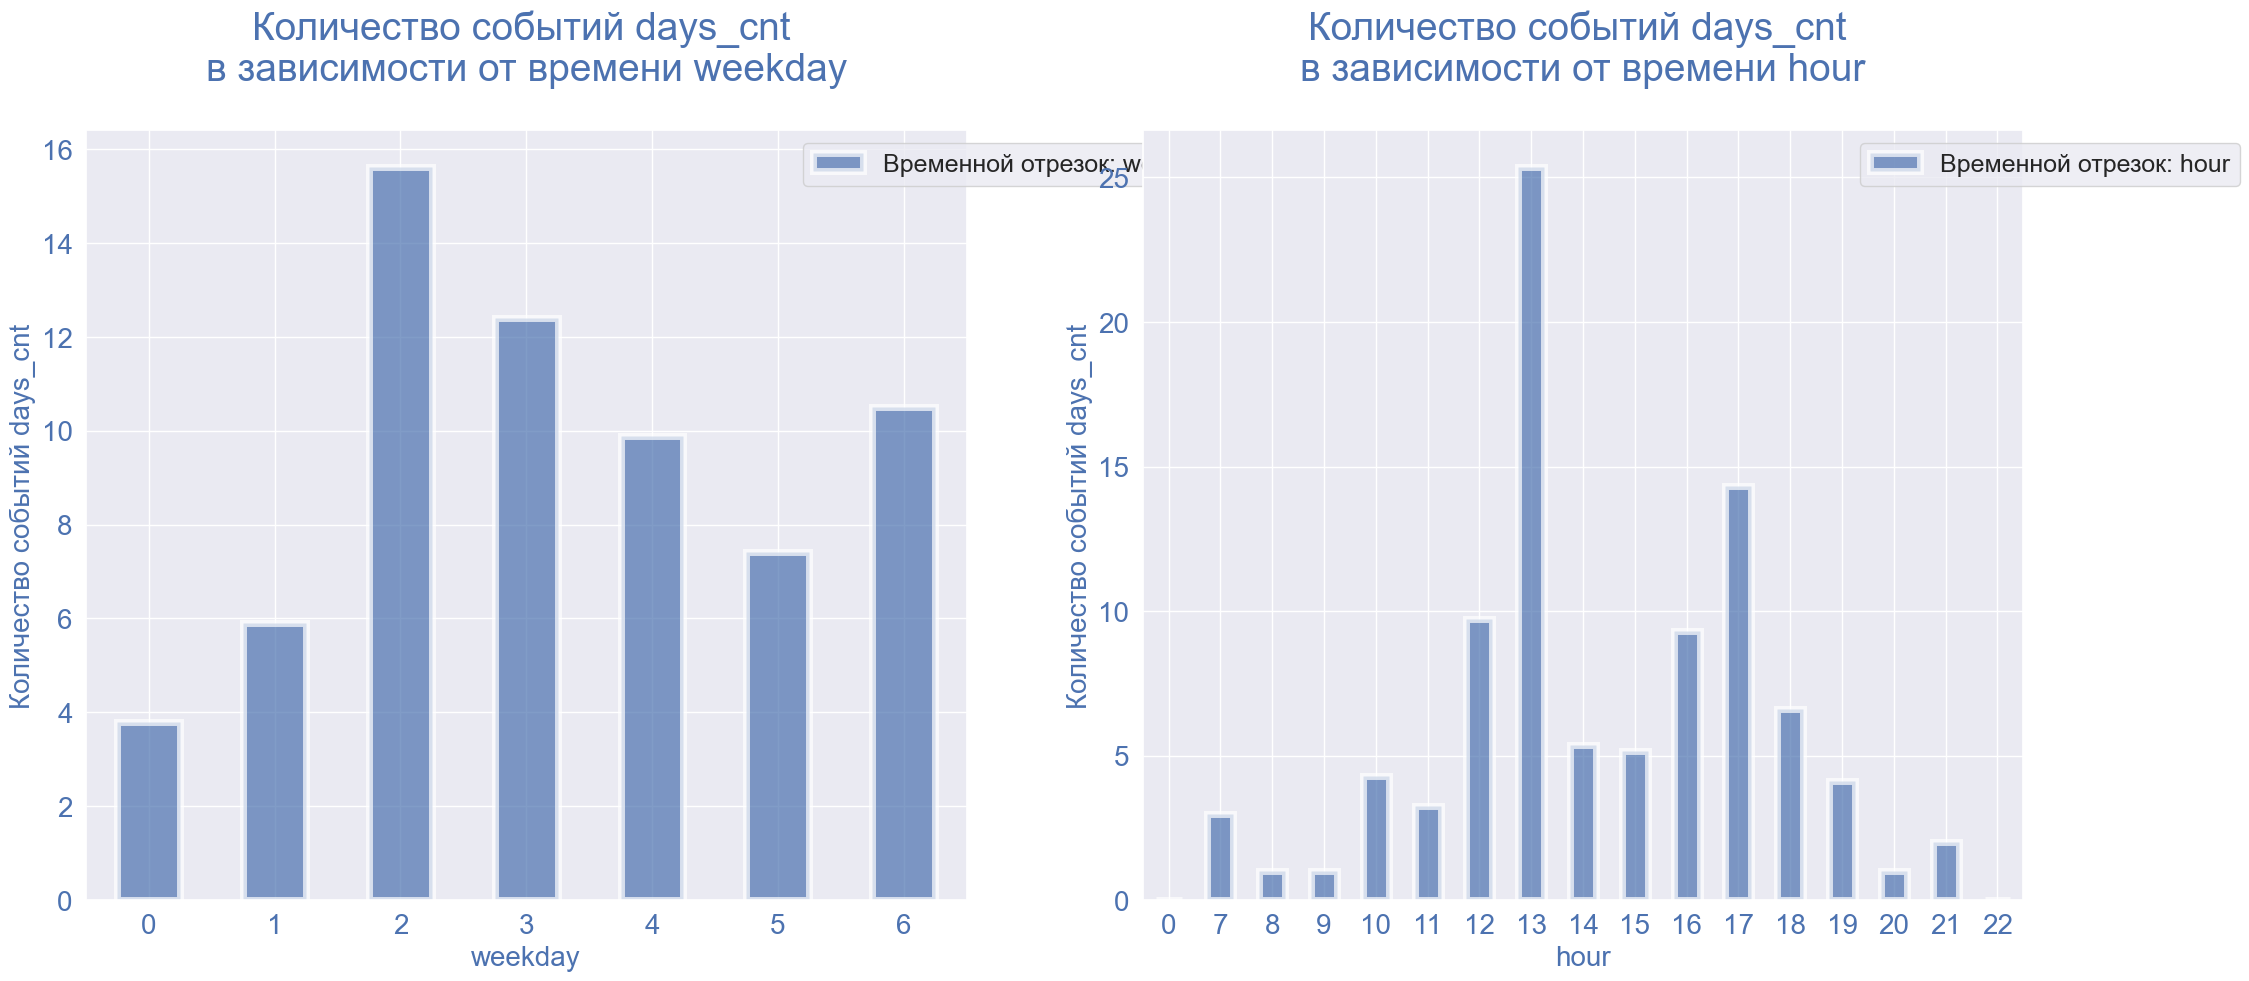

In [122]:
# задаём размер сетки для графиков
plt.figure(figsize=(15, 10))

# в первой ячейке строим распределение по группе количеству заказов
ax1 = plt.subplot(1, 2, 1)
# вызываем функцию
event_in_time_bar(innopolistg_emoji, 'days_cnt', 'weekday', 'mean', ax1)

# во второй ячейке строим распределение по количеству покупателей
ax2 = plt.subplot(1, 2, 2)
# вызываем функцию
event_in_time_bar(innopolistg_emoji, 'days_cnt', 'hour', 'mean', ax2)

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
Вновь отметим влияние дня недели и часа публикации
Большее время жизни имеют посты, вышедшие:
    
- в среду и в воскресенье. Но, может быть, дело в том, что и в эти дни публикуются посты с популярными темами??? Нужно посмотреть
    
- в утренние и дневные часы.
    
И здесь давайте тоже посмотрим, о чем это.

Здесь нам уже не обойтись простым просмотром.
Выявим границу аномальных значений

##### Аномальные значения
Выявим и при необходимости избавимся от аномальных значений (выбросов)
Но сначала познакомимся с диапазоном принимаемых значений  
Построим бокс-плот


(0.0, 50.0)

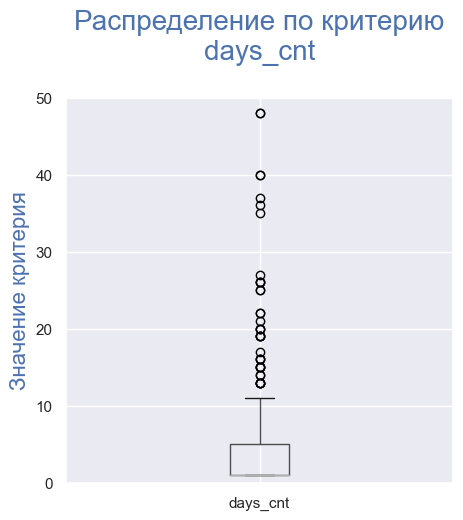

In [123]:
# построим ящики с усами
аx =  innopolistg_emoji.boxplot(['days_cnt'], figsize=(5,5))

plt.title('Распределение по критерию\n{}\n  '.format('days_cnt'), fontsize=20, color = "b")
plt.ylabel("Значение критерия", fontsize = 16, color = "b")
plt.ylim (0, 50)

Итак, значения времени жизни более,  чем 10 дней , находятся за пределами нормальных значений.  
Посмотрим на посты, опубликованные в среду с длиной жизни более 10 дней и на комментарии к ним.

In [124]:
innopolistg_emoji.query('weekday == 2 and days_cnt >= 10')[['id','text', 'days_cnt']]

id                                               text  days_cnt
31   1324  Ноябрьские обои уже готовы радовать тебя своим...      35.0
36   1316  **В Иннополисе беспилотный автомобиль Яндекса ...      11.0
107  1104  Совместно с RCI показываем наиболее интересные...      20.0
148   993  Недавно мы заглянули на стройки новых объектов...      15.0
216   805  Совместно с RCI показываем наиболее интересные...     220.0
252   727  Пост о том, какие классные разработки в [Униве...      26.0
259   711  Признаёмся, ChatGPT написал не только этот пос...      22.0
272   679  Начни планы на новый год с вакансиями из Инноп...      16.0
297   598  Совместно с RCI, рекрутмент центром Иннополиса...      13.0
509    81  Ты уже мог забыть как выглядит Иннополис в хор...     453.0

Два поста приносят высокий показатель. О чем они?

In [125]:
innopolistg_emoji.query('id == [805, 81] ')

id                      date  \
216  805 2023-03-29 17:45:39+00:00   
509   81 2022-04-20 13:15:24+00:00   

                                                  text   views  \
216  Совместно с RCI показываем наиболее интересные...  4531.0   
509  Ты уже мог забыть как выглядит Иннополис в хор...  1901.0   

     reactions_count  comments type_attachment  \
216               22         9     пост с фото   
509               55         2    пост с видео   

                                             reactions          post_topic  \
216  {'_': 'MessageReactions', 'results': [{'_': 'R...            Вакансии   
509  {'_': 'MessageReactions', 'results': [{'_': 'R...  События Иннополиса   

     popular_word_count  ...  year  month  weekday  weekday_name  hour  \
216                   5  ...  2023      3        2     Wednesday    17   
509                   0  ...  2022      4        2     Wednesday    13   

     times_of_day  days_cnt  comments_per_views  reactions_per_views  \
216          день     220.0               0.199                0.486   
509          день     453.0               0.105                2.893   

    engagement_rate  
216          0.2564  
509          0.6626  

[2 rows x 26 columns]

In [126]:
comments_innopolistg.query('post_id == [805, 81]').text_comment.tolist()

['Полиция лучшие',
 'Блин, показалось, «уборщик», думала, прорвусь в Иннополис… 😹😹😹',
 'Добрый вечер!\nЕсть ли вакансии для студентов?',
 'Студенты могут попробовать себя и на этих вакансиях. Но лучше поискать что-то для уровня junior',
 'Добрый вечер!\nТехник механик ищет работу в Инополисье',
 'По поводу вакансии сборщик, можно в лс подробнее',
 'Эта вакансия уже в архиве(',
 'Здравствуйте, подскажите пожалуйста, онлайн обучение lT для школьников у вас бывает ?',
 'В Университете Иннополис есть курсы для школьников \n\nhttps://stc.innopolis.university',
 'Однажды,  я верю, оэз сможет отремонтировать подсветку технопарка...',
 'Очень красиво!💞🇷🇺']

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
    
id = 81 уже знаком нам. и в его попутчике также нет ничего примечательного.
    
Также Относим их к аномалиям и констатируем, что время жизни поста не зависит от дня недели его публикации и маловерятно, что зависит от часа его публикации.  
    
Закрываем тему зависимости времени жизни поста от времени его публикации Выводом об отсутствии зависимости времени жизни поста от времени его публикации

### Зависимость времени жизни поста от сложности публикуемого текста.
Определим зависимость времени жизни публикации от:
- количества слов в публикации - столбец	 `words_in_text`
- количества символов в публикации: буквы, цифры, пробелы и символы - столбец `simbols_in_text`
- средней длины слова в каждом посте (количество символов, разделенное на количество слов)- столбец	 `avg_word_len`
- количества слов, которые в каждой публикации приходится на один знак препинания - столбец	 `marks_per_text`




#### Диаграмма плотности
 Построим диаграмму плотности

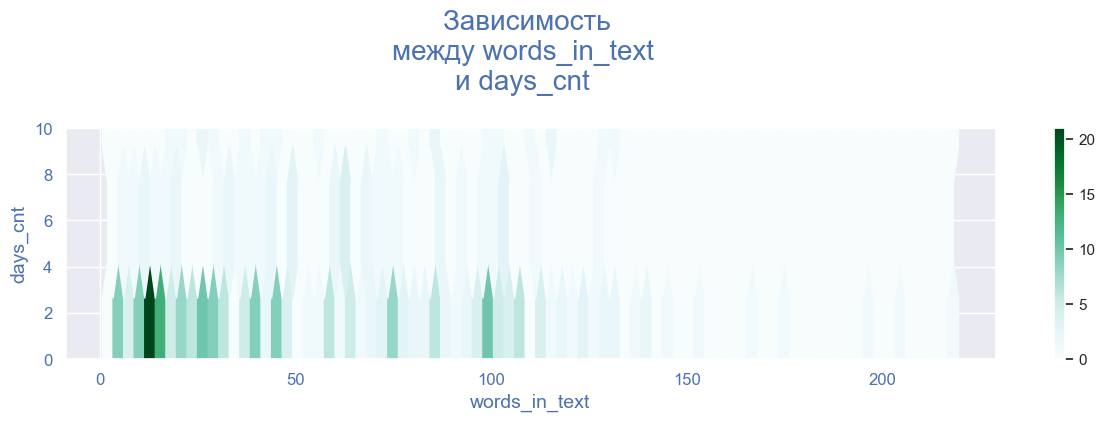

Козффициент корреляции между words_in_text  
и days_cnt   = -0.03


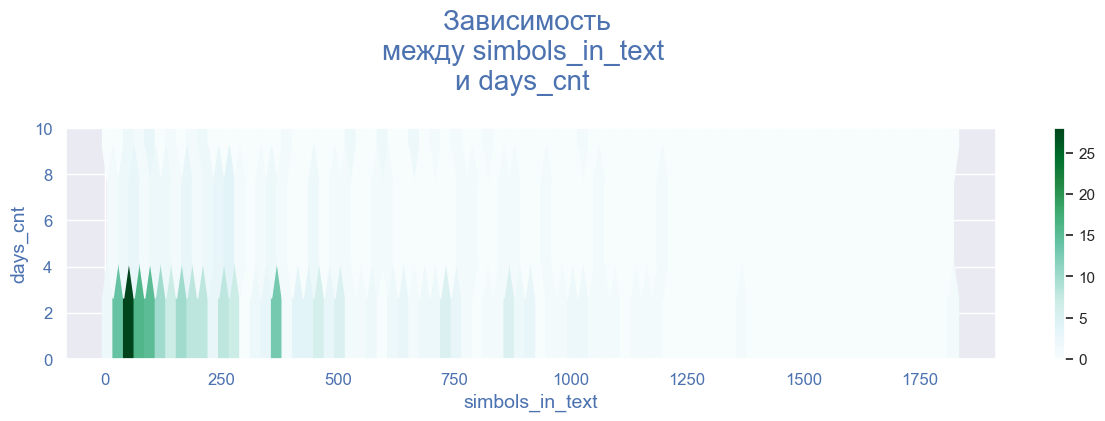

Козффициент корреляции между simbols_in_text  
и days_cnt   = 0.06


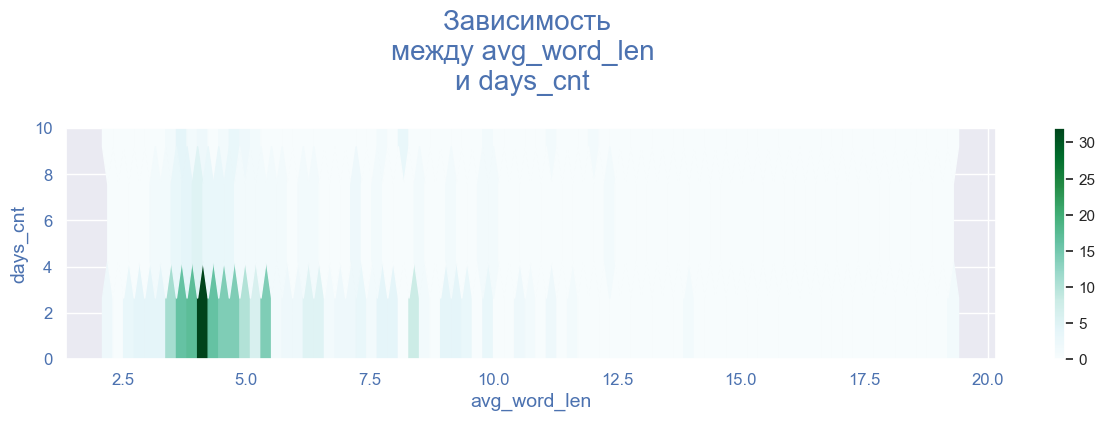

Козффициент корреляции между avg_word_len  
и days_cnt   = 0.18


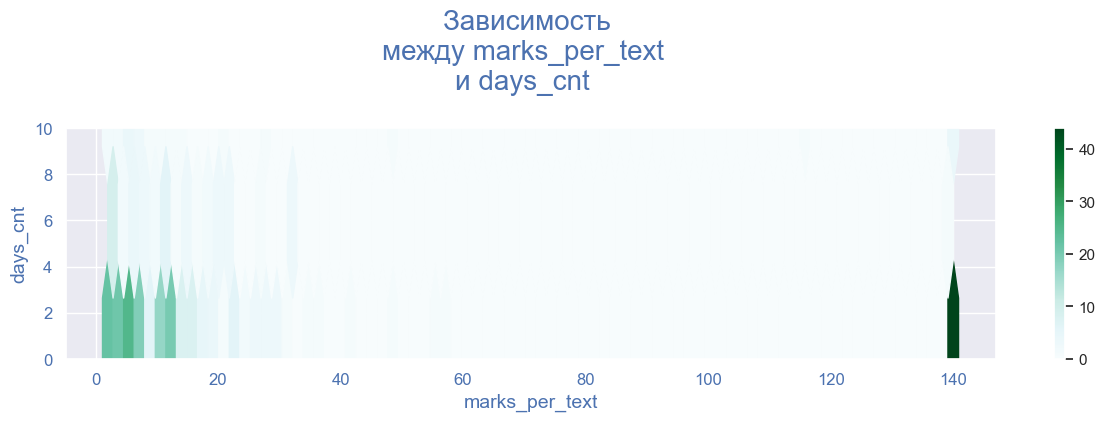

Козффициент корреляции между marks_per_text  
и days_cnt   = -0.01


In [127]:
for i in ['words_in_text','simbols_in_text',  'avg_word_len', 'marks_per_text']:
    corr_score_sales(i, 'days_cnt', 0, 150, 10, ax)


***Напомним, что значения параметра `marks_per_text`, равные 140 - обусловлены заменой показателя бесконечность на значение, равное 140***. Значение бесконечность появилось в результате деления на ноль


    
<div style="border-radius: 45px; border:solid green 7px; padding: 40px">


Коэффициенты корреляции между времением жизни поста и количеством слов, символов, знаков препинания крайне незначительная и мы об этом говорили выше.  
    
Но налицо  зависимость от среднего количества символов в слове - то есть от длины слова.  
    
Наилучшая средняя длина слова для длительности жизни - 4 символа. Наилучший диапазон - от 3,5 до 5 символов. Видимо, тексты с таким размером средней длины подписчики склонны прочесть, пролистывая непрочитанные ранее публикации    
    

### Зависимость популярности поста от темы

In [128]:
# строим столбчатую диаграмму, отражающую количество событий в зависимости от времени
def event_in_group(data_name, eventname, time_interval, operation, ax, x_size, y_size, x_name):
    t1 = data_name.groupby(time_interval).agg({eventname:operation}).sort_values(eventname, ascending = False)

    ax = t1.plot(figsize=(x_size,y_size),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7,
    label='Операция при группировке: '+ operation,
    ax=ax
    )

    plt.title('Количество событий {} \nв зависимости от {}\n'.format(eventname, time_interval), fontsize=20, color = "b")
    plt.legend(fontsize=14, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=30, fontsize=17, color = "b")
    plt.yticks(rotation=0, fontsize=17, color = "b")
    plt.xlabel(x_name, fontsize=17, color = "b")
    plt.ylabel(f"{operation} событий {eventname}", fontsize=14, color = "b")
    plt.subplots_adjust(top=1.5, hspace = 0.3)
    return

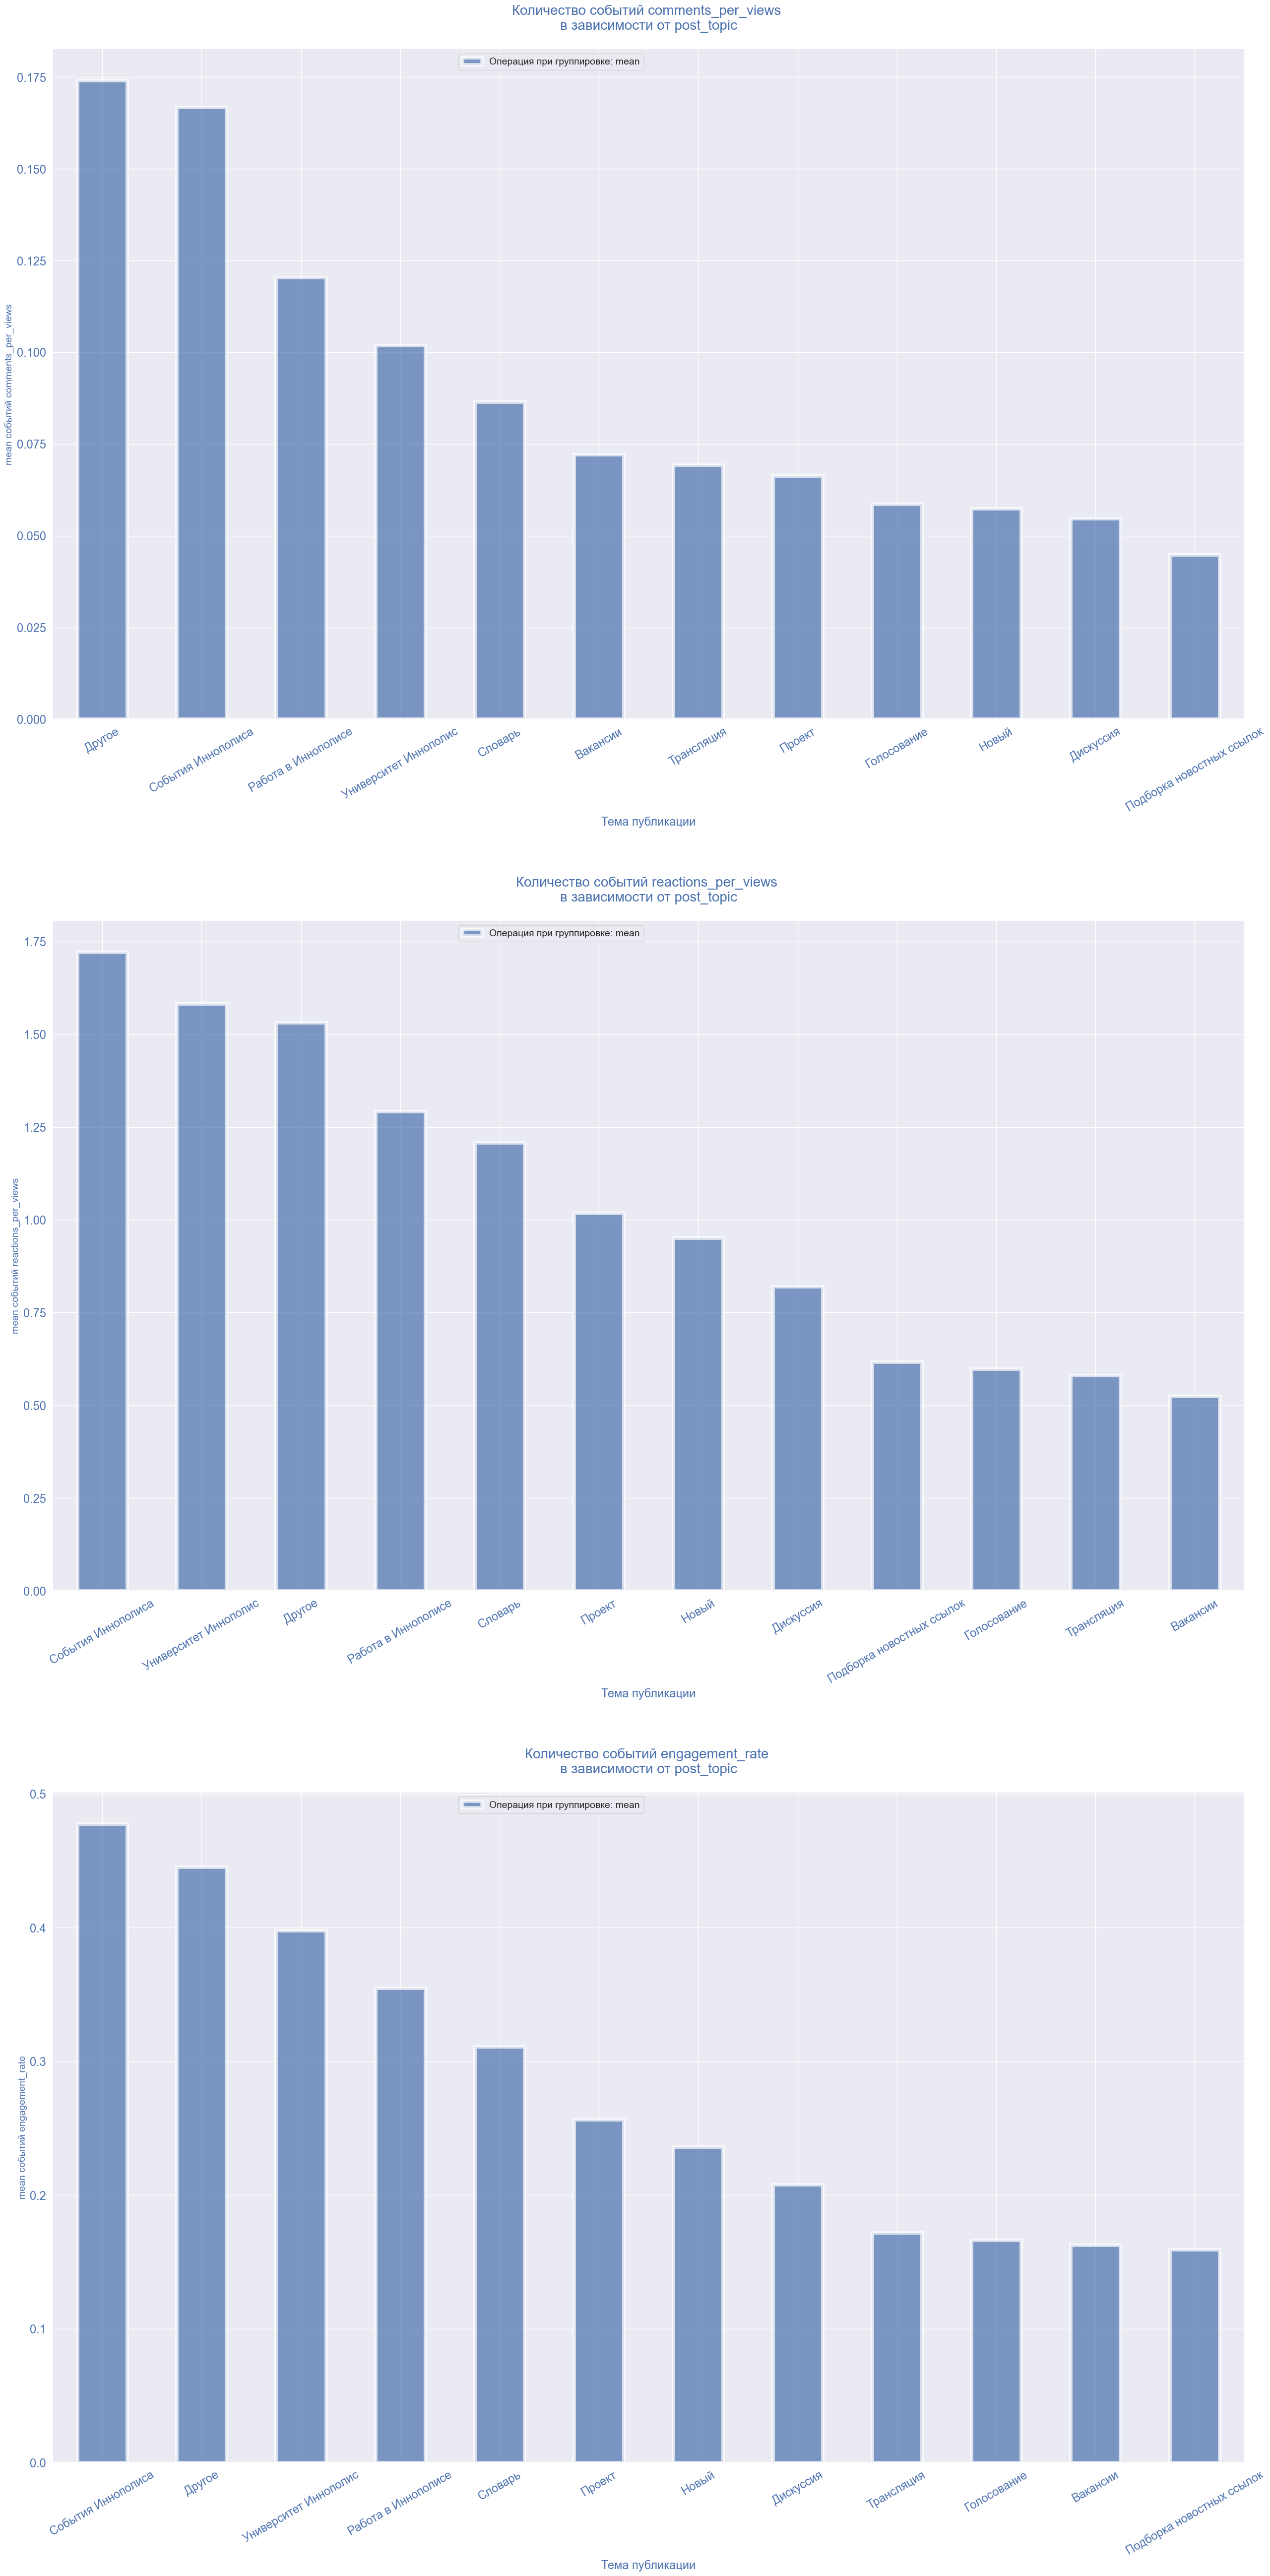

In [129]:
# в первой ячейке строим распределение по ERR по комментариям
ax1 = plt.subplot(3, 1, 1)
# вызываем функцию
event_in_group(innopolistg_emoji, 'comments_per_views', 'post_topic', 'mean', ax1, 31, 33, 'Тема публикации')

# во второй ячейке строим распределение по ERR по реакциям
ax2 = plt.subplot(3, 1, 2)
# вызываем функцию
event_in_group(innopolistg_emoji, 'reactions_per_views', 'post_topic', 'mean', ax2, 31, 35,'Тема публикации')

# в третьей ячейке строим распределение по агрегрированной ERR
ax3 = plt.subplot(3, 1, 3)
# вызываем функцию
event_in_group(innopolistg_emoji, 'engagement_rate', 'post_topic', 'mean', ax3, 31, 35,'Тема публикации')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
Как видно из графиков, наиболее интересующими читателей темами являются События Иннополиса и Университет Иннополиса. Меньше вовлеченности в постах на темы Подборка новостных ссылок, Вакансии, Голосование. При использовании различных метрик результаты отличаются незначительно.

### Зависимость популярности поста от типа поста

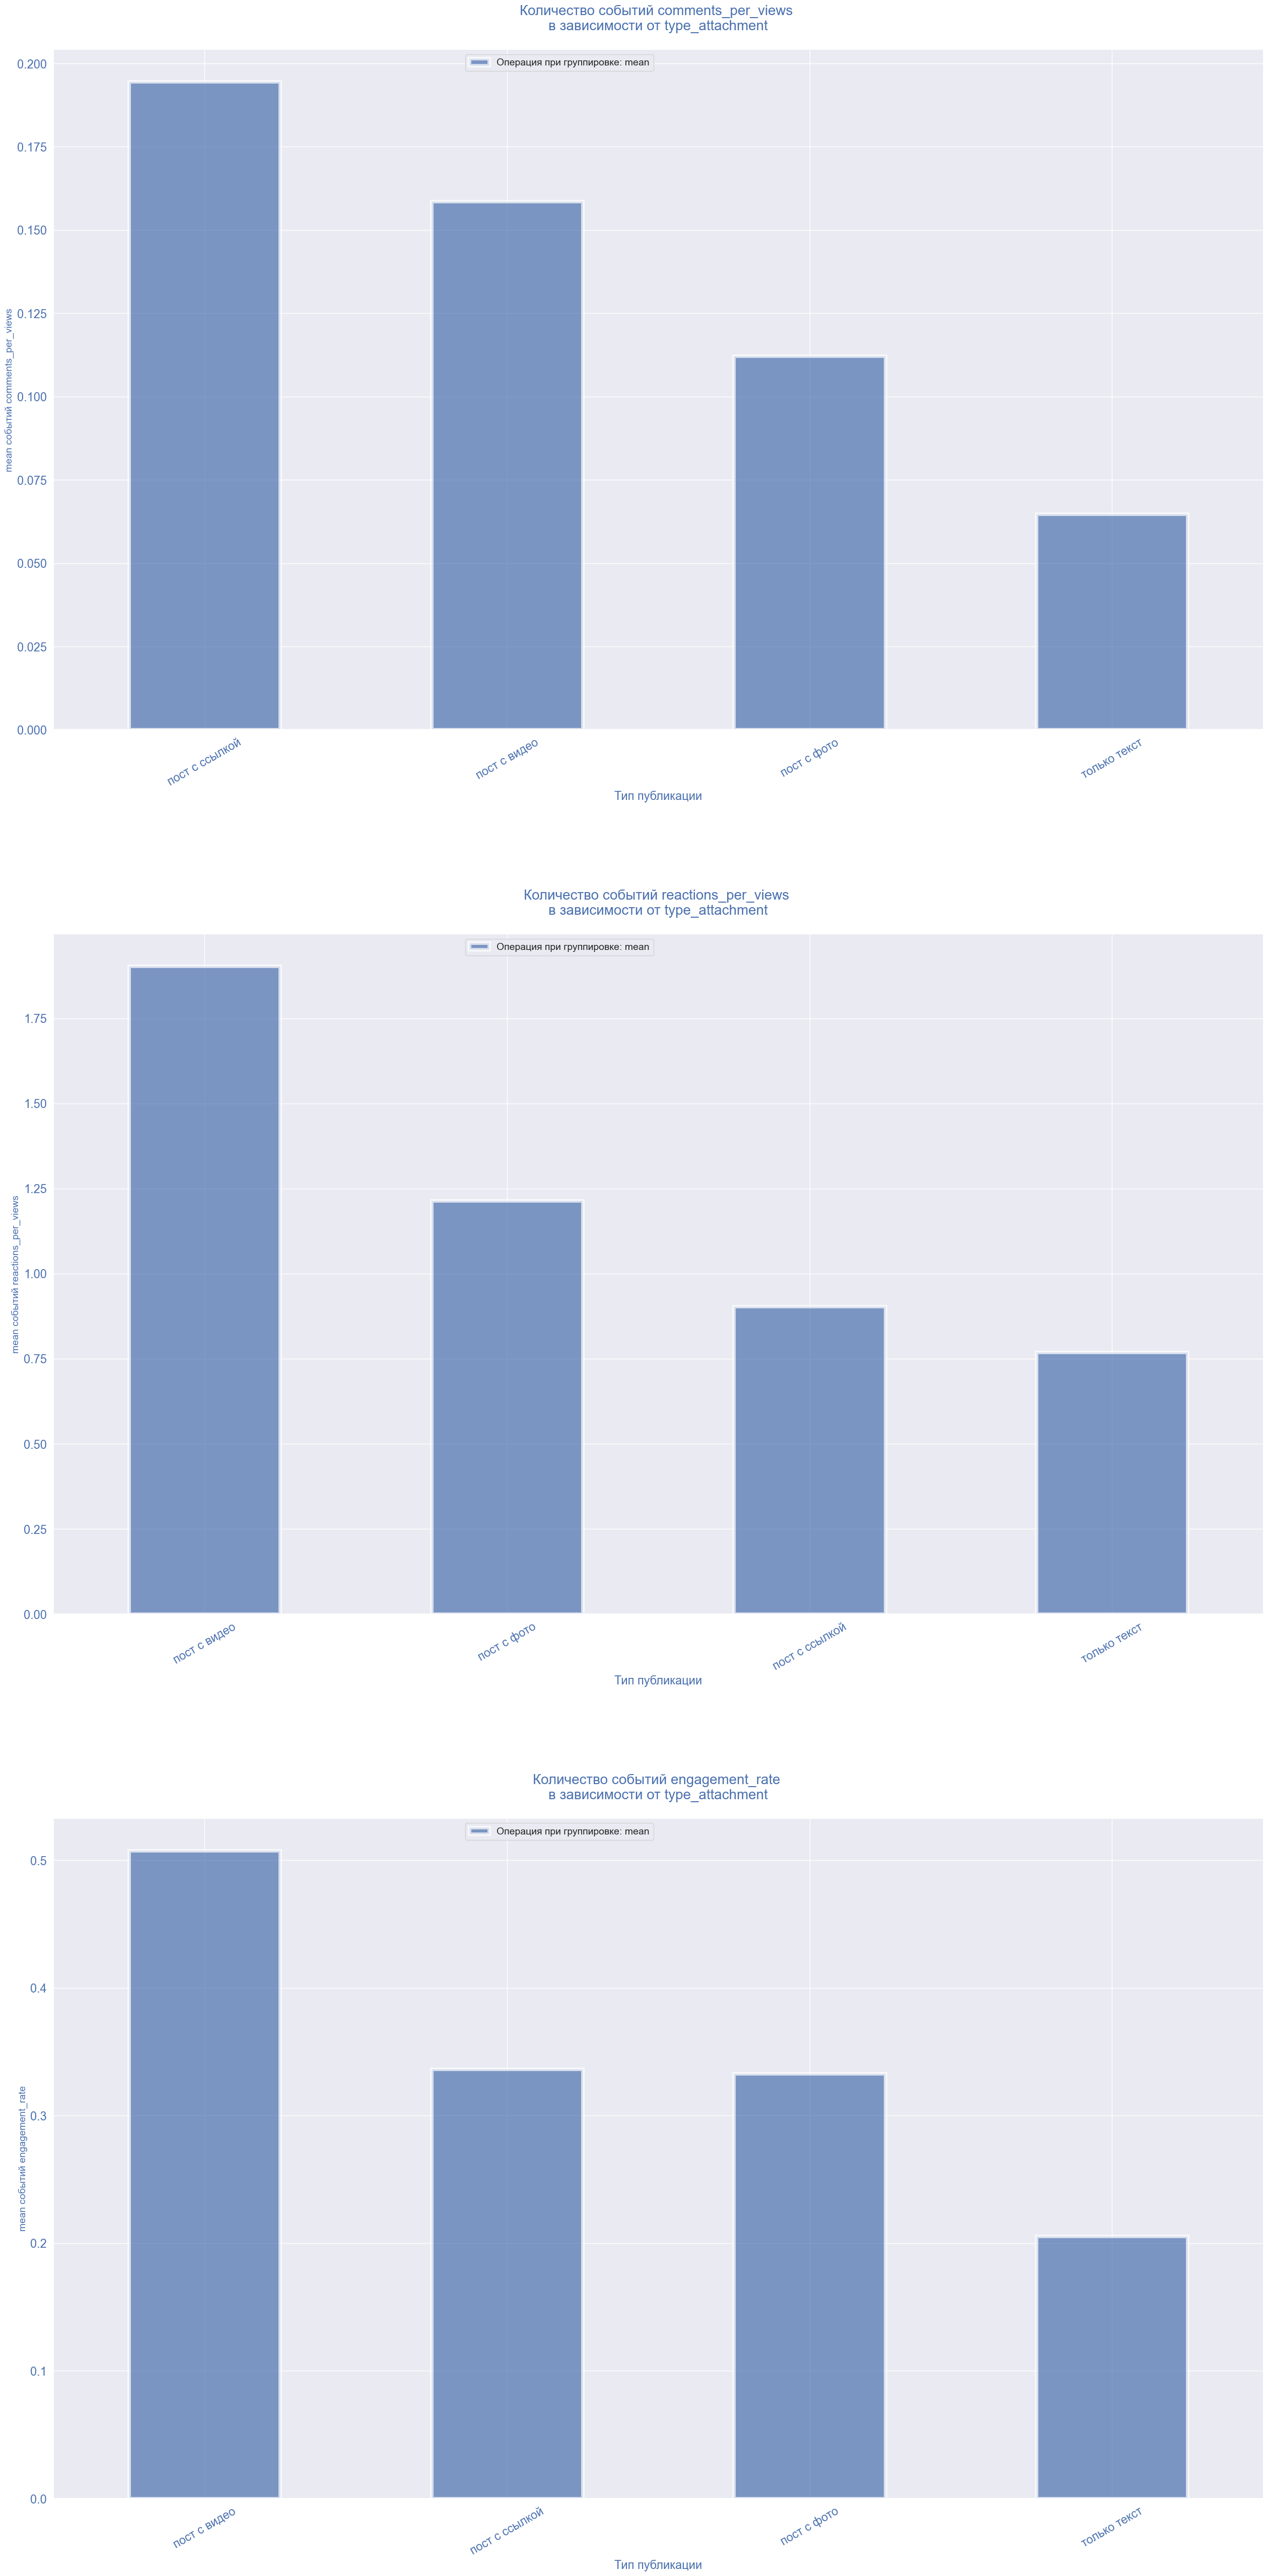

In [130]:
# в первой ячейке строим распределение по ERR по комментариям
ax1 = plt.subplot(3, 1, 1)
# вызываем функцию
event_in_group(innopolistg_emoji, 'comments_per_views', 'type_attachment', 'mean', ax1, 31, 33,'Тип публикации')

# во второй ячейке строим распределение по ERR по реакциям
ax2 = plt.subplot(3, 1, 2)
# вызываем функцию
event_in_group(innopolistg_emoji, 'reactions_per_views', 'type_attachment', 'mean', ax2, 31, 35,'Тип публикации')

# в третьей ячейке строим распределение по агрегрированной ERR
ax3 = plt.subplot(3, 1, 3)
# вызываем функцию
event_in_group(innopolistg_emoji, 'engagement_rate', 'type_attachment', 'mean', ax3, 31, 35,'Тип публикации')



<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
При использовании любой выбранной нами метрики публикации, в которых есть только текст, вызывают наименьший отклик у аудитории. А вот посты с видео набирают большое количество и реакций, и комментариев. Стоит отметить, что публикации с приложенной ссылкой вызывают дискуссию в комментариях (их здесь больше всего). Таким образом, интерактивные посты эффективнее привлекают пользователей.  

### Зависимость популярности поста от количества популярных слов в посте

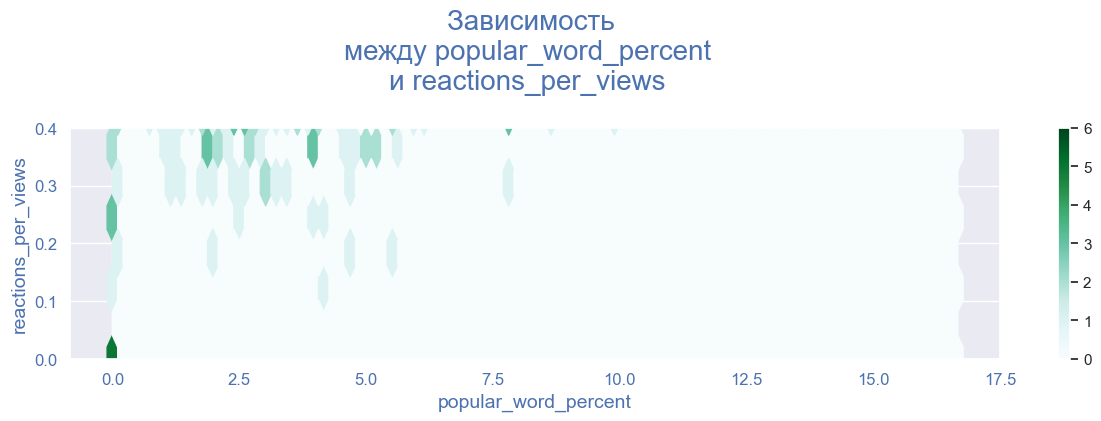

Козффициент корреляции между popular_word_percent  
и reactions_per_views   = -0.1


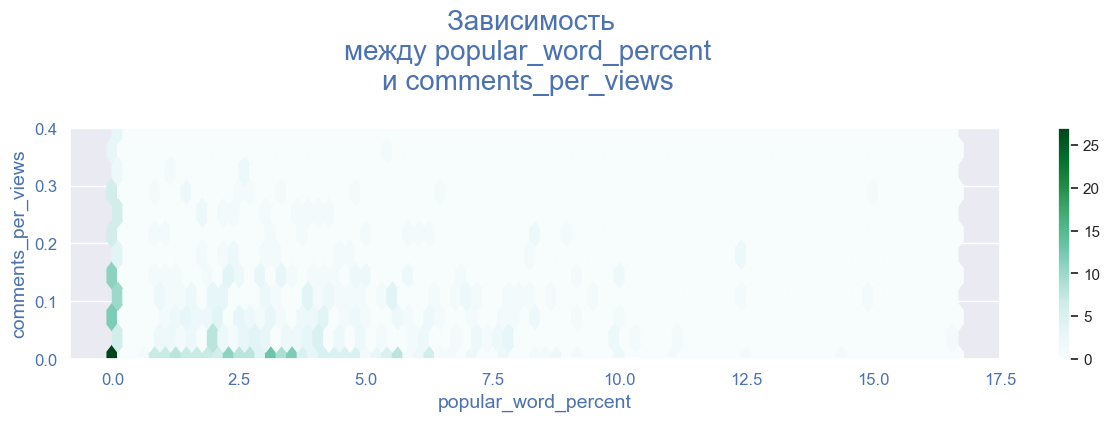

Козффициент корреляции между popular_word_percent  
и comments_per_views   = -0.02


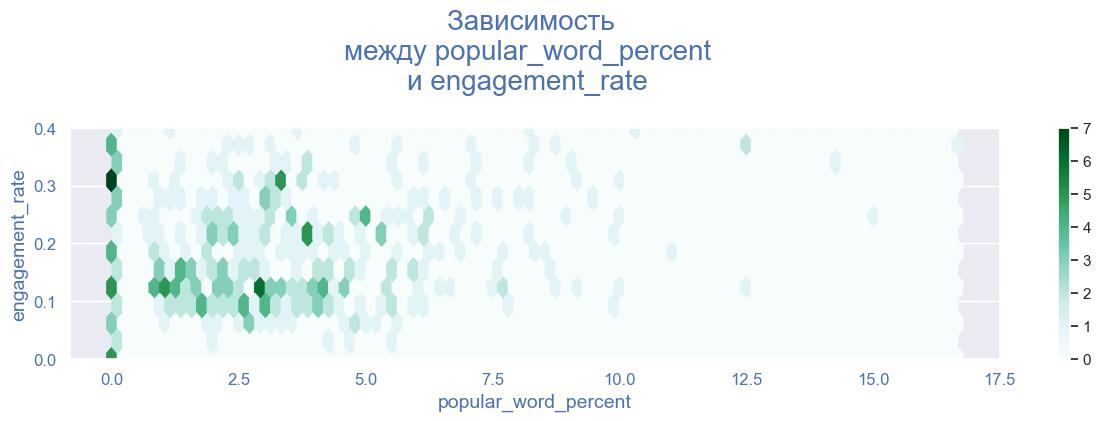

Козффициент корреляции между popular_word_percent  
и engagement_rate   = -0.07


In [131]:
for i in ['reactions_per_views','comments_per_views',  'engagement_rate']:
    corr_score_sales('popular_word_percent', i, 0, 150, 0.4, ax)

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
Графики показали очень слабую взаимосвязь между метриками эффективности и количеством популярных слов в посте.

Изучим тематику популярных и непопулярных публикаций. Так как у нас небольшое количество постов для анализа, выберем первые 15 и последние 15 публикаций, предварительно отсортировав по агрегирующей метрике вовлеченности.

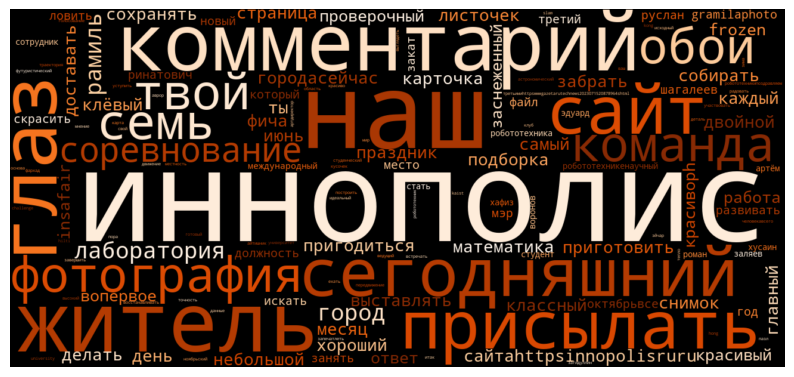

In [132]:
# выберем самые популярные посты
top_15 = innopolistg_emoji.sort_values(by='engagement_rate', ascending=False).head(15)

# объединили посты в одну переменную
top_word_cloud = ' '.join(top_15['text'].tolist())

top_word_cloud = prepare_text(top_word_cloud)

# соберем текст
top_word_cloud_text = ' '.join(top_word_cloud)

# создание облака слов
wordcloud = WordCloud(width=1300, height=600, background_color='black', colormap='Oranges_r').generate(top_word_cloud_text)

# Отображение облака слов
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

(-0.5, 1299.5, 599.5, -0.5)

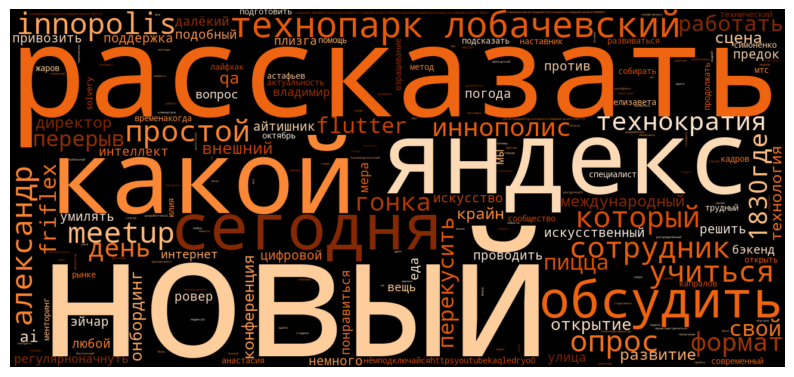

In [133]:
# выберем самые непопулярные посты
foot_15 = innopolistg_emoji.sort_values(by='engagement_rate').head(15)

# объединили посты в одну переменную
foot_word_cloud = ' '.join(foot_15['text'].tolist())

foot_word_cloud = prepare_text(foot_word_cloud)

# соберем текст
foot_word_cloud_text = ' '.join(foot_word_cloud)

# создание облака слов
wordcloud = WordCloud(width=1300, height=600, background_color='black', colormap='Oranges_r').generate(foot_word_cloud_text)

# Отображение облака слов
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
На первом облаке слов указаны наиболее часто встречающиеся слова из 15-ти популярных постов. Тематика данных постов носит скорее новостной характер, здесь много слов Сегодняшний, Житель и Иннополис. Также стоит отметить слова Присылать и Комментарий, скорее всего это публикации с призывом к действию активничать на канале, что является эффективным методом привлечения пользователей. Публикации с подборками и карточками, различными полезными ресурсами вызывают спрос у читателей. А вот контент образовательного характера, в особенности в IT-сфере, интересует пользователей в меньшей степени, это видно на облаке слов, построенном на словах из постов с низким уровнем вовлеченности.

### Семантический анализ комментариев к постам

In [134]:
# слова, которые свидетельствуют о желании переехать
word_about_moving = ['переехать', 'к вам попасть', 'хотела жить', 'город мечты', 'переезд']

# подготовим текст комментариев и слов
comments_innopolistg['word_about_moving_count'] = comments_innopolistg['text_comment'].apply(lambda x: count_popular_words(x,word_about_moving))

In [135]:
# вывод комментариев
pd.set_option('display.max_colwidth', None)
comments_innopolistg[comments_innopolistg['word_about_moving_count']>0]

post_id              date_comment  \
181      1272 2023-10-12 01:05:05+00:00   
356      1175 2023-09-07 15:20:41+00:00   
358      1175 2023-09-07 15:39:32+00:00   
367      1168 2023-09-02 14:12:44+00:00   
374      1162 2023-09-01 11:35:27+00:00   
544      1047 2023-07-23 14:05:05+00:00   
1088      883 2023-05-11 22:55:59+00:00   
1226      808 2023-03-31 17:45:23+00:00   
1409      728 2023-02-12 14:20:38+00:00   
1490      680 2023-01-20 18:08:02+00:00   
1501      673 2023-01-16 16:39:36+00:00   
1573      627 2022-12-20 22:37:47+00:00   
1698      528 2022-11-24 16:46:25+00:00   
1801      467 2022-10-25 17:09:35+00:00   
2160      193 2022-06-16 04:09:47+00:00   
2252      177 2022-06-10 02:44:28+00:00   
2257      177 2022-06-10 10:46:08+00:00   
2505       68 2022-05-05 07:37:53+00:00   

                                                                                                                                                                                                                                                                                                                                                                                     text_comment  \
181                                                                                                                                                                                                                                                                                                               Очень Хочу к вам переехать. Но квартир в аренду практически нет. И работы мало😔   
356                                                           Добрый день. Подскажите, есть ли в Иннополисе студии по изучению английского языка? И есть ли потребность в его изучении у жителей? \n\nМне очень нравится Иннополис, и я бы хотела жить в вашем городе. Как можно к вам попасть и переехать туда?\n\n Я бы с удовольствием открыла бы у вас студию для изучения английского языка.   
358                                                                                                                                                                                          У нас проводятся занятия по английскому, но постоянной студии нет. \n\nДля переезда нужно работать в местной компании или открыть свой бизнес.\n\nА в ваши успехи в пайтоне мы верим всем городом! 💪   
367                                                                                                                                                                                                                                                                                                                                                                как переехать в новый корпус?)   
374                                                                                                                                                                                                                                                                                                       Мне нравится как развивается этот город хоть в нём и не живу\n(~вывод это город мечты~)   
544                                                                                                                                                                                                                                                                                                                                                                       что мешает переехать :)   
1088                                                                                                                                                                                                                                                                                  Здравствуйте, я управленец с 14 лет опытом. Очень хочу переехать в Иннополис. Есть ли вакансии такого рода?   
1226                                                                        

In [136]:
pd.reset_option('^display.', silent=True)

In [137]:
# список номеров постов
post_id = comments_innopolistg[comments_innopolistg['word_about_moving_count']>0]['post_id'].tolist()

# отфильтруем датафрейм
data = innopolistg_emoji[innopolistg_emoji['id'].isin(post_id)]

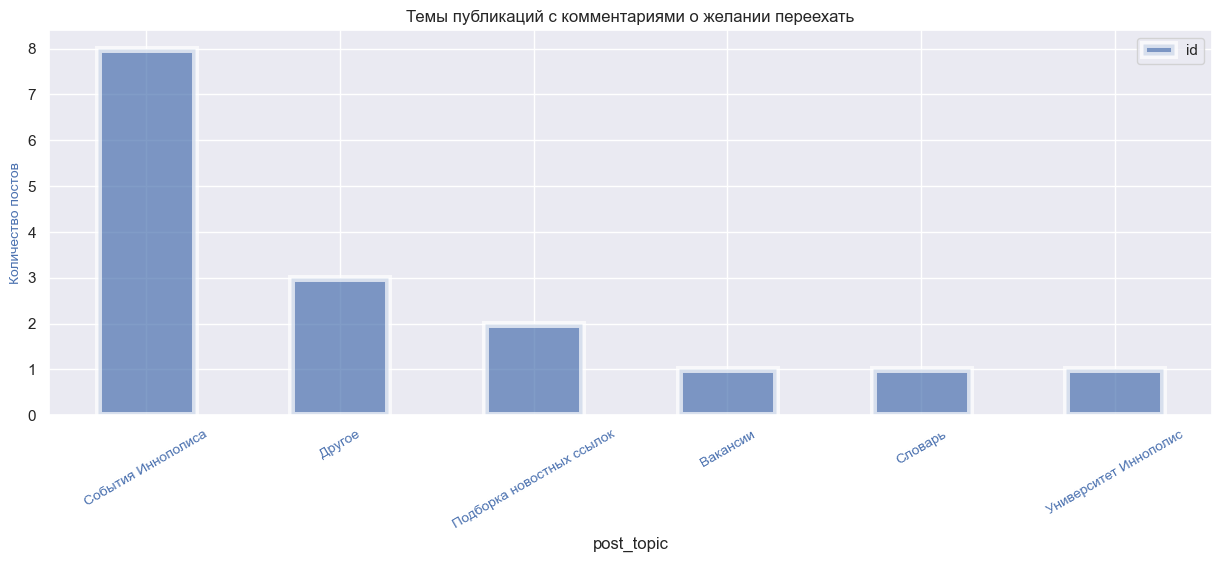

In [138]:
t1 = data.groupby('post_topic').agg({'id':'nunique'}).sort_values('id', ascending=False)

ax = t1.plot(figsize=(15,5),
             kind ='bar',
             y = 'id',
             linewidth=5,
             alpha=0.7)
plt.title('Темы публикаций с комментариями о желании переехать')
plt.xticks(rotation=30, fontsize=10, color = "b")
plt.ylabel('Количество постов', fontsize=10, color = "b")
plt.show()

<div style="border-radius: 45px; border:solid green 7px; padding: 40px">
Комментариев на тему переезда достаточно мало. Тем не менее, они наблюдаются под постами, связанными с Университетом Иннополис и вакансиями, что является вполне логичным. Рубрика События Иннополиса чаще вызывает у людей желание переехать в город.

При анализе комментариев была выявлена жилищная проблема, которая останавливает людей от переезда в Иннополис.

<a id="6"></a>
## Анализ эмодзи

Проведем Анализ эмодзи. Посчитаем количество эмодзи в зависимости от темы, типа публикаций, использованных слов, объема текста, сложностью текста.  
При возможности установим зависимость от положительных и отрицательных эмодзи.  

- выявим полный список эмодзи
- составим список положительных, отрицательных и нейтральных эмодзи
- посчитаем количество положительных, отрицательных и нейтральных эмодзи
- добавим в датафрейм столбцы с количеством положительных, отрицательных и нейтральных эмодзи для каждой публикации
- построим столбчатые диаграммы, отражающие распределение эмодци в разрезе:
 - темы публикации
 - типа публикации
 - использованных слов
 - времени публикации
 - объема текста


### Выявим полный список эмодзи

In [139]:
df2 = innopolistg_emoji

In [140]:
df2['reactions'][1]

"{'_': 'MessageReactions', 'results': [{'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '❤\\u200d🔥'}, 'count': 14, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '🔥'}, 'count': 8, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '👍'}, 'count': 5, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionCustomEmoji', 'document_id': 5310156831581020580}, 'count': 5, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '🎄'}, 'count': 2, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '💯'}, 'count': 1, 'chosen_order': None}, {'_': 'ReactionCount', 'reaction': {'_': 'ReactionEmoji', 'emoticon': '👀'}, 'count': 1, 'chosen_order': None}], 'min': False, 'can_see_list': False, 'recent_reactions': []}"

In [141]:
df2.columns

Index(['id', 'date', 'text', 'views', 'reactions_count', 'comments',
       'type_attachment', 'reactions', 'post_topic', 'popular_word_count',
       'simbols_in_text', 'words_in_text', 'avg_word_len', 'punct_marks',
       'marks_per_text', 'popular_word_percent', 'year', 'month', 'weekday',
       'weekday_name', 'hour', 'times_of_day', 'days_cnt',
       'comments_per_views', 'reactions_per_views', 'engagement_rate'],
      dtype='object')

In [142]:
df2

id                      date  \
0    1421 2023-12-06 15:41:17+00:00   
1    1420 2023-12-05 09:01:58+00:00   
2    1415 2023-12-04 18:15:49+00:00   
3    1414 2023-12-04 12:31:49+00:00   
4    1407 2023-12-01 17:40:01+00:00   
..    ...                       ...   
534    34 2022-03-02 15:18:58+00:00   
535    32 2022-03-01 16:20:00+00:00   
536    31 2022-03-01 16:12:39+00:00   
537    28 2022-03-01 16:12:20+00:00   
538    21 2022-03-01 16:11:03+00:00   

                                                  text   views  \
0    2023 год подходит к концу. И мы вспоминаем сам...  2294.0   
1    В поисках новых подарков Дед Мороз заглянул в ...  2116.0   
2    В первую неделю зимы слушаем классическую музы...  2175.0   
3    1. Университет Иннополис [открыл штаб-квартиру...  2391.0   
4    Провели дискуссию о будущем туризма в Иннополи...  2819.0   
..                                                 ...     ...   
534  UPD: вышел [Указ Президента\n\n](http://public...  1366.0   
535  @mintsifry разработало меры для поддержки IT-с...  1244.0   
536  Собрали все наши соцсети в одном месте. Присое...   938.0   
537  Пост-напоминание, что Иннополис — место не тол...   788.0   
538  Истории трёх сотрудниц Университета Иннополис,...   702.0   

     reactions_count  comments type_attachment  \
0                 45         4     пост с фото   
1                 36         6     пост с фото   
2                 22         3     пост с фото   
3                 38         0     пост с фото   
4                 52         2     пост с фото   
..               ...       ...             ...   
534               14         0    только текст   
535               10         0     пост с фото   
536               11         0     пост с фото   
537                7         0     пост с фото   
538               12         0     пост с фото   

                                             reactions  \
0    {'_': 'MessageReactions', 'results': [{'_': 'R...   
1    {'_': 'MessageReactions', 'results': [{'_': 'R...   
2    {'_': 'MessageReactions', 'results': [{'_': 'R...   
3    {'_': 'MessageReactions', 'results': [{'_': 'R...   
4    {'_': 'MessageReactions', 'results': [{'_': 'R...   
..                                                 ...   
534  {'_': 'MessageReactions', 'results': [{'_': 'R...   
535  {'_': 'MessageReactions', 'results': [{'_': 'R...   
536  {'_': 'MessageReactions', 'results': [{'_': 'R...   
537  {'_': 'MessageReactions', 'results': [{'_': 'R...   
538  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                    post_topic  popular_word_count  ...  year  month  weekday  \
0           События Иннополиса                   5  ...  2023     12        2   
1        Университет Иннополис                   3  ...  2023     12        1   
2           События Иннополиса                   1  ...  2023     12        0   
3    Подборка новостных ссылок                   2  ...  2023     12        0   
4                    Дискуссия                   4  ...  2023     12        4   
..                         ...                 ...  ...   ...    ...      ...   
534                     Другое                   1  ...  2022      3        2   
535        Работа в Иннополисе                   6  ...  2022      3        1   
536  Подборка новостных ссылок                   0  ...  2022      3        1   
537         События Иннополиса                   3  ...  2022      3        1   
538      Университет Иннополис                   1  ...  2022      3        1   

     weekday_name  hour  times_of_day  days_cnt  comments_per_views  \
0       Wednesday    15          день       1.0               0.174   
1         Tuesday     9          утро       1.0               0.284   
2          Monday    18         вечер       1.0               0.138   
3          Monday    12          день       NaN               0.000   
4          Friday    17          день       1.0               0.071   
..            ...   ...           ...       ... 

In [143]:
import ast #


Библиотека ast (Abstract Syntax Trees) в Python используется для преобразования строк, содержащих литералы Python (например, строки словарей, списков, кортежей и т. д.), в соответствующие объекты Python. Она обычно применяется для безопасного преобразования строковых представлений в Python-объекты.

В вашем случае вы использовали ast.literal_eval(), который принимает строку и пытается интерпретировать её как литерал Python, возвращая соответствующий объект. В примере с обработкой CSV файла, вы использовали ast.literal_eval() для преобразования строковых представлений словарей в фактические словари Python, чтобы было возможно работать с этими данными как с объектами Python.

Создадим датафрейм `parsed_data`, в который занесем количество эмодзи для каждого поста в разрезе видов эмодзи

In [144]:
# Новая таблица для хранения распаршенных данных
parsed_data = pd.DataFrame(columns=['id', 'emodzi', 'cnt_emodzi'])

# Функция для парсинга словарей в отдельные колонки и заполнения новой таблицы
def parse_reactions(row):
    parsed_rows = []
    try:
        reactions = ast.literal_eval(row['reactions'])
        for reaction in reactions['results']:
            emoji = reaction['reaction'].get('emoticon', None)
            count = reaction['count']
            parsed_rows.append({'id': row['id'], 'emodzi': emoji, 'cnt_emodzi': count})
    except Exception as e:
        print(f"Error: {e}")
    return parsed_rows

# Применение функции к каждой строке и заполнение новой таблицы
for index, row in df2.iterrows():
    parsed_rows = parse_reactions(row)
    parsed_data = pd.concat([parsed_data, pd.DataFrame(parsed_rows)], ignore_index=True)

Error: malformed node or string: nan
Error: malformed node or string: nan
Error: malformed node or string: nan
Error: malformed node or string: nan
Error: malformed node or string: nan


Посмотрим, что получилось:

In [145]:
parsed_data


id emodzi cnt_emodzi
0     1421      🔥         25
1     1421   None          5
2     1421      👍          4
3     1421      ❤          4
4     1421      👏          3
...    ...    ...        ...
2839    28      🔥          2
2840    28      👎          1
2841    21      👍          7
2842    21      🔥          3
2843    21      👎          2

[2844 rows x 3 columns]

Посчитаем - всего у нас 39 видов уникальных эмодзи

In [146]:
parsed_data.emodzi.nunique()

39

Как они выглядят?

In [147]:
parsed_data.emodzi.unique()

array(['🔥', None, '👍', '❤', '👏', '👎', '🏆', '🆒', '😎', '❤\u200d🔥', '🎄', '💯',
       '👀', '🥰', '🍓', '💘', '✍', '🎅', '🎉', '😍', '🦄', '☃', '⚡', '🤣', '😁',
       '🍾', '🤔', '🤝', '🌚', '🐳', '🗿', '😐', '👻', '👾', '👨\u200d💻', '👌', '🤓',
       '😈', '🙏', '🤗'], dtype=object)

### Cоставим список положительных, отрицательных и нейтральных эмодзи

Создадим списки положительных, отрицательных и нейтральных эмодзи и категоризируем их


Создадим функцию `categorize_purpose_100`

In [148]:
def categorize_purpose_100(total_income):
    #print ('total_income = ', total_income)

    positive_roll = ['🔥', '👍', '❤', '👏',  '🏆', '🆒', '😎', '❤\u200d🔥', '🎄', '💯',
        '🥰', '🍓', '💘', '🎅', '🎉', '😍', '☃', '⚡', '🤣', '😁',
       '🍾', '🤝', '🐳', '👻',  '👌', '🤓',
       '😈', '🙏', '🤗']

    negative_roll = ['👎']

    neutral_roll = [ None,
       '👀', '✍', '🦄',
       '🤔', '🌚', '🗿', '😐', '👾', '👨\u200d💻'
       ]

    for positive in positive_roll:
        if total_income == positive:
            return 'positive'

    for negative in negative_roll:
        #print ('estate = ', estate)
        if total_income == negative:
            return 'negative'

    for neutral in neutral_roll:
        #print ('estate = ', estate)
        if total_income == neutral:
            return 'neutral'


Применим функцию и посмотрим, что получилось

In [149]:
parsed_data['purpose_category'] = parsed_data['emodzi'].apply(categorize_purpose_100)
#проверим на дубликаты
print (parsed_data['purpose_category'].isna().sum())

0


In [150]:
parsed_data

id emodzi cnt_emodzi purpose_category
0     1421      🔥         25         positive
1     1421   None          5          neutral
2     1421      👍          4         positive
3     1421      ❤          4         positive
4     1421      👏          3         positive
...    ...    ...        ...              ...
2839    28      🔥          2         positive
2840    28      👎          1         negative
2841    21      👍          7         positive
2842    21      🔥          3         positive
2843    21      👎          2         negative

[2844 rows x 4 columns]

### Разобьем датафрейм и затем объединим методом `concat`.
Получим для каждого поста количество положительных, отрицательных и нейтральных оценок

Разобъем датафрейм.  
Выделим из него фреймы в разрезе реакций

In [151]:
def  emoji_types_vertical(mark):
    df = parsed_data.query('purpose_category == @mark').groupby('id').agg({'cnt_emodzi':'sum'}).reset_index()
    df['reaction_category'] = mark
    return(df)

In [152]:
df_positive_vert = emoji_types_vertical("positive")

In [153]:
df_negative_vert = emoji_types_vertical("negative")

In [154]:
df_neutral_vert = emoji_types_vertical("neutral")

In [155]:
df_negative_vert

id cnt_emodzi reaction_category
0     21          2          negative
1     28          1          negative
2     31          2          negative
3     32          2          negative
4     34          2          negative
..   ...        ...               ...
87  1320          4          negative
88  1324          1          negative
89  1368          1          negative
90  1406          1          negative
91  1421          1          negative

[92 rows x 3 columns]

In [156]:
final_df_vert = pd.concat([df_positive_vert, df_negative_vert, df_neutral_vert]).reset_index(drop=True)
final_df_vert

id cnt_emodzi reaction_category
0      21         10          positive
1      28          6          positive
2      31          9          positive
3      32          6          positive
4      34         12          positive
..    ...        ...               ...
882  1407         21           neutral
883  1414         11           neutral
884  1415          1           neutral
885  1420          6           neutral
886  1421          5           neutral

[887 rows x 3 columns]

### построим столбчатые диаграммы, отражающие распределение эмодци в разрезе:
- темы публикации
- типа публикации
- использованных слов
- времени публикации
- объема текста

#### Объединим для построения зависимости от темы и типа публикации

In [157]:
print(list(innopolistg_emoji))

['id', 'date', 'text', 'views', 'reactions_count', 'comments', 'type_attachment', 'reactions', 'post_topic', 'popular_word_count', 'simbols_in_text', 'words_in_text', 'avg_word_len', 'punct_marks', 'marks_per_text', 'popular_word_percent', 'year', 'month', 'weekday', 'weekday_name', 'hour', 'times_of_day', 'days_cnt', 'comments_per_views', 'reactions_per_views', 'engagement_rate']


In [158]:
df_100 = innopolistg_emoji[['id', 'type_attachment', 'post_topic', 'weekday', 'times_of_day']]\
        .merge(final_df_vert, on = 'id', how = 'outer')

#### Созадим функцию и построим графики

In [159]:
# строим групповую столбчатую диаграмму
def reaction_select(data_name, x_num, y_num):
    sns.set(rc={"figure.figsize":(15, 8)})
    sns.barplot(x=x_num, y=y_num, hue='reaction_category',  data=data_name)
    plt.title(f'Суммарное количество оценок \n в зависимости от Категории {x_num}\n в разрезе групп', fontsize=20, color = "b")
    plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
    plt.xticks(rotation=90, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    plt.xlabel(f'Категория {x_num}', fontsize=14, color = "b")
    plt.ylabel("Суммарное количество оценок \n", fontsize=14, color = "b")
    plt.grid(which='major', axis='y')

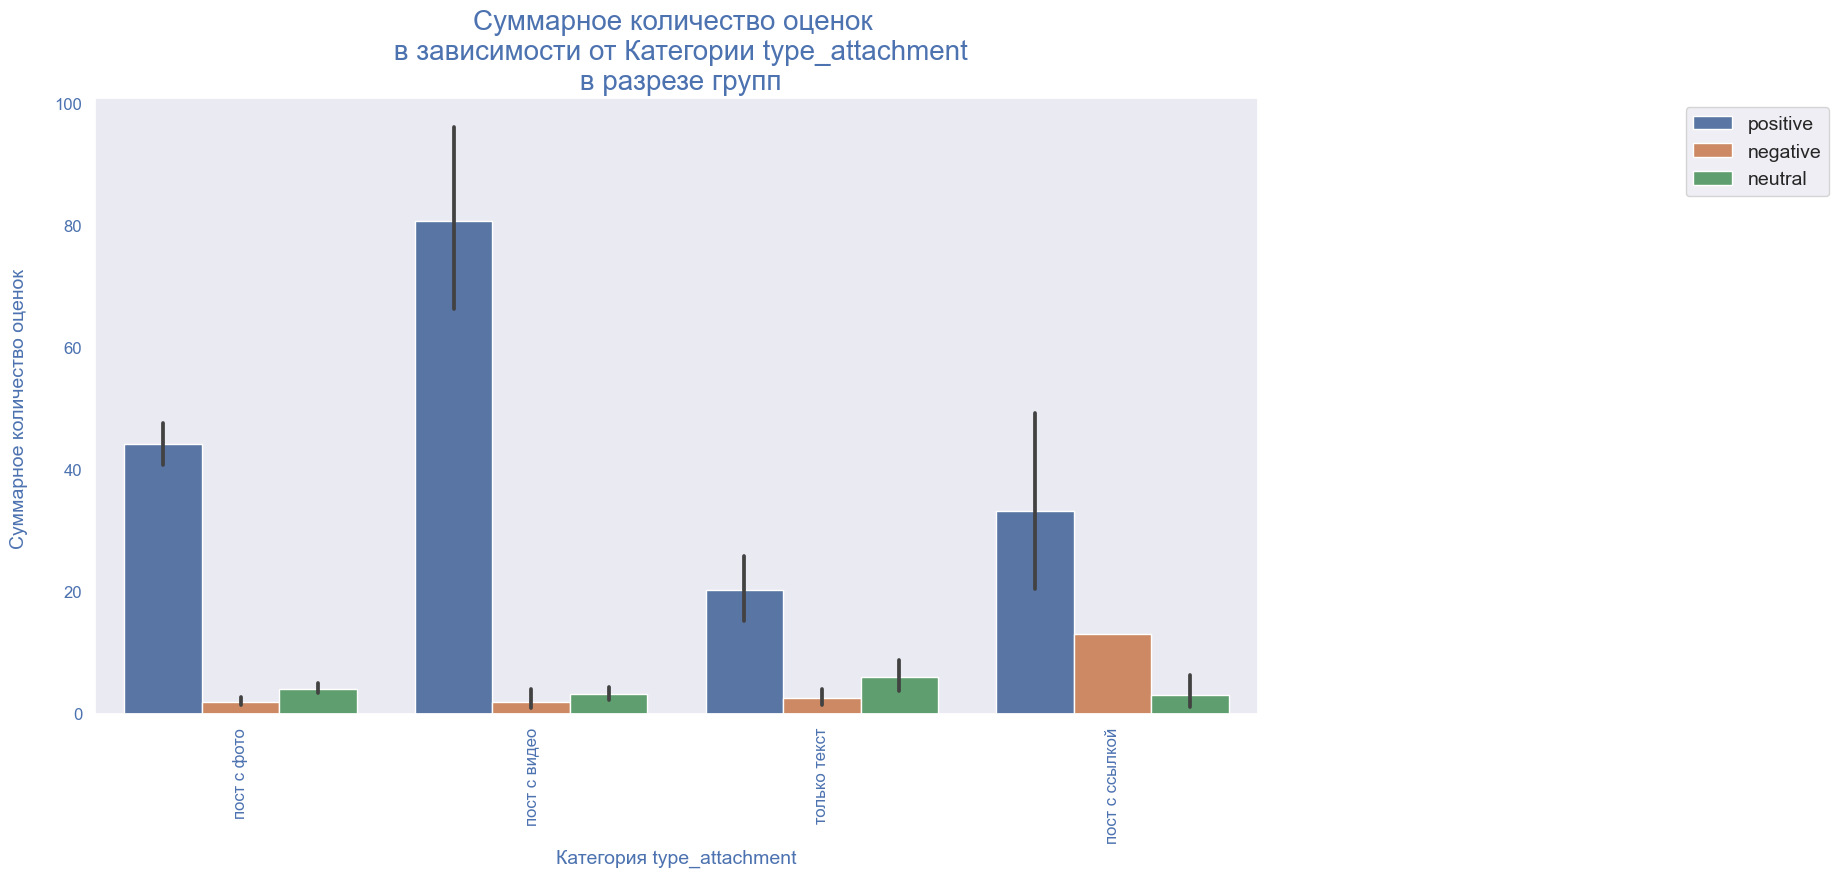

In [160]:
reaction_select(df_100, 'type_attachment', 'cnt_emodzi')

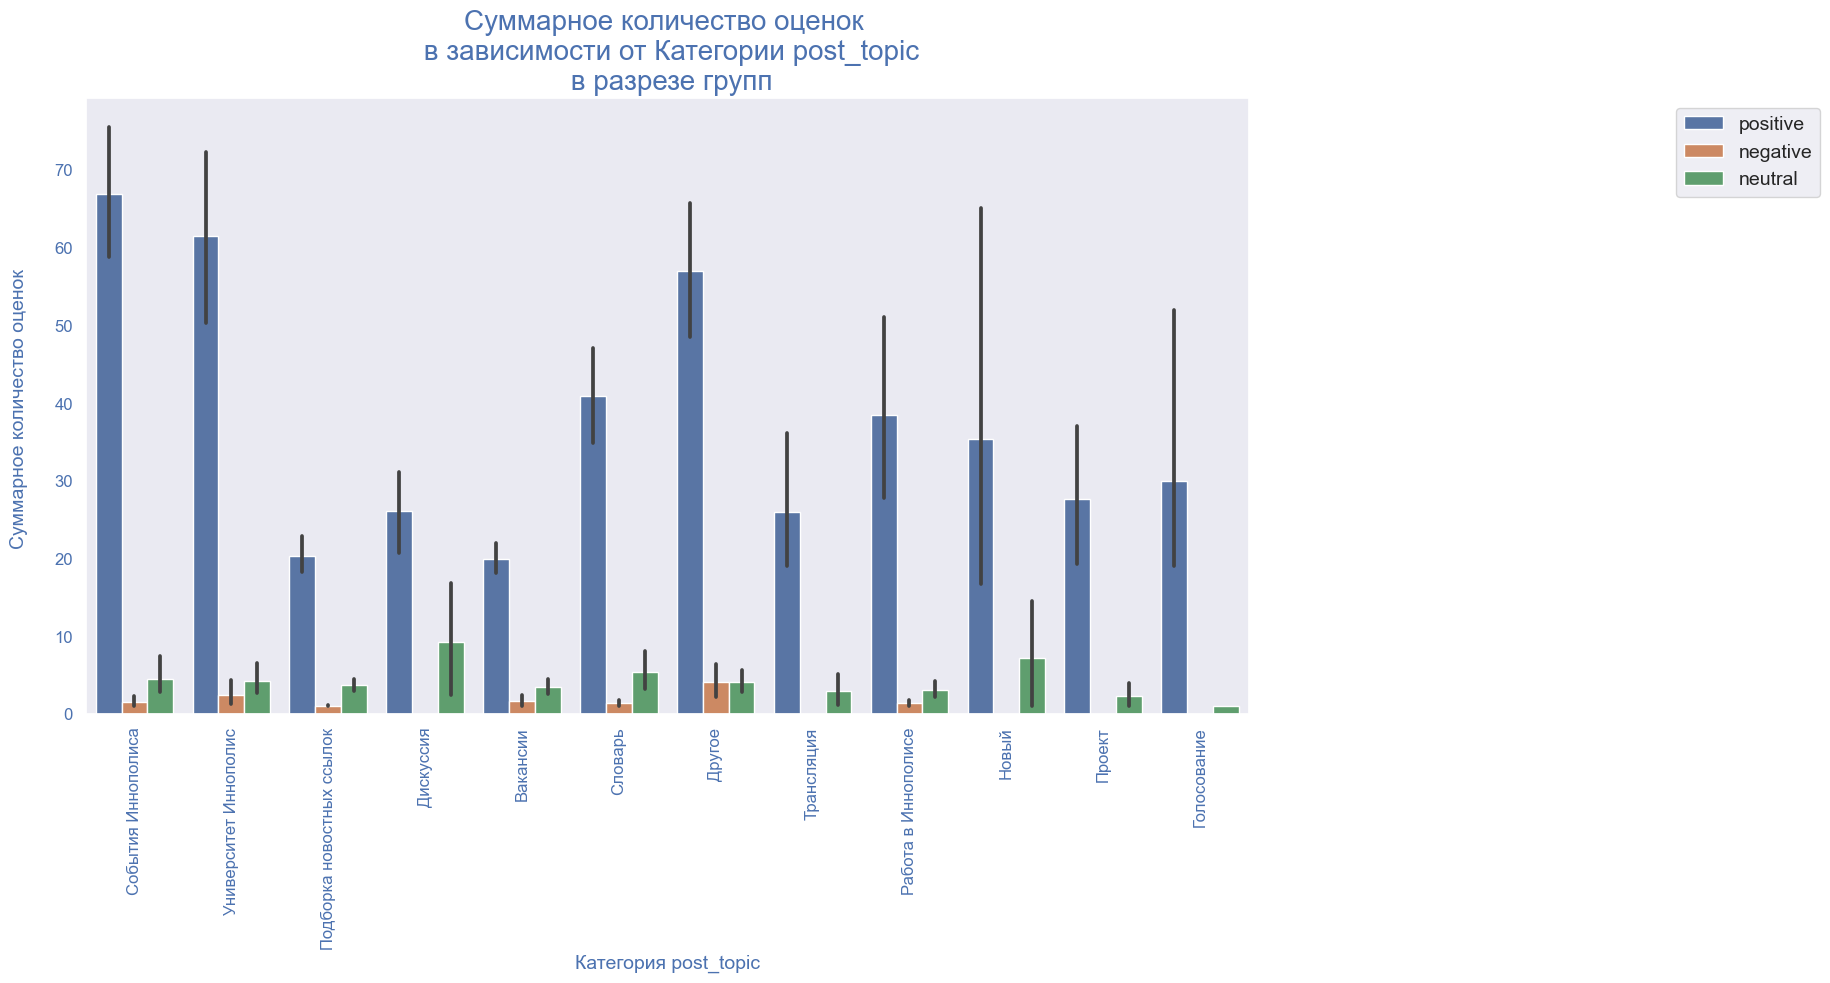

In [161]:
reaction_select(df_100, 'post_topic', 'cnt_emodzi')

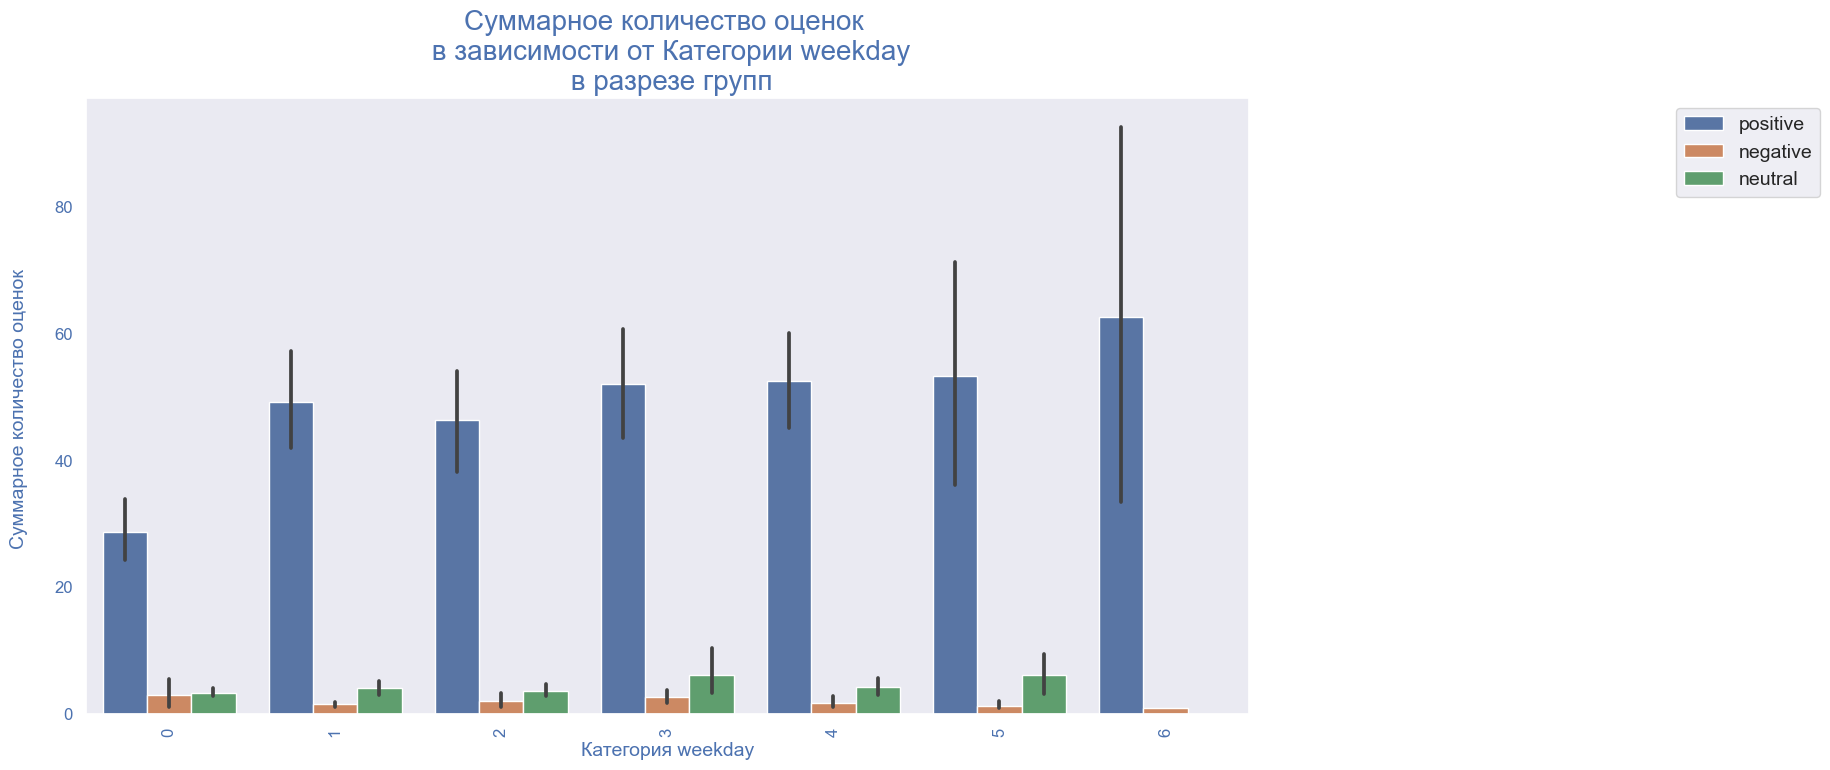

In [162]:
reaction_select(df_100, 'weekday', 'cnt_emodzi')

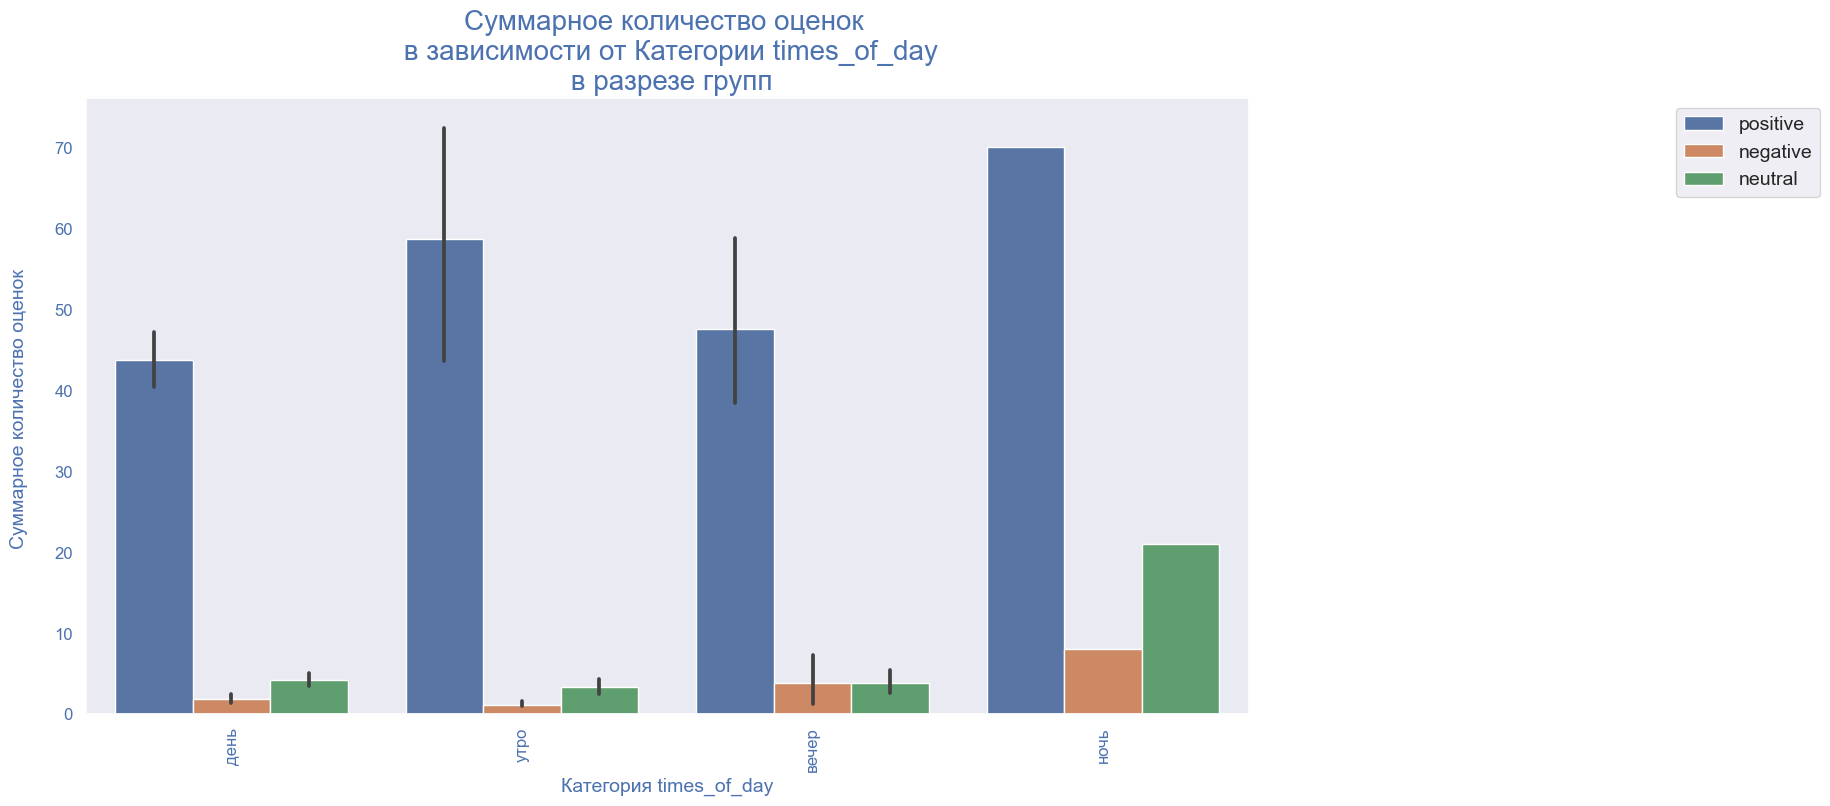

In [163]:
reaction_select(df_100, 'times_of_day', 'cnt_emodzi')

Обратим внимание, что рассматриваем мы здесь абсолютные показатели.

- Для зависимости от вида поста:
 - посты с видео имеют с своих ценках бОльшую долю положительных оценок над оценками отрицательными и нейтральными, нежели публикации с другими приложениями
- Для зависимости от темы публикации:
 - посты о событиях в Иннополисе и об Университете также имеют с своих ценках бОльшую долю положительных оценок над оценками отрицательными и нейтральными, нежели публикации с другими приложениями
- Такую же зависимость отметим для публикаций , выпущенных в воскресенье
- И для публикаций, выпущенных в ночное время.

<a id="7"></a>
## Рекомендации

### Использование более простых слов может увеличить число комментариев, реакций   и коэффициент вовлеченности
Необходимо перед публикацией проверять текст на сложность, учитывая данные аналитики: наилучшая средняя длина слова для длительности жизни - 4 символа. Наилучший диапазон - от 3,5 до 5 символов.

Построим гистограммы распределение частоты величины средней длины слова  и количества слов, приходящихся на один знак препинания

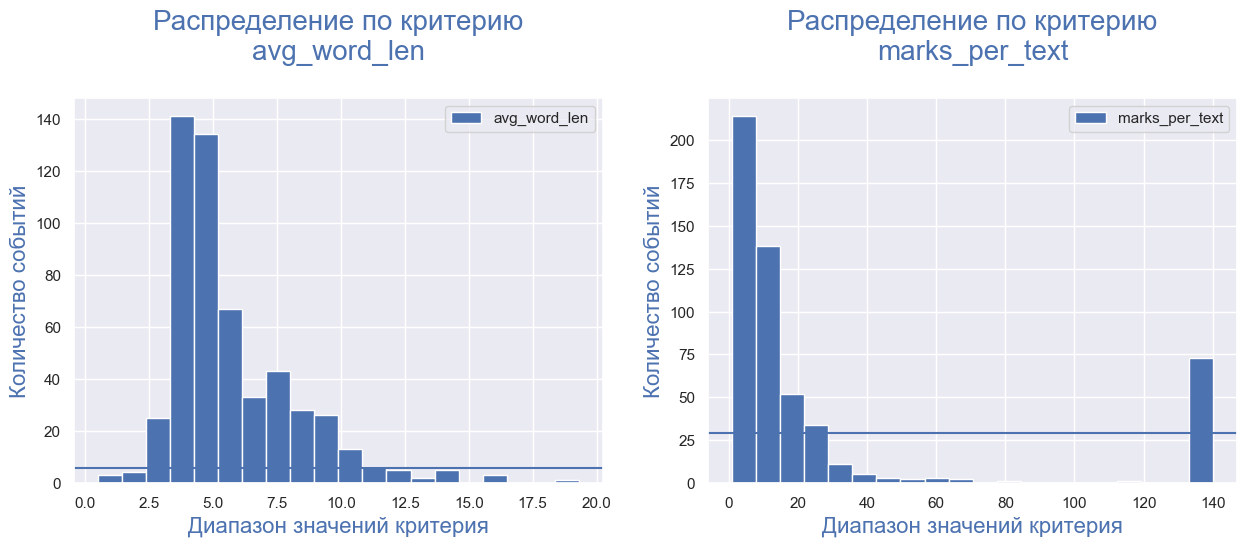

In [164]:
drow_hist('avg_word_len', 'marks_per_text')

Наиболее часто используемая длина слов - от 3 до 11 букв.

Округлим число букв в словах до целого в большую сторону

In [165]:
for i in tqdm(range(innopolistg_emoji.shape[0])):
    innopolistg_emoji.loc[(innopolistg_emoji.index == i), 'avg_word_len'] \
    = math.ceil(innopolistg_emoji.loc[(innopolistg_emoji.index == i), 'avg_word_len'])

100%|███████████████████████████████████████| 539/539 [00:00<00:00, 8454.93it/s]


Подправим под задачу созданную ранее функцию

In [166]:
# строим график, отражающий количество событий в зависимости от времени
# для сглаживания шумов применим скользящее среднее
def event_in_time_plot_10(data_name, eventname, time_interval):
    t1 = data_name.groupby(time_interval).agg({eventname:'mean'}).sort_values(time_interval)

    ax1 = t1.rolling(1).mean().plot(grid=True
        , figsize=(25,10)
        ,  color='g'
        , linewidth= 5
         )

    plt.title('Коэф.вовлеченности {} \nв зависимости от длины слова {}\n'.format(eventname, time_interval), fontsize=28, color = "b")
    plt.legend(fontsize=18, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=0, fontsize=20, color = "b")
    plt.yticks(rotation=0, fontsize=20, color = "b")
    plt.xlabel(f'{time_interval}', fontsize=20, color = "b")
    plt.ylabel(f"Коэф.вовлеченности {eventname}", fontsize=20, color = "b")
    #plt.show()
    return

Построим график зависимости коэффициента вовлеченности от средней длины слова в публикации

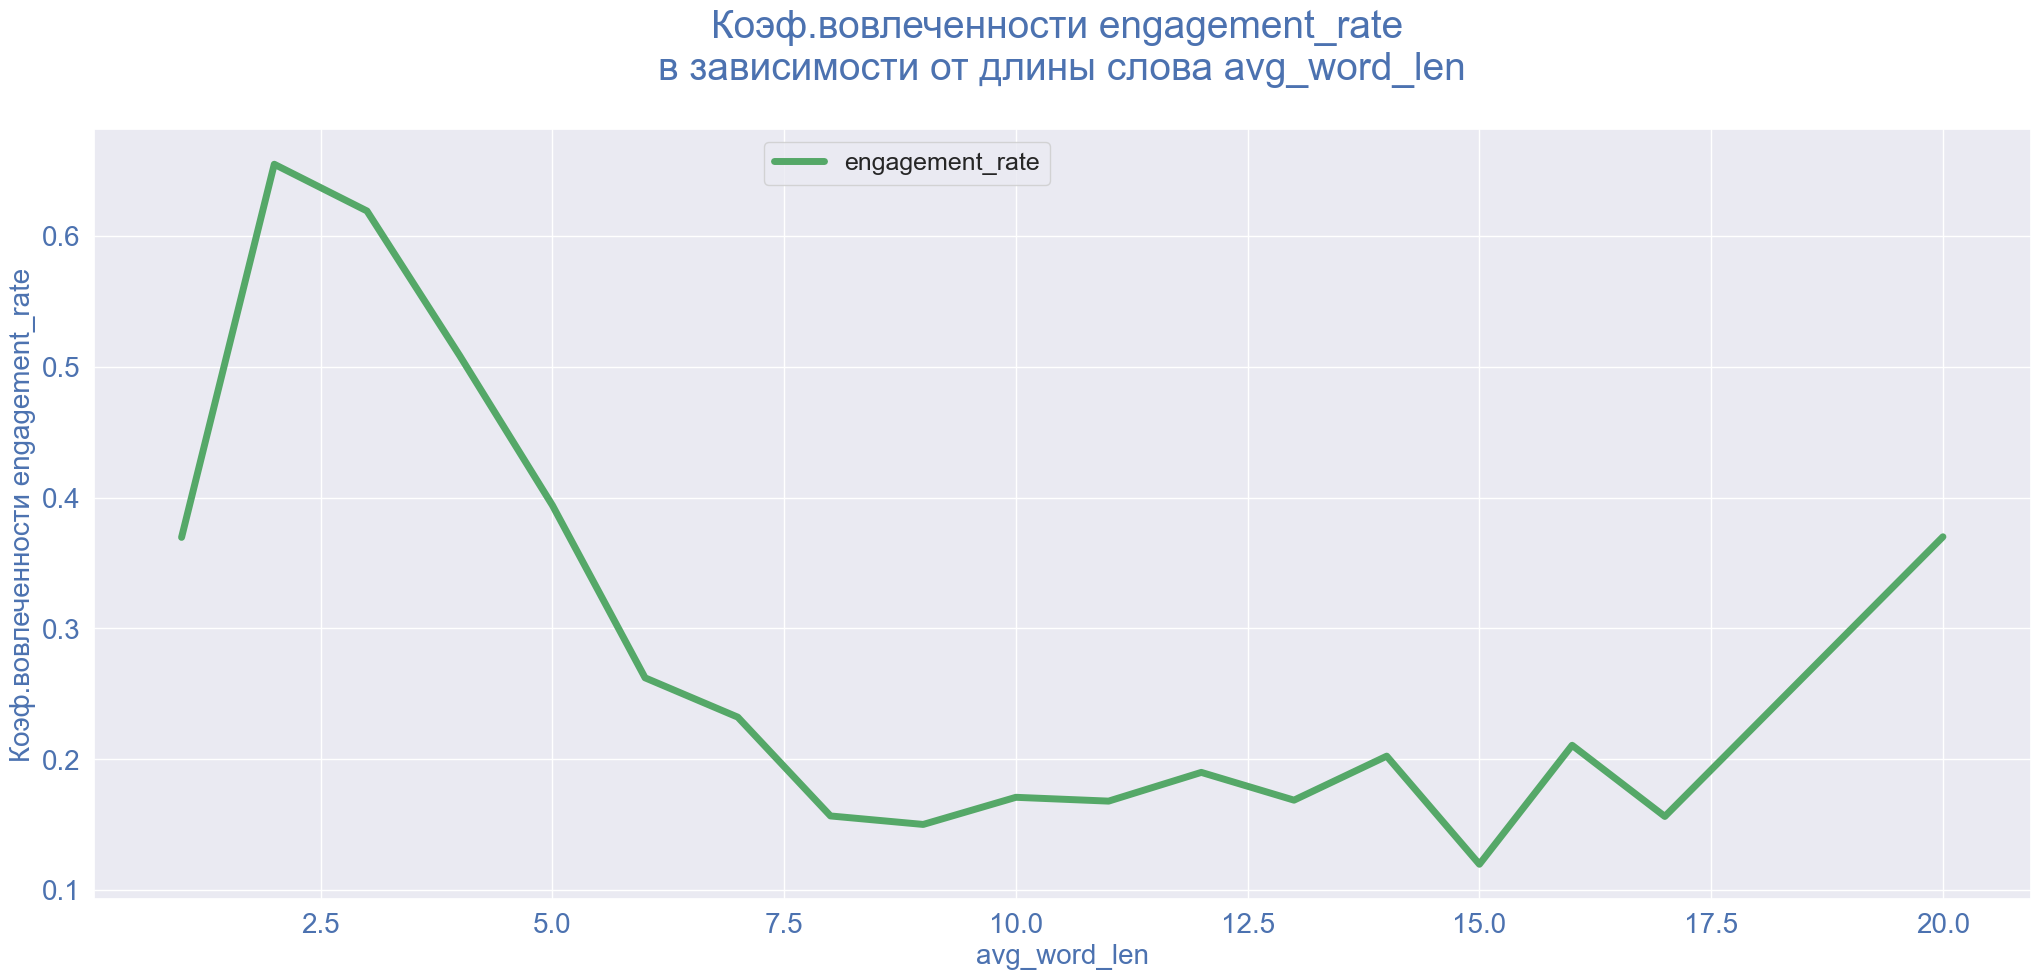

In [167]:
event_in_time_plot_10(innopolistg_emoji, 'engagement_rate', 'avg_word_len')

In [168]:
innopolistg_emoji.loc[(innopolistg_emoji['avg_word_len'] <= 5) & (innopolistg_emoji['avg_word_len'] >= 3.5)
                      , 'engagement_rate'].mean()

0.4345725631768953

In [169]:
innopolistg_emoji.loc[(innopolistg_emoji['avg_word_len'] <= 11) & (innopolistg_emoji['avg_word_len'] > 5)
                      , 'engagement_rate'].mean()

0.20499174311926607

Коэффициент вовлеченности при длине слова от 3,5 до 5 букв составляет 43,5%.  
Коэффициент вовлеченности при длине слова от 5  до 11 букв и более составляет 20,5%.  

Среднее количество букв менее 3 не рассматриваем, поскольку слова в этом случае могут быть выражены призывами, междометиями.

Мы не сможеи полностью избавиться от сдлинных слов.  
И тем не менее, разница в длине приводит к более, чем двукратному росту популярности.  Но это не означает, что если мы все-же перейдем только к коротким словам, популярность вырастет вдвое. Поскольку частота использования коротких слов уже сейчас больше, чем длинных.  
можно предположить, что сократив использование днинных слов на 10% мы увеличим популярность постов на 2%


### Использование более простого текста, без причастных оборотов, расшифровок может увеличить число  коэффициент вовлеченности
Необходимо перед публикацией проверять текст на сложность, учитывая данные аналитики: наилучшее для популярности поста число слов, приходящихся на один знак препинания, составляет 7 и больше.

Наиболее часто используемое количество слов на один знак препинаня - до 30 слов. Самое частое использование - 1 симол на менее, чем 7 слов.

Округлим параметр до целого в большую сторону

In [170]:
for i in tqdm(range(innopolistg_emoji.shape[0])):
    innopolistg_emoji.loc[(innopolistg_emoji.index == i), 'avg_word_len'] \
    = math.ceil(innopolistg_emoji.loc[(innopolistg_emoji.index == i), 'avg_word_len'])

100%|███████████████████████████████████████| 539/539 [00:00<00:00, 8828.29it/s]


Подправим под задачу созданную ранее функцию

Построим график зависимости коэффициента вовлеченности от количество слов, которые в каждой публикации приходится на один знак препинания

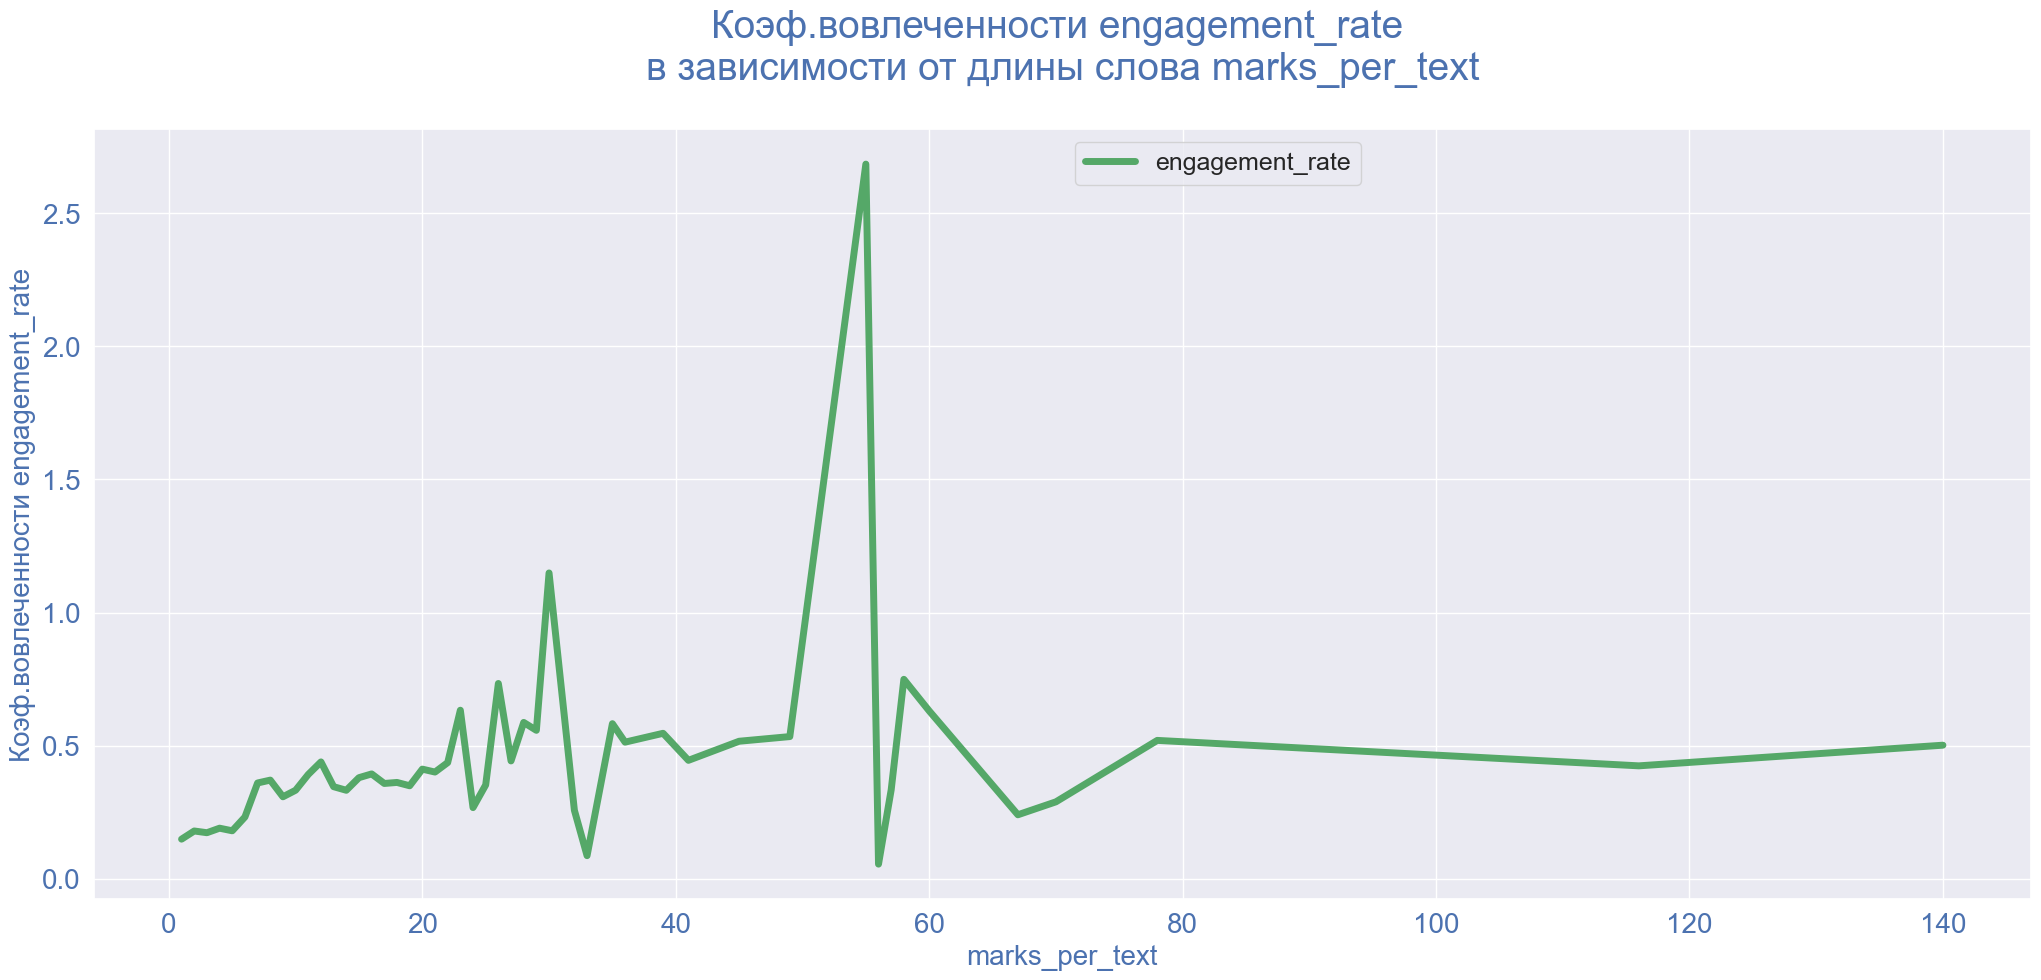

In [171]:
event_in_time_plot_10(innopolistg_emoji, 'engagement_rate', 'marks_per_text')

In [172]:
innopolistg_emoji.loc[(innopolistg_emoji['marks_per_text'] < 7)
                      , 'engagement_rate'].mean()

0.1896157894736842

In [173]:
innopolistg_emoji.loc[(innopolistg_emoji['marks_per_text'] >=7)
                      , 'engagement_rate'].mean()

0.41824871060171925

Коэффициент вовлеченности, если один знак препинаня приходится на 7 символов и более составляет 41,8%.  
Коэффициент вовлеченности, если один знак препинаня приходится на менее, чем 7 символов составляет 19,0%.   

разница в количестве знаков препинания приводит к более, чем двукратному росту популярности.  



### Публикации  в промежуток с 04.00 до 06.00, в 18.00 и в 21.00 увеличат коэффициент вовлеченности.
В публикациях учитывать время суток и  дни недели: посты, опубликованные в указанный период, набирают большую популярность.

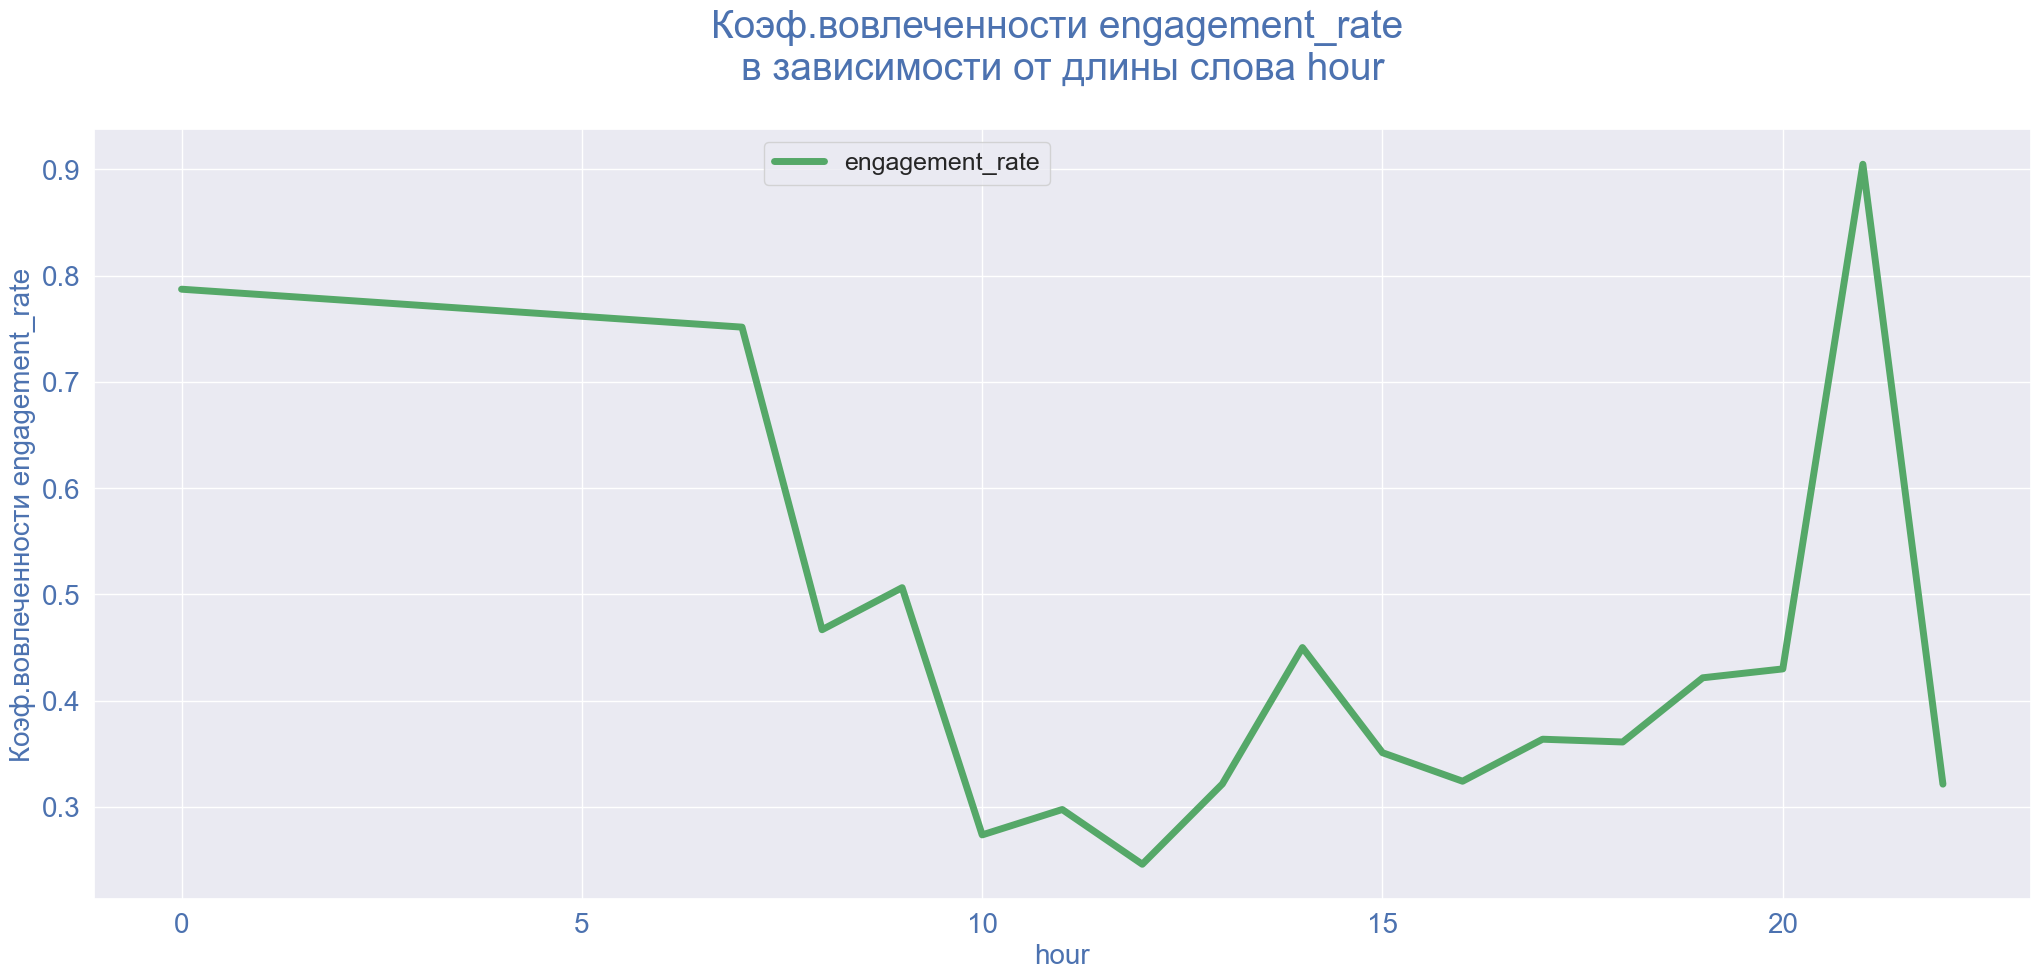

In [174]:
event_in_time_plot_10(innopolistg_emoji, 'engagement_rate', 'hour')

In [175]:
innopolistg_emoji.loc[(innopolistg_emoji['hour'] >=4) & (innopolistg_emoji['hour'] < 6)
                      | (innopolistg_emoji['hour'] >=18) & (innopolistg_emoji['hour'] < 21)
                       , 'engagement_rate'].mean()

0.3743098591549296

In [176]:
innopolistg_emoji.loc[(innopolistg_emoji['hour'] >=6) & (innopolistg_emoji['hour'] < 18)
                      | (innopolistg_emoji['hour'] >=21)
                       , 'engagement_rate'].mean()

0.3311190578158459

Коэффициент вовлеченности при публикации поста в промежуток времени с 04.00 до 06.00, и с 18.00 до 21.00  составляет 59,0%.  
Коэффициент вовлеченности при публикации поста в иное время  составляет 33,4%.  


Разница во времени публикации приводит к почти двукратному росту популярности.
В данном случае можно рекомендовать размещение в указанное время постов, имеющих в KPI заинтересованность в переезде, учебе, туризме.

### Публикации во вторник и в воскресенье  увеличат коэффициент вовлеченности.
В публикациях учитывать время суток и  дни недели: посты, опубликованные в указанный период, набирают большую популярность.

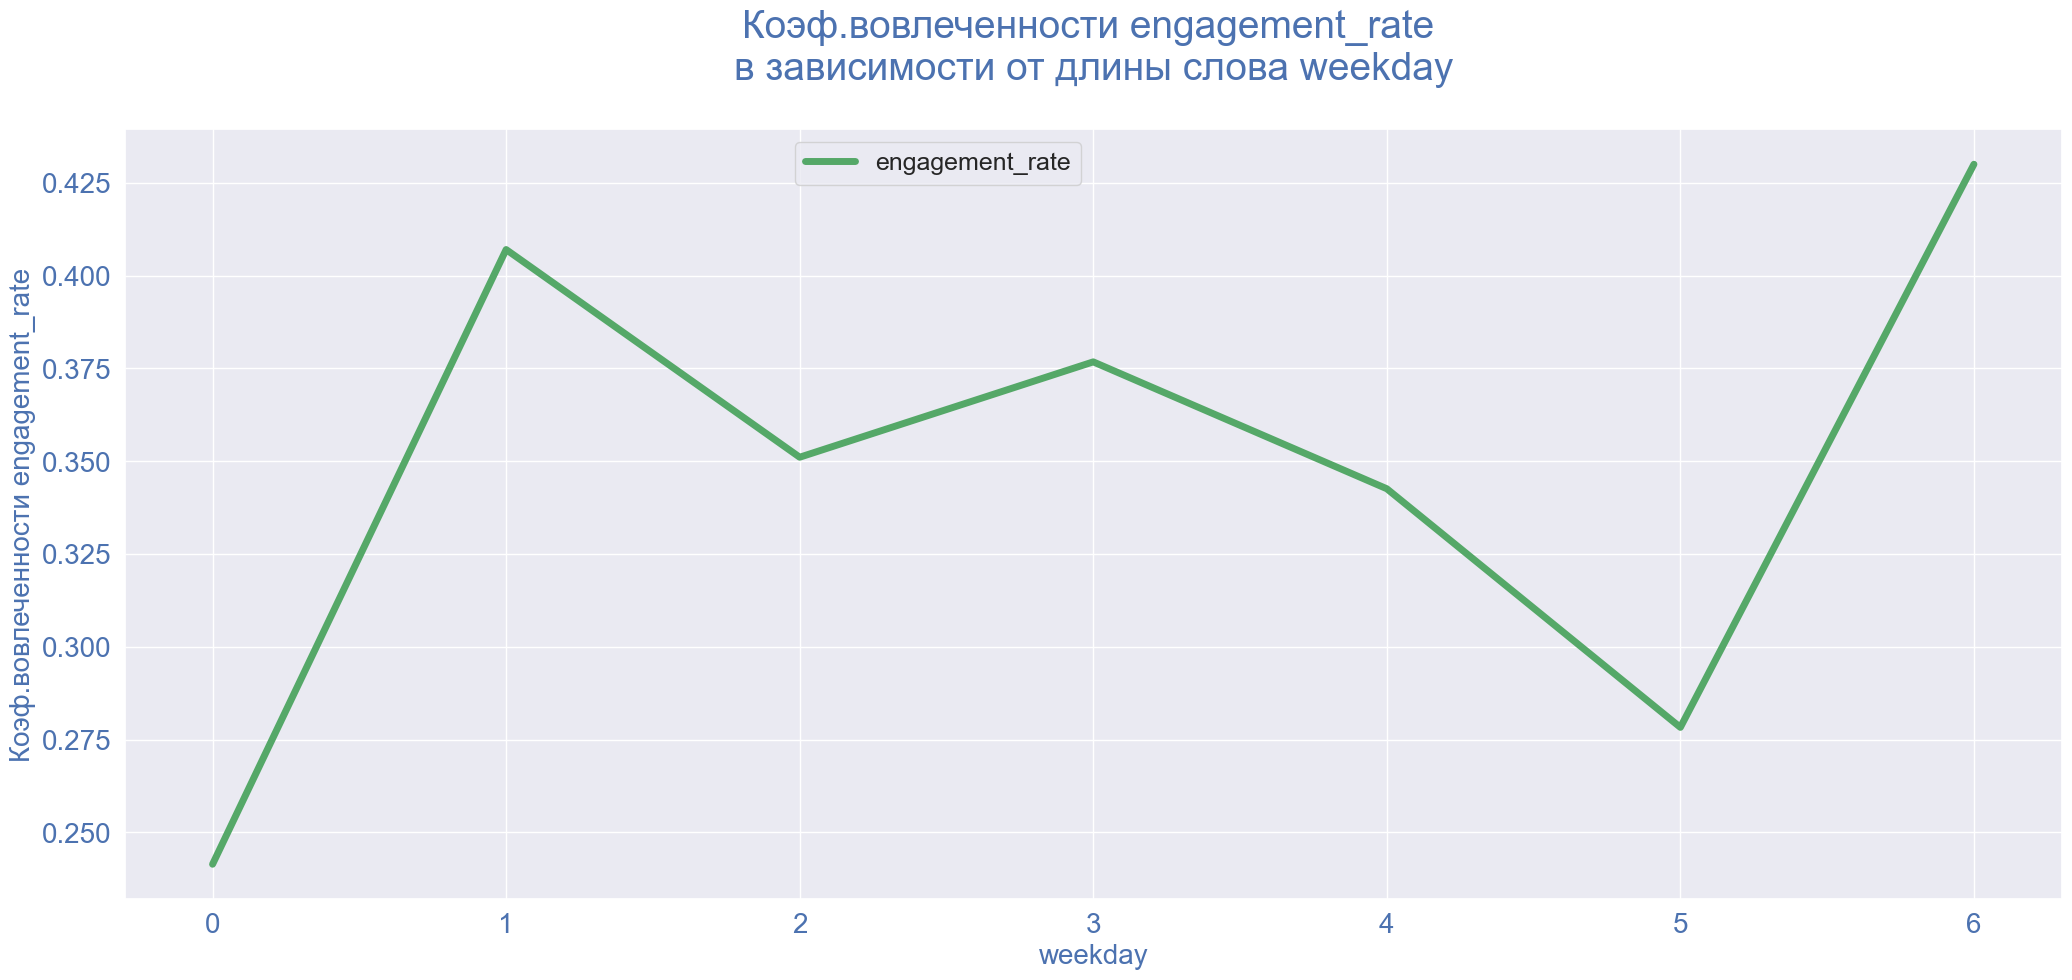

In [177]:
event_in_time_plot_10(innopolistg_emoji, 'engagement_rate', 'weekday')

In [178]:

innopolistg_emoji.loc[(innopolistg_emoji['weekday'] == 1) | (innopolistg_emoji['weekday'] == 6)
                       , 'engagement_rate'].mean()

0.4082727272727273

In [179]:
innopolistg_emoji.loc[~(innopolistg_emoji['weekday'] == 1) & ~(innopolistg_emoji['weekday'] == 6)
                       , 'engagement_rate'].mean()

0.31954731934731934

Коэффициент вовлеченности при публикации поста во вторник или в воскресенье  составляет 40,8%.  
Коэффициент вовлеченности при публикации поста в иной день недели  составляет 32,0%.  


Разница во времени публикации приводит к росту популярности на 30%.
В данном случае можно рекомендовать размещение в указанное время постов, имеющих в KPI заинтересованность в переезде, учебе, туризме.


## Выводы и заключения
### На этапе ознакомления и предобработки предоставленных данных:

- изучены 3 датафрейма, данные в которых достаточно "чистые" (практически нет пропусков и дубликатов),
- данные приведены к удобным для анализа форматам, наименования типа публикации были заменены на понятные для Заказчика значения,
- были выделены 14 тем публикаций,
- для понимания тематики канала, построено облако слов, из которого выделены 50 наиболее часто встречающихся,
- добавлены столбцы с объемом текста, количеством знаков препинания, количеством слов, которые в каждой публикации приходится на один знак препинания, средней длиной слова, количеством популярных слов в посте, с долей популяоных слов в посте, столбцы, указывающие на то или иное время публикации (год месяц, неделя, время суток), время жизни поста в днях,
- для анализа эффективности публикации были выбраны метрики: доля количества комментариев от количества просмотров поста, доля количества реакций (эмодзи) от количества просмотров поста, коэффициент вовлеченности (engagement rate), которые были рассчитаны и также добавлены в отдельные столбцы.<br>


### Исследовательский анализ предоставленных данных показал следующее:

Исследовательский анализ был разделен на несколько частей:
1) **исследование аномальных значений**. Обычно число комментариев составляет от 0,1 до 0,5% от просмотров, а количество реакций до 3% от просмотров. Тем не менее, встречаются публкации, у которых данные показатели значительно выше. Большинство "аномальных" постов посвящены жизни города, а также имеют мало текста и к ним приложены фото или видео.

2) **исследование временных характеристик**: количество коментариев к количеству просмотров как правило изменяется в сравнительно небольшом диапазоне от 0,05 до 0,2 процента. Всплески выражены в июне 2022 и мае-июне 2023 года, а вот количество реакций к количеству просмотров имеет довольно значительную амплитуду колебания диапазоне от 0,8 до 1,8 процента. Особенно заметны взлета и падения на протяжении всего 2023 года. Месяцы с увеличением числа реакций не совпадают с месяцами роста для комментариев. Видим, что читатели эмоционально реагировали в новогоднае праздники и летом 2023 года. В целом зависимость между популярностью поста и месяца/года незначительная. А вот связь между днем недели и популярностью поста прослеживается. Читатели наиболее активно комментрую посты, вышедшие во вторник, четверг и воскресенье, меньше всего комментариев к постам, вышедшим в субботу. Также читатели наиболее активно, с большим отрывом, комментрую посты, вышедшие в 18 часов, и совсем не комментируют посты, вышедшие в 19 и 20 часов и в промежуток с 22 часов до 4 часов. Наиболее вероятно, что в указанное время посты просто не публикуются. Что касается реакции на посты, то они распределены более равномерно по времени.

3) **исследование сложности текста:** для начала была описана типичная публикация. Она содержит до 120 слов, до 1100 символов (буквы, цифры, пробелы и символы), наиболее часто до 250 символов, средняя длина слова составляет от 3 до 8 символов, один знак препинаниня приходится на 25 символов. Была выявлена сильная обратная зависимость между популярностью публикации и сложностью текста. Чем сложнее текст в публикации - тем меньше реакций и комментариев. Таким образом, наиболее оптимальным является посс, в котором содержится до 50 слов, до 450 символов, а средняя длина слова составляет от 3 до 6 символов.

4) **исследование тем публикаций:** наиболее интересующими читателей темами являются События Иннополиса и Университет Иннополиса. Меньше вовлеченности в постах на темы Подборка новостных ссылок, Вакансии, Голосование. Была определена доля популярных слов канала в каждом посте для выявлена зависимости между использованием данных слов и эффективностью публикации. Но данная зависимость не была подтверждена. Были построены 2 облака слов: со словами из популярных и непопулярных постов. Тематика популярных постов носит скорее новостной характер, здесь много слов Сегодняшний, Житель и Иннополис. Также стоит отметить слова Присылать и Комментарий, скорее всего это публикации с призывом к действию активничать на канале, что является эффективным методом привлечения пользователей. Публикации с подборками и карточками, различными полезными ресурсами вызывают спрос у читателей. А вот контент образовательного характера, в особенности в IT-сфере, интересует пользователей в меньшей степени, это видно на облаке слов, построенном на словах из постов с низким уровнем вовлеченности.

5) **исследование типов публикаций:** публикации, в которых есть только текст, вызывают наименьший отклик у аудитории. А вот посты с видео набирают большое количество и реакций, и комментариев. Стоит отметить, что публикации с приложенной ссылкой вызывают дискуссию в комментариях (их здесь больше всего). Таким образом, интерактивные посты эффективнее привлекают пользователей.

6) **семантический анализ комментариев к постам:** несмотря на то что комментариев достаточно мало, удалось сделать некоторые выводы касательно желания читателей переехать в Иннополис. Данные комментарии наблюдаются под постами, связанными с Университетом Иннополис и вакансиями, что является вполне логичным. Рубрика События Иннополиса чаще вызывает у людей желание переехать в город. Стоит разграничить данные комментарии по эмоциональной составляющей. Люди, которые оставляют подобные комментарии под публикациями, связанными с работой или учебой, с большей вероятностью переедут в Иннополос, чем люди, оставляющие комментарии под постами с видео из города, так как первые склонны рассуждать рационально, в то время как вторые скорее описывают свои мечты о переезде.

7) **анализ эмодзи:** В оценках бОльшую долю положительных оценок над оценками отрицательными и нейтральными, нежели иные публикации имеют:
- посты с видео  нежели публикации с другими приложениями
- посты о событиях в Иннополисе и об Университете нежели публикации с другими темами
- публикаци, выпущенные в воскресенье
- публикации, выпущенные в ночное время.

### Рекомендуемые метрики (KPI):
- Количество слов в публикации - до 50 слов. По меньшей мере - от 50 до 120 слов.
- Средняя длина слова - от 3 до 6 символов. По меньшей мере - от 7 до 9 символов
количество знаков препинания  - один на 7 слов или более
- Для публикации постов, мотивирующих к переезду или предполагающих монетизацию – День недели  - воскресенье и вторник
- Тема публикации – События в Иннополисе и университет Иннополис
- Тип публикации – с приложением видео
